In [1]:
from swin_transformer3D import SwinTransformer3D
import torch
model = SwinTransformer3D(
    patch_size=(8, 7, 5),
    in_chans=1,
    embed_dim=96,
    depths=[2, 2, 6, 2],
    num_heads=[3, 6, 12, 24],
    window_size=(4, 1, 1),
    num_classes=2
)
# 模拟输入
input_tensor = torch.randn(2, 1, 128, 7, 5)  # [batch, 1, 128, 7, 5]
output = model(input_tensor)

print("Input shape:", input_tensor.shape)
print("Output shape:", output.shape)

/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Input shape: torch.Size([2, 1, 128, 7, 5])
Output shape: torch.Size([2, 2])


In [1]:
import torch
import logging
import torch.nn as nn
from tqdm import tqdm
from pathlib import Path
from torch import autograd
from sklearn import model_selection
from torch.utils.data import Dataset, Subset, DataLoader

from strokes import StrokePatientsMIDataset
from strokesdict import STROKEPATIENTSMI_LOCATION_DICT
import scipy
from torcheeg.transforms import Select,BandSignal,Compose,ToTensor, ToGrid
from typing import Callable, Dict, Union, List
import numpy as np
import soxr
from downsample import SetSamplingRate
from baseline import BaselineCorrection
from torcheeg.transforms import EEGTransform, Select,BandSignal,Compose,ToTensor

dataset = StrokePatientsMIDataset(root_path='../../mi_swin/subdataset',
                                #   io_path='.torcheeg/datasets_1736397821951_fsHFt',
                        chunk_size=500,  # 1 second
                        overlap = 0,
                        offline_transform=Compose(
                                [BaselineCorrection(),
                                SetSamplingRate(origin_sampling_rate=500,target_sampling_rate=128),
                                BandSignal(sampling_rate=128,band_dict={'frequency_range':[8,40]})
                                ]),
                        online_transform=Compose(
                                [ToGrid(STROKEPATIENTSMI_LOCATION_DICT),ToTensor()]),
                
                        label_transform=Select('label'),
                        num_worker=8
)
print(dataset[0][0].shape) #EEG shape(1,30,128)
print(dataset[0][1])  # label (int)
print(len(dataset))

/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[2025-01-16 15:57:37] INFO (torcheeg/MainThread) 🔍 | Processing EEG data. Processed EEG data has been cached to .torcheeg/datasets_1737014257810_fCedh.
[2025-01-16 15:57:37] INFO (torcheeg/MainThread) ⏳ | Monitoring the detailed processing of a record for debugging. The processing of other records will only be reported in percentage to keep it clean.
[PROCESS]: 100%|██████████| 2/2 [00:00<00:00, 166.35it/s]

[RECORD ../../mi_swin/subdataset/sourcedata/sub-45/sub-45_task-motor-imagery_eeg.mat]: 0it [00:00, ?it/s]
[RECORD ../../mi_swin/subdataset/sourcedata/sub-45/sub-45_task-motor-imagery_eeg.mat]: 1it [00:00,  4.44it/s]
[RECORD ../../mi_swin/subdataset/sourcedata/sub-45/sub-45_task-motor-imagery_eeg.mat]: 2it [00:00,  5.69it/

torch.Size([128, 7, 5])
0
320


In [3]:
HYPERPARAMETERS = {
    "seed": 42,
    "batch_size": 16,
    "lr": 1e-4,
    "weight_decay": 0,
    "num_epochs": 30,
}

from torcheeg.model_selection import KFoldPerSubject
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from torch.utils.data import DataLoader
from torcheeg.trainers import ClassifierTrainer

k_fold = KFoldPerSubject(
    n_splits=8,
    shuffle=True,
    random_state=42)

training_metrics = []
test_metrics = []

for i, (training_dataset, test_dataset) in enumerate(k_fold.split(dataset)):
    # delete_folder_if_exists(target_folder_name='lightning_logs')
    model = SwinTransformer3D(
        patch_size=(8, 7, 5),
        in_chans=1,
        embed_dim=96,
        depths=[2, 2, 6, 2],
        num_heads=[3, 6, 12, 24],
        window_size=(4, 1, 1),
        num_classes=2
    )
    trainer = ClassifierTrainer(model=model,
                                num_classes=2,
                                lr=HYPERPARAMETERS['lr'],
                                weight_decay=HYPERPARAMETERS['weight_decay'],
                                metrics=["accuracy"],
                                accelerator="gpu")
    
    training_loader = DataLoader(training_dataset,
                             batch_size=HYPERPARAMETERS['batch_size'],
                             shuffle=True)
    test_loader = DataLoader(test_dataset,
                             batch_size=HYPERPARAMETERS['batch_size'],
                             shuffle=False)
    # 提前停止回调
    early_stopping_callback = EarlyStopping(
        monitor='train_loss',
        patience=8, 
        mode='min',
        verbose=True
    )
    
    trainer.fit(training_loader,
                test_loader,
                max_epochs=HYPERPARAMETERS['num_epochs'],
                callbacks=[early_stopping_callback],
                enable_progress_bar=True,
                enable_model_summary=False,
                limit_val_batches=0.0)
    # training_result = trainer.test(training_loader,
    #                                enable_progress_bar=True,
    #                                enable_model_summary=True)[0]
    test_result = trainer.test(test_loader,
                               enable_progress_bar=True,
                               enable_model_summary=True)[0]
    # training_metrics.append(training_result["test_accuracy"])
    test_metrics.append(test_result["test_accuracy"])
     
print({
    # "training_metric_avg": np.mean(training_metrics),
    # "training_metric_std": np.std(training_metrics),
    "test_metric_avg": np.mean(test_metrics),
    "test_metric_std": np.std(test_metrics)
})

[2025-01-16 15:47:29] INFO (torcheeg/MainThread) 📊 | Create the split of train and test set.
[2025-01-16 15:47:29] INFO (torcheeg/MainThread) 😊 | Please set split_path to .torcheeg/model_selection_1737013649632_XvFHW for the next run, if you want to use the same setting for the experiment.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /root/autodl-tmp/.autodl/kinlaw/GANSER/mycode/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/root/autodl-tmp/con

Epoch 0: 100%|██████████| 9/9 [00:01<00:00,  7.71it/s, loss=1.13, v_num=0, train_loss=0.913, train_accuracy=0.583] 

Metric train_loss improved. New best score: 0.913


Epoch 0: 100%|██████████| 9/9 [00:01<00:00,  7.70it/s, loss=1.13, v_num=0, train_loss=0.913, train_accuracy=0.583]

[2025-01-16 15:47:34] INFO (torcheeg/MainThread) 
[Train] train_loss: 1.127 train_accuracy: 0.486 



Epoch 1: 100%|██████████| 9/9 [00:00<00:00, 23.89it/s, loss=0.895, v_num=0, train_loss=0.438, train_accuracy=0.833]

Metric train_loss improved by 0.475 >= min_delta = 0.0. New best score: 0.438


Epoch 1: 100%|██████████| 9/9 [00:00<00:00, 23.79it/s, loss=0.895, v_num=0, train_loss=0.438, train_accuracy=0.833]

[2025-01-16 15:47:35] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.663 train_accuracy: 0.736 



Epoch 2: 100%|██████████| 9/9 [00:00<00:00, 24.58it/s, loss=0.551, v_num=0, train_loss=0.284, train_accuracy=0.750]

Metric train_loss improved by 0.154 >= min_delta = 0.0. New best score: 0.284


Epoch 2: 100%|██████████| 9/9 [00:00<00:00, 24.47it/s, loss=0.551, v_num=0, train_loss=0.284, train_accuracy=0.750]

[2025-01-16 15:47:36] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.369 train_accuracy: 0.857 



Epoch 3: 100%|██████████| 9/9 [00:00<00:00, 24.88it/s, loss=0.279, v_num=0, train_loss=0.538, train_accuracy=0.833] 

[2025-01-16 15:47:36] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.172 train_accuracy: 0.936 



Epoch 4: 100%|██████████| 9/9 [00:00<00:00, 25.01it/s, loss=0.198, v_num=0, train_loss=1.190, train_accuracy=0.667]  

[2025-01-16 15:47:37] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.195 train_accuracy: 0.943 



Epoch 5: 100%|██████████| 9/9 [00:00<00:00, 24.44it/s, loss=0.176, v_num=0, train_loss=0.0961, train_accuracy=0.917] 

Metric train_loss improved by 0.188 >= min_delta = 0.0. New best score: 0.096


Epoch 5: 100%|██████████| 9/9 [00:00<00:00, 24.32it/s, loss=0.176, v_num=0, train_loss=0.0961, train_accuracy=0.917]

[2025-01-16 15:47:38] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.121 train_accuracy: 0.964 



Epoch 6: 100%|██████████| 9/9 [00:00<00:00, 25.20it/s, loss=0.18, v_num=0, train_loss=0.139, train_accuracy=0.917]   

[2025-01-16 15:47:39] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.129 train_accuracy: 0.950 



Epoch 7: 100%|██████████| 9/9 [00:00<00:00, 25.31it/s, loss=0.0879, v_num=0, train_loss=0.00466, train_accuracy=1.000]

Metric train_loss improved by 0.091 >= min_delta = 0.0. New best score: 0.005


Epoch 7: 100%|██████████| 9/9 [00:00<00:00, 25.20it/s, loss=0.0879, v_num=0, train_loss=0.00466, train_accuracy=1.000]

[2025-01-16 15:47:40] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.029 train_accuracy: 0.986 



Epoch 8: 100%|██████████| 9/9 [00:00<00:00, 25.19it/s, loss=0.0612, v_num=0, train_loss=0.362, train_accuracy=0.917]  

[2025-01-16 15:47:41] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.056 train_accuracy: 0.993 



Epoch 9: 100%|██████████| 9/9 [00:00<00:00, 24.86it/s, loss=0.0338, v_num=0, train_loss=0.0278, train_accuracy=1.000] 

[2025-01-16 15:47:41] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.016 train_accuracy: 1.000 



Epoch 10: 100%|██████████| 9/9 [00:00<00:00, 24.37it/s, loss=0.0346, v_num=0, train_loss=0.00225, train_accuracy=1.000] 

Metric train_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.002


Epoch 10: 100%|██████████| 9/9 [00:00<00:00, 24.27it/s, loss=0.0346, v_num=0, train_loss=0.00225, train_accuracy=1.000]

[2025-01-16 15:47:42] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.020 train_accuracy: 0.993 



Epoch 11: 100%|██████████| 9/9 [00:00<00:00, 24.18it/s, loss=0.015, v_num=0, train_loss=0.0612, train_accuracy=1.000]   

[2025-01-16 15:47:43] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.010 train_accuracy: 1.000 



Epoch 12: 100%|██████████| 9/9 [00:00<00:00, 25.39it/s, loss=0.0218, v_num=0, train_loss=0.275, train_accuracy=0.917]   

[2025-01-16 15:47:44] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.039 train_accuracy: 0.993 



Epoch 13: 100%|██████████| 9/9 [00:00<00:00, 23.37it/s, loss=0.0211, v_num=0, train_loss=0.000175, train_accuracy=1.000]

Metric train_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.000


Epoch 13: 100%|██████████| 9/9 [00:00<00:00, 23.27it/s, loss=0.0211, v_num=0, train_loss=0.000175, train_accuracy=1.000]

[2025-01-16 15:47:45] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 14: 100%|██████████| 9/9 [00:00<00:00, 24.28it/s, loss=0.0393, v_num=0, train_loss=0.00241, train_accuracy=1.000] 

[2025-01-16 15:47:46] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.056 train_accuracy: 0.979 



Epoch 15: 100%|██████████| 9/9 [00:00<00:00, 24.51it/s, loss=0.131, v_num=0, train_loss=0.273, train_accuracy=0.917]   

[2025-01-16 15:47:46] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.236 train_accuracy: 0.936 



Epoch 16: 100%|██████████| 9/9 [00:00<00:00, 23.76it/s, loss=0.213, v_num=0, train_loss=0.740, train_accuracy=0.833] 

[2025-01-16 15:47:47] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.207 train_accuracy: 0.943 



Epoch 17: 100%|██████████| 9/9 [00:00<00:00, 24.57it/s, loss=0.139, v_num=0, train_loss=0.00185, train_accuracy=1.000]

[2025-01-16 15:47:48] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.039 train_accuracy: 0.986 



Epoch 18: 100%|██████████| 9/9 [00:00<00:00, 25.34it/s, loss=0.0694, v_num=0, train_loss=0.00057, train_accuracy=1.000]

[2025-01-16 15:47:49] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.023 train_accuracy: 0.993 



Epoch 19: 100%|██████████| 9/9 [00:00<00:00, 25.30it/s, loss=0.0112, v_num=0, train_loss=0.000408, train_accuracy=1.000]

[2025-01-16 15:47:50] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.002 train_accuracy: 1.000 



Epoch 20: 100%|██████████| 9/9 [00:00<00:00, 25.24it/s, loss=0.00126, v_num=0, train_loss=0.00127, train_accuracy=1.000] 

[2025-01-16 15:47:51] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 21: 100%|██████████| 9/9 [00:00<00:00, 25.35it/s, loss=0.00102, v_num=0, train_loss=9.71e-5, train_accuracy=1.000] 

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 21: 100%|██████████| 9/9 [00:00<00:00, 25.25it/s, loss=0.00102, v_num=0, train_loss=9.71e-5, train_accuracy=1.000]

[2025-01-16 15:47:51] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 22: 100%|██████████| 9/9 [00:00<00:00, 24.71it/s, loss=0.000408, v_num=0, train_loss=9.44e-5, train_accuracy=1.000] 

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 22: 100%|██████████| 9/9 [00:00<00:00, 24.61it/s, loss=0.000408, v_num=0, train_loss=9.44e-5, train_accuracy=1.000]

[2025-01-16 15:47:52] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 23: 100%|██████████| 9/9 [00:00<00:00, 25.37it/s, loss=0.000316, v_num=0, train_loss=8.85e-5, train_accuracy=1.000] 

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 23: 100%|██████████| 9/9 [00:00<00:00, 25.26it/s, loss=0.000316, v_num=0, train_loss=8.85e-5, train_accuracy=1.000]

[2025-01-16 15:47:53] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 24: 100%|██████████| 9/9 [00:00<00:00, 25.37it/s, loss=0.00112, v_num=0, train_loss=3.11e-5, train_accuracy=1.000]  

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 24: 100%|██████████| 9/9 [00:00<00:00, 25.27it/s, loss=0.00112, v_num=0, train_loss=3.11e-5, train_accuracy=1.000]

[2025-01-16 15:47:54] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.002 train_accuracy: 1.000 



Epoch 25: 100%|██████████| 9/9 [00:00<00:00, 25.28it/s, loss=0.00255, v_num=0, train_loss=0.000245, train_accuracy=1.000]

[2025-01-16 15:47:55] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.003 train_accuracy: 1.000 



Epoch 26: 100%|██████████| 9/9 [00:00<00:00, 24.94it/s, loss=0.00162, v_num=0, train_loss=5.53e-5, train_accuracy=1.000] 

[2025-01-16 15:47:56] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 27: 100%|██████████| 9/9 [00:00<00:00, 24.30it/s, loss=0.000119, v_num=0, train_loss=5.09e-5, train_accuracy=1.000] 

[2025-01-16 15:47:56] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 28: 100%|██████████| 9/9 [00:00<00:00, 24.09it/s, loss=0.000109, v_num=0, train_loss=8.12e-5, train_accuracy=1.000] 

[2025-01-16 15:47:57] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 29: 100%|██████████| 9/9 [00:00<00:00, 23.38it/s, loss=0.00994, v_num=0, train_loss=7.68e-5, train_accuracy=1.000] 

[2025-01-16 15:47:58] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.022 train_accuracy: 0.993 

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 9/9 [00:00<00:00, 10.56it/s, loss=0.00994, v_num=0, train_loss=7.68e-5, train_accuracy=1.000]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 107.04it/s]

[2025-01-16 15:47:58] INFO (torcheeg/MainThread) 
[Test] test_loss: 5.394 test_accuracy: 0.450 



Testing DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 83.83it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.44999998807907104
        test_loss            5.39382266998291
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1609: PossibleUserWarning: The number of training batches (9) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 0: 100%|██████████| 9/9 [00:00<00:00, 23.42it/s, loss=1.13, v_num=2, train_loss=1.220, train_accuracy=0.583] 

Metric train_loss improved. New best score: 1.222


Epoch 0: 100%|██████████| 9/9 [00:00<00:00, 23.32it/s, loss=1.13, v_num=2, train_loss=1.220, train_accuracy=0.583]

[2025-01-16 15:47:59] INFO (torcheeg/MainThread) 
[Train] train_loss: 1.129 train_accuracy: 0.486 



Epoch 1: 100%|██████████| 9/9 [00:00<00:00, 23.09it/s, loss=0.89, v_num=2, train_loss=0.506, train_accuracy=0.833] 

Metric train_loss improved by 0.716 >= min_delta = 0.0. New best score: 0.506


Epoch 1: 100%|██████████| 9/9 [00:00<00:00, 23.00it/s, loss=0.89, v_num=2, train_loss=0.506, train_accuracy=0.833]

[2025-01-16 15:48:00] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.650 train_accuracy: 0.686 



Epoch 2: 100%|██████████| 9/9 [00:00<00:00, 24.78it/s, loss=0.628, v_num=2, train_loss=0.562, train_accuracy=0.667]

[2025-01-16 15:48:01] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.416 train_accuracy: 0.793 



Epoch 3: 100%|██████████| 9/9 [00:00<00:00, 21.07it/s, loss=0.326, v_num=2, train_loss=0.103, train_accuracy=1.000] 

Metric train_loss improved by 0.403 >= min_delta = 0.0. New best score: 0.103


Epoch 3: 100%|██████████| 9/9 [00:00<00:00, 20.98it/s, loss=0.326, v_num=2, train_loss=0.103, train_accuracy=1.000]

[2025-01-16 15:48:02] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.176 train_accuracy: 0.921 



Epoch 4: 100%|██████████| 9/9 [00:00<00:00, 24.87it/s, loss=0.161, v_num=2, train_loss=0.0801, train_accuracy=0.917]

Metric train_loss improved by 0.023 >= min_delta = 0.0. New best score: 0.080


Epoch 4: 100%|██████████| 9/9 [00:00<00:00, 24.77it/s, loss=0.161, v_num=2, train_loss=0.0801, train_accuracy=0.917]

[2025-01-16 15:48:03] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.073 train_accuracy: 0.950 



Epoch 5: 100%|██████████| 9/9 [00:00<00:00, 23.37it/s, loss=0.0733, v_num=2, train_loss=0.243, train_accuracy=0.833]   

[2025-01-16 15:48:04] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.063 train_accuracy: 0.979 



Epoch 6: 100%|██████████| 9/9 [00:00<00:00, 25.01it/s, loss=0.0974, v_num=2, train_loss=0.0175, train_accuracy=1.000]  

Metric train_loss improved by 0.063 >= min_delta = 0.0. New best score: 0.018


Epoch 6: 100%|██████████| 9/9 [00:00<00:00, 24.90it/s, loss=0.0974, v_num=2, train_loss=0.0175, train_accuracy=1.000]

[2025-01-16 15:48:05] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.138 train_accuracy: 0.979 



Epoch 7: 100%|██████████| 9/9 [00:00<00:00, 24.30it/s, loss=0.0978, v_num=2, train_loss=0.237, train_accuracy=0.917]  

[2025-01-16 15:48:06] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.047 train_accuracy: 0.986 



Epoch 8: 100%|██████████| 9/9 [00:00<00:00, 24.06it/s, loss=0.0591, v_num=2, train_loss=0.0083, train_accuracy=1.000]  

Metric train_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.008


Epoch 8: 100%|██████████| 9/9 [00:00<00:00, 23.96it/s, loss=0.0591, v_num=2, train_loss=0.0083, train_accuracy=1.000]

[2025-01-16 15:48:06] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.082 train_accuracy: 0.964 



Epoch 9: 100%|██████████| 9/9 [00:00<00:00, 25.18it/s, loss=0.129, v_num=2, train_loss=0.0232, train_accuracy=1.000]  

[2025-01-16 15:48:07] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.176 train_accuracy: 0.964 



Epoch 10: 100%|██████████| 9/9 [00:00<00:00, 24.76it/s, loss=0.131, v_num=2, train_loss=0.0213, train_accuracy=1.000]

[2025-01-16 15:48:08] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.113 train_accuracy: 0.971 



Epoch 11: 100%|██████████| 9/9 [00:00<00:00, 24.79it/s, loss=0.0677, v_num=2, train_loss=0.00308, train_accuracy=1.000]

Metric train_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.003


Epoch 11: 100%|██████████| 9/9 [00:00<00:00, 24.69it/s, loss=0.0677, v_num=2, train_loss=0.00308, train_accuracy=1.000]

[2025-01-16 15:48:09] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.035 train_accuracy: 0.993 



Epoch 12: 100%|██████████| 9/9 [00:00<00:00, 25.33it/s, loss=0.0206, v_num=2, train_loss=0.00263, train_accuracy=1.000]

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.003


Epoch 12: 100%|██████████| 9/9 [00:00<00:00, 25.22it/s, loss=0.0206, v_num=2, train_loss=0.00263, train_accuracy=1.000]

[2025-01-16 15:48:10] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.006 train_accuracy: 1.000 



Epoch 13: 100%|██████████| 9/9 [00:00<00:00, 25.28it/s, loss=0.00524, v_num=2, train_loss=0.000214, train_accuracy=1.000]

Metric train_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.000


Epoch 13: 100%|██████████| 9/9 [00:00<00:00, 25.17it/s, loss=0.00524, v_num=2, train_loss=0.000214, train_accuracy=1.000]

[2025-01-16 15:48:11] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 14: 100%|██████████| 9/9 [00:00<00:00, 25.25it/s, loss=0.00143, v_num=2, train_loss=0.00155, train_accuracy=1.000] 

[2025-01-16 15:48:11] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.002 train_accuracy: 1.000 



Epoch 15: 100%|██████████| 9/9 [00:00<00:00, 24.50it/s, loss=0.00285, v_num=2, train_loss=8.67e-5, train_accuracy=1.000] 

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 15: 100%|██████████| 9/9 [00:00<00:00, 24.40it/s, loss=0.00285, v_num=2, train_loss=8.67e-5, train_accuracy=1.000]

[2025-01-16 15:48:12] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.005 train_accuracy: 1.000 



Epoch 16: 100%|██████████| 9/9 [00:00<00:00, 24.97it/s, loss=0.00252, v_num=2, train_loss=0.000121, train_accuracy=1.000]

[2025-01-16 15:48:13] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 17: 100%|██████████| 9/9 [00:00<00:00, 24.95it/s, loss=0.000557, v_num=2, train_loss=0.000332, train_accuracy=1.000]

[2025-01-16 15:48:14] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 18: 100%|██████████| 9/9 [00:00<00:00, 25.14it/s, loss=0.00195, v_num=2, train_loss=0.000104, train_accuracy=1.000] 

[2025-01-16 15:48:15] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.004 train_accuracy: 1.000 



Epoch 19: 100%|██████████| 9/9 [00:00<00:00, 25.24it/s, loss=0.0021, v_num=2, train_loss=2.66e-5, train_accuracy=1.000]  

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 19: 100%|██████████| 9/9 [00:00<00:00, 25.13it/s, loss=0.0021, v_num=2, train_loss=2.66e-5, train_accuracy=1.000]

[2025-01-16 15:48:16] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 20: 100%|██████████| 9/9 [00:00<00:00, 25.05it/s, loss=0.000493, v_num=2, train_loss=0.000252, train_accuracy=1.000]

[2025-01-16 15:48:16] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 21: 100%|██████████| 9/9 [00:00<00:00, 24.14it/s, loss=0.00138, v_num=2, train_loss=5.9e-5, train_accuracy=1.000]   

[2025-01-16 15:48:17] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.003 train_accuracy: 1.000 



Epoch 22: 100%|██████████| 9/9 [00:00<00:00, 23.64it/s, loss=0.00396, v_num=2, train_loss=7.31e-5, train_accuracy=1.000] 

[2025-01-16 15:48:18] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.006 train_accuracy: 1.000 



Epoch 23: 100%|██████████| 9/9 [00:00<00:00, 24.98it/s, loss=0.00295, v_num=2, train_loss=4.03e-5, train_accuracy=1.000] 

[2025-01-16 15:48:19] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 24: 100%|██████████| 9/9 [00:00<00:00, 24.51it/s, loss=0.0057, v_num=2, train_loss=4.37e-5, train_accuracy=1.000]  

[2025-01-16 15:48:20] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.006 train_accuracy: 1.000 



Epoch 25: 100%|██████████| 9/9 [00:00<00:00, 23.91it/s, loss=0.125, v_num=2, train_loss=1.210, train_accuracy=0.833]    

[2025-01-16 15:48:21] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.271 train_accuracy: 0.950 



Epoch 26: 100%|██████████| 9/9 [00:00<00:00, 24.46it/s, loss=0.237, v_num=2, train_loss=0.171, train_accuracy=1.000]   

[2025-01-16 15:48:22] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.255 train_accuracy: 0.936 



Epoch 27: 100%|██████████| 9/9 [00:00<00:00, 24.19it/s, loss=0.282, v_num=2, train_loss=0.308, train_accuracy=0.917] 

Monitored metric train_loss did not improve in the last 8 records. Best score: 0.000. Signaling Trainer to stop.


Epoch 27: 100%|██████████| 9/9 [00:00<00:00, 24.09it/s, loss=0.282, v_num=2, train_loss=0.308, train_accuracy=0.917]

[2025-01-16 15:48:22] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.179 train_accuracy: 0.957 



Epoch 27: 100%|██████████| 9/9 [00:00<00:00, 10.46it/s, loss=0.282, v_num=2, train_loss=0.308, train_accuracy=0.917]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 106.00it/s]

[2025-01-16 15:48:23] INFO (torcheeg/MainThread) 
[Test] test_loss: 2.232 test_accuracy: 0.600 



Testing DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 83.75it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.6000000238418579
        test_loss           2.2321600914001465
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1609: PossibleUserWarning: The number of training batches (9) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 0: 100%|██████████| 9/9 [00:00<00:00, 24.21it/s, loss=1.14, v_num=4, train_loss=1.260, train_accuracy=0.417] 

Metric train_loss improved. New best score: 1.262


Epoch 0: 100%|██████████| 9/9 [00:00<00:00, 24.12it/s, loss=1.14, v_num=4, train_loss=1.260, train_accuracy=0.417]

[2025-01-16 15:48:24] INFO (torcheeg/MainThread) 
[Train] train_loss: 1.143 train_accuracy: 0.479 



Epoch 1: 100%|██████████| 9/9 [00:00<00:00, 24.67it/s, loss=0.955, v_num=4, train_loss=0.460, train_accuracy=0.833]

Metric train_loss improved by 0.802 >= min_delta = 0.0. New best score: 0.460


Epoch 1: 100%|██████████| 9/9 [00:00<00:00, 24.57it/s, loss=0.955, v_num=4, train_loss=0.460, train_accuracy=0.833]

[2025-01-16 15:48:25] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.768 train_accuracy: 0.721 



Epoch 2: 100%|██████████| 9/9 [00:00<00:00, 25.17it/s, loss=0.627, v_num=4, train_loss=0.534, train_accuracy=0.833]

[2025-01-16 15:48:25] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.343 train_accuracy: 0.836 



Epoch 3: 100%|██████████| 9/9 [00:00<00:00, 24.60it/s, loss=0.287, v_num=4, train_loss=0.0641, train_accuracy=0.917]

Metric train_loss improved by 0.396 >= min_delta = 0.0. New best score: 0.064


Epoch 3: 100%|██████████| 9/9 [00:00<00:00, 24.50it/s, loss=0.287, v_num=4, train_loss=0.0641, train_accuracy=0.917]

[2025-01-16 15:48:26] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.166 train_accuracy: 0.921 



Epoch 4: 100%|██████████| 9/9 [00:00<00:00, 25.41it/s, loss=0.143, v_num=4, train_loss=0.0375, train_accuracy=1.000] 

Metric train_loss improved by 0.027 >= min_delta = 0.0. New best score: 0.038


Epoch 4: 100%|██████████| 9/9 [00:00<00:00, 25.31it/s, loss=0.143, v_num=4, train_loss=0.0375, train_accuracy=1.000]

[2025-01-16 15:48:27] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.056 train_accuracy: 0.971 



Epoch 5: 100%|██████████| 9/9 [00:00<00:00, 25.20it/s, loss=0.0915, v_num=4, train_loss=0.120, train_accuracy=0.917]  

[2025-01-16 15:48:28] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.086 train_accuracy: 0.964 



Epoch 6: 100%|██████████| 9/9 [00:00<00:00, 25.32it/s, loss=0.134, v_num=4, train_loss=0.441, train_accuracy=0.917]    

[2025-01-16 15:48:29] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.199 train_accuracy: 0.950 



Epoch 7: 100%|██████████| 9/9 [00:00<00:00, 25.08it/s, loss=0.173, v_num=4, train_loss=0.112, train_accuracy=0.917]  

[2025-01-16 15:48:30] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.157 train_accuracy: 0.957 



Epoch 8: 100%|██████████| 9/9 [00:00<00:00, 24.93it/s, loss=0.16, v_num=4, train_loss=0.0157, train_accuracy=1.000]  

Metric train_loss improved by 0.022 >= min_delta = 0.0. New best score: 0.016


Epoch 8: 100%|██████████| 9/9 [00:00<00:00, 24.82it/s, loss=0.16, v_num=4, train_loss=0.0157, train_accuracy=1.000]

[2025-01-16 15:48:30] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.130 train_accuracy: 0.950 



Epoch 9: 100%|██████████| 9/9 [00:00<00:00, 25.16it/s, loss=0.0953, v_num=4, train_loss=0.463, train_accuracy=0.917]  

[2025-01-16 15:48:31] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.067 train_accuracy: 0.993 



Epoch 10: 100%|██████████| 9/9 [00:00<00:00, 24.81it/s, loss=0.0362, v_num=4, train_loss=0.00721, train_accuracy=1.000]

Metric train_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.007


Epoch 10: 100%|██████████| 9/9 [00:00<00:00, 24.70it/s, loss=0.0362, v_num=4, train_loss=0.00721, train_accuracy=1.000]

[2025-01-16 15:48:32] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.011 train_accuracy: 1.000 



Epoch 11: 100%|██████████| 9/9 [00:00<00:00, 25.30it/s, loss=0.032, v_num=4, train_loss=0.00281, train_accuracy=1.000] 

Metric train_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.003


Epoch 11: 100%|██████████| 9/9 [00:00<00:00, 25.20it/s, loss=0.032, v_num=4, train_loss=0.00281, train_accuracy=1.000]

[2025-01-16 15:48:33] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.007 train_accuracy: 1.000 



Epoch 12: 100%|██████████| 9/9 [00:00<00:00, 25.32it/s, loss=0.00511, v_num=4, train_loss=0.00126, train_accuracy=1.000]

Metric train_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.001


Epoch 12: 100%|██████████| 9/9 [00:00<00:00, 25.21it/s, loss=0.00511, v_num=4, train_loss=0.00126, train_accuracy=1.000]

[2025-01-16 15:48:34] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.003 train_accuracy: 1.000 



Epoch 13: 100%|██████████| 9/9 [00:00<00:00, 25.14it/s, loss=0.00231, v_num=4, train_loss=0.000512, train_accuracy=1.000]

Metric train_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.001


Epoch 13: 100%|██████████| 9/9 [00:00<00:00, 25.04it/s, loss=0.00231, v_num=4, train_loss=0.000512, train_accuracy=1.000]

[2025-01-16 15:48:35] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 14: 100%|██████████| 9/9 [00:00<00:00, 25.30it/s, loss=0.00128, v_num=4, train_loss=0.000162, train_accuracy=1.000]

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 14: 100%|██████████| 9/9 [00:00<00:00, 25.19it/s, loss=0.00128, v_num=4, train_loss=0.000162, train_accuracy=1.000]

[2025-01-16 15:48:36] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 15: 100%|██████████| 9/9 [00:00<00:00, 24.85it/s, loss=0.00082, v_num=4, train_loss=0.00024, train_accuracy=1.000]  

[2025-01-16 15:48:37] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 16: 100%|██████████| 9/9 [00:00<00:00, 24.66it/s, loss=0.000425, v_num=4, train_loss=0.000186, train_accuracy=1.000]

[2025-01-16 15:48:37] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 17: 100%|██████████| 9/9 [00:00<00:00, 24.08it/s, loss=0.000351, v_num=4, train_loss=0.000187, train_accuracy=1.000]

[2025-01-16 15:48:38] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 18: 100%|██████████| 9/9 [00:00<00:00, 25.27it/s, loss=0.000397, v_num=4, train_loss=0.000145, train_accuracy=1.000]

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 18: 100%|██████████| 9/9 [00:00<00:00, 25.16it/s, loss=0.000397, v_num=4, train_loss=0.000145, train_accuracy=1.000]

[2025-01-16 15:48:39] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 19: 100%|██████████| 9/9 [00:00<00:00, 24.35it/s, loss=0.000384, v_num=4, train_loss=0.000134, train_accuracy=1.000]

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 19: 100%|██████████| 9/9 [00:00<00:00, 24.24it/s, loss=0.000384, v_num=4, train_loss=0.000134, train_accuracy=1.000]

[2025-01-16 15:48:40] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 20: 100%|██████████| 9/9 [00:00<00:00, 25.13it/s, loss=0.000351, v_num=4, train_loss=0.000223, train_accuracy=1.000]

[2025-01-16 15:48:41] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 21: 100%|██████████| 9/9 [00:00<00:00, 25.14it/s, loss=0.000321, v_num=4, train_loss=0.000159, train_accuracy=1.000]

[2025-01-16 15:48:42] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 22: 100%|██████████| 9/9 [00:00<00:00, 23.81it/s, loss=0.000226, v_num=4, train_loss=0.000227, train_accuracy=1.000]

[2025-01-16 15:48:43] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 23: 100%|██████████| 9/9 [00:00<00:00, 25.38it/s, loss=0.000222, v_num=4, train_loss=7.96e-5, train_accuracy=1.000] 

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 23: 100%|██████████| 9/9 [00:00<00:00, 25.27it/s, loss=0.000222, v_num=4, train_loss=7.96e-5, train_accuracy=1.000]

[2025-01-16 15:48:44] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 24: 100%|██████████| 9/9 [00:00<00:00, 25.30it/s, loss=0.00032, v_num=4, train_loss=0.000116, train_accuracy=1.000] 

[2025-01-16 15:48:45] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 25: 100%|██████████| 9/9 [00:00<00:00, 25.30it/s, loss=0.000289, v_num=4, train_loss=0.000253, train_accuracy=1.000]

[2025-01-16 15:48:46] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 26: 100%|██████████| 9/9 [00:00<00:00, 25.21it/s, loss=0.000229, v_num=4, train_loss=7.37e-5, train_accuracy=1.000] 

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 26: 100%|██████████| 9/9 [00:00<00:00, 25.11it/s, loss=0.000229, v_num=4, train_loss=7.37e-5, train_accuracy=1.000]

[2025-01-16 15:48:47] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 27: 100%|██████████| 9/9 [00:00<00:00, 25.26it/s, loss=0.00017, v_num=4, train_loss=0.000181, train_accuracy=1.000] 

[2025-01-16 15:48:47] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 28: 100%|██████████| 9/9 [00:00<00:00, 24.28it/s, loss=0.000146, v_num=4, train_loss=0.000142, train_accuracy=1.000]

[2025-01-16 15:48:48] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 29: 100%|██████████| 9/9 [00:00<00:00, 25.29it/s, loss=0.000186, v_num=4, train_loss=7.79e-5, train_accuracy=1.000] 

[2025-01-16 15:48:49] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 9/9 [00:00<00:00, 10.03it/s, loss=0.000186, v_num=4, train_loss=7.79e-5, train_accuracy=1.000]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(



Testing DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 111.01it/s]

[2025-01-16 15:48:49] INFO (torcheeg/MainThread) 
[Test] test_loss: 4.335 test_accuracy: 0.500 



Testing DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 86.48it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy                 0.5
        test_loss           4.3349480628967285
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1609: PossibleUserWarning: The number of training batches (9) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 0: 100%|██████████| 9/9 [00:00<00:00, 24.21it/s, loss=1.08, v_num=6, train_loss=1.100, train_accuracy=0.500] 

Metric train_loss improved. New best score: 1.100


Epoch 0: 100%|██████████| 9/9 [00:00<00:00, 24.11it/s, loss=1.08, v_num=6, train_loss=1.100, train_accuracy=0.500]

[2025-01-16 15:48:50] INFO (torcheeg/MainThread) 
[Train] train_loss: 1.075 train_accuracy: 0.536 



Epoch 1: 100%|██████████| 9/9 [00:00<00:00, 25.40it/s, loss=0.943, v_num=6, train_loss=0.248, train_accuracy=0.917]

Metric train_loss improved by 0.852 >= min_delta = 0.0. New best score: 0.248


Epoch 1: 100%|██████████| 9/9 [00:00<00:00, 25.29it/s, loss=0.943, v_num=6, train_loss=0.248, train_accuracy=0.917]

[2025-01-16 15:48:51] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.811 train_accuracy: 0.650 



Epoch 2: 100%|██████████| 9/9 [00:00<00:00, 24.40it/s, loss=0.663, v_num=6, train_loss=0.199, train_accuracy=0.917]

Metric train_loss improved by 0.049 >= min_delta = 0.0. New best score: 0.199


Epoch 2: 100%|██████████| 9/9 [00:00<00:00, 24.30it/s, loss=0.663, v_num=6, train_loss=0.199, train_accuracy=0.917]

[2025-01-16 15:48:52] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.398 train_accuracy: 0.829 



Epoch 3: 100%|██████████| 9/9 [00:00<00:00, 25.42it/s, loss=0.322, v_num=6, train_loss=0.115, train_accuracy=0.917] 

Metric train_loss improved by 0.084 >= min_delta = 0.0. New best score: 0.115


Epoch 3: 100%|██████████| 9/9 [00:00<00:00, 25.31it/s, loss=0.322, v_num=6, train_loss=0.115, train_accuracy=0.917]

[2025-01-16 15:48:53] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.223 train_accuracy: 0.914 



Epoch 4: 100%|██████████| 9/9 [00:00<00:00, 25.06it/s, loss=0.191, v_num=6, train_loss=0.0251, train_accuracy=1.000]

Metric train_loss improved by 0.090 >= min_delta = 0.0. New best score: 0.025


Epoch 4: 100%|██████████| 9/9 [00:00<00:00, 24.95it/s, loss=0.191, v_num=6, train_loss=0.0251, train_accuracy=1.000]

[2025-01-16 15:48:54] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.135 train_accuracy: 0.957 



Epoch 5: 100%|██████████| 9/9 [00:00<00:00, 25.16it/s, loss=0.182, v_num=6, train_loss=0.312, train_accuracy=0.917] 

[2025-01-16 15:48:55] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.243 train_accuracy: 0.921 



Epoch 6: 100%|██████████| 9/9 [00:00<00:00, 25.22it/s, loss=0.149, v_num=6, train_loss=0.00367, train_accuracy=1.000]

Metric train_loss improved by 0.021 >= min_delta = 0.0. New best score: 0.004


Epoch 6: 100%|██████████| 9/9 [00:00<00:00, 24.98it/s, loss=0.149, v_num=6, train_loss=0.00367, train_accuracy=1.000]

[2025-01-16 15:48:56] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.070 train_accuracy: 0.971 



Epoch 7: 100%|██████████| 9/9 [00:00<00:00, 24.72it/s, loss=0.084, v_num=6, train_loss=0.00164, train_accuracy=1.000] 

Metric train_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.002


Epoch 7: 100%|██████████| 9/9 [00:00<00:00, 24.62it/s, loss=0.084, v_num=6, train_loss=0.00164, train_accuracy=1.000]

[2025-01-16 15:48:57] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.074 train_accuracy: 0.964 



Epoch 8: 100%|██████████| 9/9 [00:00<00:00, 25.22it/s, loss=0.0635, v_num=6, train_loss=0.00288, train_accuracy=1.000] 

[2025-01-16 15:48:58] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.063 train_accuracy: 0.964 



Epoch 9: 100%|██████████| 9/9 [00:00<00:00, 25.00it/s, loss=0.061, v_num=6, train_loss=0.0107, train_accuracy=1.000]   

[2025-01-16 15:48:58] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.050 train_accuracy: 0.986 



Epoch 10: 100%|██████████| 9/9 [00:00<00:00, 25.44it/s, loss=0.0641, v_num=6, train_loss=0.376, train_accuracy=0.917]   

[2025-01-16 15:48:59] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.085 train_accuracy: 0.979 



Epoch 11: 100%|██████████| 9/9 [00:00<00:00, 24.05it/s, loss=0.0737, v_num=6, train_loss=0.00132, train_accuracy=1.000]

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 11: 100%|██████████| 9/9 [00:00<00:00, 23.95it/s, loss=0.0737, v_num=6, train_loss=0.00132, train_accuracy=1.000]

[2025-01-16 15:49:00] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.077 train_accuracy: 0.986 



Epoch 12: 100%|██████████| 9/9 [00:00<00:00, 25.27it/s, loss=0.0698, v_num=6, train_loss=0.00586, train_accuracy=1.000]

[2025-01-16 15:49:01] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.013 train_accuracy: 1.000 



Epoch 13: 100%|██████████| 9/9 [00:00<00:00, 24.83it/s, loss=0.0294, v_num=6, train_loss=0.00262, train_accuracy=1.000]

[2025-01-16 15:49:02] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.041 train_accuracy: 0.986 



Epoch 14: 100%|██████████| 9/9 [00:00<00:00, 25.39it/s, loss=0.028, v_num=6, train_loss=0.00686, train_accuracy=1.000] 

[2025-01-16 15:49:03] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.020 train_accuracy: 0.993 



Epoch 15: 100%|██████████| 9/9 [00:00<00:00, 25.39it/s, loss=0.0155, v_num=6, train_loss=0.00316, train_accuracy=1.000] 

[2025-01-16 15:49:04] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.007 train_accuracy: 1.000 



Epoch 16: 100%|██████████| 9/9 [00:00<00:00, 25.35it/s, loss=0.00741, v_num=6, train_loss=0.00676, train_accuracy=1.000] 

[2025-01-16 15:49:05] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.008 train_accuracy: 0.993 



Epoch 17: 100%|██████████| 9/9 [00:00<00:00, 25.49it/s, loss=0.00421, v_num=6, train_loss=0.000208, train_accuracy=1.000]

Metric train_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.000


Epoch 17: 100%|██████████| 9/9 [00:00<00:00, 25.38it/s, loss=0.00421, v_num=6, train_loss=0.000208, train_accuracy=1.000]

[2025-01-16 15:49:06] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 18: 100%|██████████| 9/9 [00:00<00:00, 24.56it/s, loss=0.00165, v_num=6, train_loss=0.00108, train_accuracy=1.000] 

[2025-01-16 15:49:06] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.002 train_accuracy: 1.000 



Epoch 19: 100%|██████████| 9/9 [00:00<00:00, 25.45it/s, loss=0.000937, v_num=6, train_loss=4.15e-5, train_accuracy=1.000]

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 19: 100%|██████████| 9/9 [00:00<00:00, 25.34it/s, loss=0.000937, v_num=6, train_loss=4.15e-5, train_accuracy=1.000]

[2025-01-16 15:49:07] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 20: 100%|██████████| 9/9 [00:00<00:00, 24.42it/s, loss=0.00016, v_num=6, train_loss=4.22e-5, train_accuracy=1.000]  

[2025-01-16 15:49:08] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 21: 100%|██████████| 9/9 [00:00<00:00, 25.37it/s, loss=7.99e-05, v_num=6, train_loss=7.52e-5, train_accuracy=1.000] 

[2025-01-16 15:49:09] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 22: 100%|██████████| 9/9 [00:00<00:00, 25.36it/s, loss=7.38e-05, v_num=6, train_loss=6.47e-5, train_accuracy=1.000] 

[2025-01-16 15:49:10] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 23: 100%|██████████| 9/9 [00:00<00:00, 25.12it/s, loss=0.000209, v_num=6, train_loss=4.98e-5, train_accuracy=1.000] 

[2025-01-16 15:49:11] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 24: 100%|██████████| 9/9 [00:00<00:00, 25.37it/s, loss=0.000218, v_num=6, train_loss=3.63e-5, train_accuracy=1.000] 

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 24: 100%|██████████| 9/9 [00:00<00:00, 25.26it/s, loss=0.000218, v_num=6, train_loss=3.63e-5, train_accuracy=1.000]

[2025-01-16 15:49:12] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 25: 100%|██████████| 9/9 [00:00<00:00, 25.14it/s, loss=0.000112, v_num=6, train_loss=2.73e-5, train_accuracy=1.000] 

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 25: 100%|██████████| 9/9 [00:00<00:00, 25.03it/s, loss=0.000112, v_num=6, train_loss=2.73e-5, train_accuracy=1.000]

[2025-01-16 15:49:13] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 26: 100%|██████████| 9/9 [00:00<00:00, 25.37it/s, loss=0.000122, v_num=6, train_loss=2.83e-5, train_accuracy=1.000] 

[2025-01-16 15:49:14] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 27: 100%|██████████| 9/9 [00:00<00:00, 24.79it/s, loss=0.000109, v_num=6, train_loss=2.91e-5, train_accuracy=1.000] 

[2025-01-16 15:49:14] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 28: 100%|██████████| 9/9 [00:00<00:00, 24.70it/s, loss=0.000109, v_num=6, train_loss=8.34e-5, train_accuracy=1.000] 

[2025-01-16 15:49:15] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 29: 100%|██████████| 9/9 [00:00<00:00, 24.57it/s, loss=0.000198, v_num=6, train_loss=3.28e-5, train_accuracy=1.000] 

[2025-01-16 15:49:16] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 9/9 [00:00<00:00, 10.07it/s, loss=0.000198, v_num=6, train_loss=3.28e-5, train_accuracy=1.000]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(



Testing DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 111.29it/s]

[2025-01-16 15:49:16] INFO (torcheeg/MainThread) 
[Test] test_loss: 6.277 test_accuracy: 0.400 



Testing DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 87.55it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.4000000059604645
        test_loss            6.276630401611328
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1609: PossibleUserWarning: The number of training batches (9) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 0: 100%|██████████| 9/9 [00:00<00:00, 24.84it/s, loss=1.23, v_num=8, train_loss=0.854, train_accuracy=0.667] 

Metric train_loss improved. New best score: 0.854


Epoch 0: 100%|██████████| 9/9 [00:00<00:00, 24.74it/s, loss=1.23, v_num=8, train_loss=0.854, train_accuracy=0.667]

[2025-01-16 15:49:17] INFO (torcheeg/MainThread) 
[Train] train_loss: 1.228 train_accuracy: 0.529 



Epoch 1: 100%|██████████| 9/9 [00:00<00:00, 24.46it/s, loss=1.11, v_num=8, train_loss=0.647, train_accuracy=0.667]

Metric train_loss improved by 0.208 >= min_delta = 0.0. New best score: 0.647


Epoch 1: 100%|██████████| 9/9 [00:00<00:00, 24.36it/s, loss=1.11, v_num=8, train_loss=0.647, train_accuracy=0.667]

[2025-01-16 15:49:18] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.993 train_accuracy: 0.579 



Epoch 2: 100%|██████████| 9/9 [00:00<00:00, 25.20it/s, loss=0.755, v_num=8, train_loss=0.105, train_accuracy=1.000]

Metric train_loss improved by 0.541 >= min_delta = 0.0. New best score: 0.105


Epoch 2: 100%|██████████| 9/9 [00:00<00:00, 25.10it/s, loss=0.755, v_num=8, train_loss=0.105, train_accuracy=1.000]

[2025-01-16 15:49:19] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.446 train_accuracy: 0.786 



Epoch 3: 100%|██████████| 9/9 [00:00<00:00, 24.96it/s, loss=0.43, v_num=8, train_loss=0.165, train_accuracy=1.000]  

[2025-01-16 15:49:20] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.359 train_accuracy: 0.843 



Epoch 4: 100%|██████████| 9/9 [00:00<00:00, 25.44it/s, loss=0.254, v_num=8, train_loss=0.0232, train_accuracy=1.000] 

Metric train_loss improved by 0.082 >= min_delta = 0.0. New best score: 0.023


Epoch 4: 100%|██████████| 9/9 [00:00<00:00, 25.33it/s, loss=0.254, v_num=8, train_loss=0.0232, train_accuracy=1.000]

[2025-01-16 15:49:21] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.164 train_accuracy: 0.943 



Epoch 5: 100%|██████████| 9/9 [00:00<00:00, 25.42it/s, loss=0.135, v_num=8, train_loss=0.0156, train_accuracy=1.000] 

Metric train_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.016


Epoch 5: 100%|██████████| 9/9 [00:00<00:00, 25.31it/s, loss=0.135, v_num=8, train_loss=0.0156, train_accuracy=1.000]

[2025-01-16 15:49:22] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.055 train_accuracy: 0.986 



Epoch 6: 100%|██████████| 9/9 [00:00<00:00, 24.97it/s, loss=0.0565, v_num=8, train_loss=0.0115, train_accuracy=1.000] 

Metric train_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.011


Epoch 6: 100%|██████████| 9/9 [00:00<00:00, 24.87it/s, loss=0.0565, v_num=8, train_loss=0.0115, train_accuracy=1.000]

[2025-01-16 15:49:22] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.021 train_accuracy: 0.993 



Epoch 7: 100%|██████████| 9/9 [00:00<00:00, 25.33it/s, loss=0.016, v_num=8, train_loss=0.0658, train_accuracy=1.000]  

[2025-01-16 15:49:23] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.013 train_accuracy: 1.000 



Epoch 8: 100%|██████████| 9/9 [00:00<00:00, 25.40it/s, loss=0.0162, v_num=8, train_loss=0.0238, train_accuracy=1.000]  

[2025-01-16 15:49:24] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.022 train_accuracy: 0.993 



Epoch 9: 100%|██████████| 9/9 [00:00<00:00, 25.50it/s, loss=0.0374, v_num=8, train_loss=0.0121, train_accuracy=1.000]  

[2025-01-16 15:49:25] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.054 train_accuracy: 0.993 



Epoch 10: 100%|██████████| 9/9 [00:00<00:00, 24.75it/s, loss=0.0316, v_num=8, train_loss=0.0358, train_accuracy=1.000]  

[2025-01-16 15:49:26] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.013 train_accuracy: 1.000 



Epoch 11: 100%|██████████| 9/9 [00:00<00:00, 24.75it/s, loss=0.059, v_num=8, train_loss=0.0198, train_accuracy=1.000]   

[2025-01-16 15:49:26] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.066 train_accuracy: 0.986 



Epoch 12: 100%|██████████| 9/9 [00:00<00:00, 24.91it/s, loss=0.0463, v_num=8, train_loss=0.000223, train_accuracy=1.000]

Metric train_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.000


Epoch 12: 100%|██████████| 9/9 [00:00<00:00, 24.80it/s, loss=0.0463, v_num=8, train_loss=0.000223, train_accuracy=1.000]

[2025-01-16 15:49:27] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.031 train_accuracy: 0.993 



Epoch 13: 100%|██████████| 9/9 [00:00<00:00, 24.52it/s, loss=0.0337, v_num=8, train_loss=0.000851, train_accuracy=1.000]

[2025-01-16 15:49:28] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.042 train_accuracy: 0.979 



Epoch 14: 100%|██████████| 9/9 [00:00<00:00, 24.92it/s, loss=0.0375, v_num=8, train_loss=0.000855, train_accuracy=1.000]

[2025-01-16 15:49:29] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.041 train_accuracy: 0.993 



Epoch 15: 100%|██████████| 9/9 [00:00<00:00, 24.76it/s, loss=0.0984, v_num=8, train_loss=0.428, train_accuracy=0.917]   

[2025-01-16 15:49:30] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.168 train_accuracy: 0.964 



Epoch 16: 100%|██████████| 9/9 [00:00<00:00, 24.98it/s, loss=0.083, v_num=8, train_loss=0.00788, train_accuracy=1.000]  

[2025-01-16 15:49:31] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.016 train_accuracy: 1.000 



Epoch 17: 100%|██████████| 9/9 [00:00<00:00, 24.96it/s, loss=0.0665, v_num=8, train_loss=0.038, train_accuracy=1.000]   

[2025-01-16 15:49:32] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.037 train_accuracy: 0.986 



Epoch 18: 100%|██████████| 9/9 [00:00<00:00, 24.87it/s, loss=0.0531, v_num=8, train_loss=0.00201, train_accuracy=1.000] 

[2025-01-16 15:49:33] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.079 train_accuracy: 0.971 



Epoch 19: 100%|██████████| 9/9 [00:00<00:00, 24.90it/s, loss=0.0585, v_num=8, train_loss=0.377, train_accuracy=0.917]  

[2025-01-16 15:49:33] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.047 train_accuracy: 0.993 



Epoch 20: 100%|██████████| 9/9 [00:00<00:00, 24.09it/s, loss=0.0509, v_num=8, train_loss=0.0267, train_accuracy=1.000] 

Monitored metric train_loss did not improve in the last 8 records. Best score: 0.000. Signaling Trainer to stop.


Epoch 20: 100%|██████████| 9/9 [00:00<00:00, 24.00it/s, loss=0.0509, v_num=8, train_loss=0.0267, train_accuracy=1.000]

[2025-01-16 15:49:34] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.049 train_accuracy: 0.979 



Epoch 20: 100%|██████████| 9/9 [00:00<00:00, 10.12it/s, loss=0.0509, v_num=8, train_loss=0.0267, train_accuracy=1.000]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(



Testing DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 109.92it/s]

[2025-01-16 15:49:34] INFO (torcheeg/MainThread) 
[Test] test_loss: 3.793 test_accuracy: 0.250 



Testing DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 85.42it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy                0.25
        test_loss           3.7926628589630127
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1609: PossibleUserWarning: The number of training batches (9) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 0: 100%|██████████| 9/9 [00:00<00:00, 24.59it/s, loss=1.24, v_num=10, train_loss=1.420, train_accuracy=0.417] 

Metric train_loss improved. New best score: 1.416


Epoch 0: 100%|██████████| 9/9 [00:00<00:00, 24.49it/s, loss=1.24, v_num=10, train_loss=1.420, train_accuracy=0.417]

[2025-01-16 15:49:36] INFO (torcheeg/MainThread) 
[Train] train_loss: 1.236 train_accuracy: 0.507 



Epoch 1: 100%|██████████| 9/9 [00:00<00:00, 24.33it/s, loss=1.07, v_num=10, train_loss=1.730, train_accuracy=0.500]

[2025-01-16 15:49:36] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.894 train_accuracy: 0.564 



Epoch 2: 100%|██████████| 9/9 [00:00<00:00, 25.17it/s, loss=0.734, v_num=10, train_loss=0.432, train_accuracy=0.833] 

Metric train_loss improved by 0.984 >= min_delta = 0.0. New best score: 0.432


Epoch 2: 100%|██████████| 9/9 [00:00<00:00, 25.06it/s, loss=0.734, v_num=10, train_loss=0.432, train_accuracy=0.833]

[2025-01-16 15:49:37] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.388 train_accuracy: 0.836 



Epoch 3: 100%|██████████| 9/9 [00:00<00:00, 24.24it/s, loss=0.367, v_num=10, train_loss=0.449, train_accuracy=0.833] 

[2025-01-16 15:49:38] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.150 train_accuracy: 0.943 



Epoch 4: 100%|██████████| 9/9 [00:00<00:00, 25.30it/s, loss=0.138, v_num=10, train_loss=0.0361, train_accuracy=1.000] 

Metric train_loss improved by 0.396 >= min_delta = 0.0. New best score: 0.036


Epoch 4: 100%|██████████| 9/9 [00:00<00:00, 25.20it/s, loss=0.138, v_num=10, train_loss=0.0361, train_accuracy=1.000]

[2025-01-16 15:49:39] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.074 train_accuracy: 0.964 



Epoch 5: 100%|██████████| 9/9 [00:00<00:00, 25.08it/s, loss=0.1, v_num=10, train_loss=0.484, train_accuracy=0.917]     

[2025-01-16 15:49:40] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.083 train_accuracy: 0.979 



Epoch 6: 100%|██████████| 9/9 [00:00<00:00, 25.26it/s, loss=0.0576, v_num=10, train_loss=0.0025, train_accuracy=1.000]  

Metric train_loss improved by 0.034 >= min_delta = 0.0. New best score: 0.002


Epoch 6: 100%|██████████| 9/9 [00:00<00:00, 25.16it/s, loss=0.0576, v_num=10, train_loss=0.0025, train_accuracy=1.000]

[2025-01-16 15:49:41] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.005 train_accuracy: 1.000 



Epoch 7: 100%|██████████| 9/9 [00:00<00:00, 25.08it/s, loss=0.0384, v_num=10, train_loss=0.00343, train_accuracy=1.000] 

[2025-01-16 15:49:42] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.024 train_accuracy: 0.993 



Epoch 8: 100%|██████████| 9/9 [00:00<00:00, 24.97it/s, loss=0.073, v_num=10, train_loss=0.151, train_accuracy=0.917]    

[2025-01-16 15:49:42] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.138 train_accuracy: 0.950 



Epoch 9: 100%|██████████| 9/9 [00:00<00:00, 25.35it/s, loss=0.132, v_num=10, train_loss=0.273, train_accuracy=0.917]  

[2025-01-16 15:49:43] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.155 train_accuracy: 0.964 



Epoch 10: 100%|██████████| 9/9 [00:00<00:00, 24.64it/s, loss=0.106, v_num=10, train_loss=0.00634, train_accuracy=1.000]

[2025-01-16 15:49:44] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.063 train_accuracy: 0.971 



Epoch 11: 100%|██████████| 9/9 [00:00<00:00, 25.08it/s, loss=0.0482, v_num=10, train_loss=0.00387, train_accuracy=1.000]

[2025-01-16 15:49:45] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.011 train_accuracy: 1.000 



Epoch 12: 100%|██████████| 9/9 [00:00<00:00, 25.29it/s, loss=0.0155, v_num=10, train_loss=0.0013, train_accuracy=1.000] 

Metric train_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.001


Epoch 12: 100%|██████████| 9/9 [00:00<00:00, 25.18it/s, loss=0.0155, v_num=10, train_loss=0.0013, train_accuracy=1.000]

[2025-01-16 15:49:46] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.004 train_accuracy: 1.000 



Epoch 13: 100%|██████████| 9/9 [00:00<00:00, 24.94it/s, loss=0.00598, v_num=10, train_loss=0.040, train_accuracy=1.000]  

[2025-01-16 15:49:47] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.008 train_accuracy: 1.000 



Epoch 14: 100%|██████████| 9/9 [00:00<00:00, 25.28it/s, loss=0.00551, v_num=10, train_loss=0.00969, train_accuracy=1.000] 

[2025-01-16 15:49:48] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.003 train_accuracy: 1.000 



Epoch 15: 100%|██████████| 9/9 [00:00<00:00, 25.24it/s, loss=0.00733, v_num=10, train_loss=0.000272, train_accuracy=1.000]

Metric train_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.000


Epoch 15: 100%|██████████| 9/9 [00:00<00:00, 25.13it/s, loss=0.00733, v_num=10, train_loss=0.000272, train_accuracy=1.000]

[2025-01-16 15:49:49] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.008 train_accuracy: 0.993 



Epoch 16: 100%|██████████| 9/9 [00:00<00:00, 25.39it/s, loss=0.00605, v_num=10, train_loss=0.000187, train_accuracy=1.000]

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 16: 100%|██████████| 9/9 [00:00<00:00, 25.28it/s, loss=0.00605, v_num=10, train_loss=0.000187, train_accuracy=1.000]

[2025-01-16 15:49:49] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.004 train_accuracy: 1.000 



Epoch 17: 100%|██████████| 9/9 [00:00<00:00, 24.23it/s, loss=0.00214, v_num=10, train_loss=0.000111, train_accuracy=1.000]

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 17: 100%|██████████| 9/9 [00:00<00:00, 24.13it/s, loss=0.00214, v_num=10, train_loss=0.000111, train_accuracy=1.000]

[2025-01-16 15:49:50] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 18: 100%|██████████| 9/9 [00:00<00:00, 24.44it/s, loss=0.00125, v_num=10, train_loss=5.86e-5, train_accuracy=1.000] 

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 18: 100%|██████████| 9/9 [00:00<00:00, 24.34it/s, loss=0.00125, v_num=10, train_loss=5.86e-5, train_accuracy=1.000]

[2025-01-16 15:49:51] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 19: 100%|██████████| 9/9 [00:00<00:00, 24.75it/s, loss=0.000327, v_num=10, train_loss=0.00116, train_accuracy=1.000] 

[2025-01-16 15:49:52] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 20: 100%|██████████| 9/9 [00:00<00:00, 25.00it/s, loss=0.000492, v_num=10, train_loss=3.46e-5, train_accuracy=1.000] 

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 20: 100%|██████████| 9/9 [00:00<00:00, 24.89it/s, loss=0.000492, v_num=10, train_loss=3.46e-5, train_accuracy=1.000]

[2025-01-16 15:49:53] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 21: 100%|██████████| 9/9 [00:00<00:00, 25.25it/s, loss=0.000374, v_num=10, train_loss=7.22e-5, train_accuracy=1.000] 

[2025-01-16 15:49:54] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 22: 100%|██████████| 9/9 [00:00<00:00, 25.16it/s, loss=0.000155, v_num=10, train_loss=0.000371, train_accuracy=1.000]

[2025-01-16 15:49:55] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 23: 100%|██████████| 9/9 [00:00<00:00, 25.10it/s, loss=0.000306, v_num=10, train_loss=3.74e-5, train_accuracy=1.000] 

[2025-01-16 15:49:56] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 24: 100%|██████████| 9/9 [00:00<00:00, 24.53it/s, loss=0.000318, v_num=10, train_loss=2.55e-5, train_accuracy=1.000] 

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 24: 100%|██████████| 9/9 [00:00<00:00, 24.43it/s, loss=0.000318, v_num=10, train_loss=2.55e-5, train_accuracy=1.000]

[2025-01-16 15:49:56] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 25: 100%|██████████| 9/9 [00:00<00:00, 25.11it/s, loss=0.0001, v_num=10, train_loss=0.000146, train_accuracy=1.000]  

[2025-01-16 15:49:57] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 26: 100%|██████████| 9/9 [00:00<00:00, 24.36it/s, loss=0.000108, v_num=10, train_loss=5.88e-5, train_accuracy=1.000] 

[2025-01-16 15:49:58] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 27: 100%|██████████| 9/9 [00:00<00:00, 25.19it/s, loss=0.000105, v_num=10, train_loss=4.11e-5, train_accuracy=1.000] 

[2025-01-16 15:49:59] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 28: 100%|██████████| 9/9 [00:00<00:00, 25.18it/s, loss=8.92e-05, v_num=10, train_loss=4.93e-5, train_accuracy=1.000] 

[2025-01-16 15:50:00] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 29: 100%|██████████| 9/9 [00:00<00:00, 25.12it/s, loss=9.68e-05, v_num=10, train_loss=9.43e-5, train_accuracy=1.000] 

[2025-01-16 15:50:01] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 9/9 [00:00<00:00, 10.35it/s, loss=9.68e-05, v_num=10, train_loss=9.43e-5, train_accuracy=1.000]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(



Testing DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 108.45it/s]

[2025-01-16 15:50:01] INFO (torcheeg/MainThread) 
[Test] test_loss: 2.746 test_accuracy: 0.650 



Testing DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 84.51it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.6499999761581421
        test_loss            2.746281623840332
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1609: PossibleUserWarning: The number of training batches (9) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 0: 100%|██████████| 9/9 [00:00<00:00, 24.13it/s, loss=1.13, v_num=12, train_loss=0.562, train_accuracy=0.667] 

Metric train_loss improved. New best score: 0.562


Epoch 0: 100%|██████████| 9/9 [00:00<00:00, 24.03it/s, loss=1.13, v_num=12, train_loss=0.562, train_accuracy=0.667]

[2025-01-16 15:50:02] INFO (torcheeg/MainThread) 
[Train] train_loss: 1.129 train_accuracy: 0.486 



Epoch 1: 100%|██████████| 9/9 [00:00<00:00, 25.23it/s, loss=0.906, v_num=12, train_loss=0.284, train_accuracy=0.833]

Metric train_loss improved by 0.277 >= min_delta = 0.0. New best score: 0.284


Epoch 1: 100%|██████████| 9/9 [00:00<00:00, 25.13it/s, loss=0.906, v_num=12, train_loss=0.284, train_accuracy=0.833]

[2025-01-16 15:50:03] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.683 train_accuracy: 0.700 



Epoch 2: 100%|██████████| 9/9 [00:00<00:00, 24.96it/s, loss=0.555, v_num=12, train_loss=0.345, train_accuracy=0.917]

[2025-01-16 15:50:04] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.356 train_accuracy: 0.864 



Epoch 3: 100%|██████████| 9/9 [00:00<00:00, 25.23it/s, loss=0.3, v_num=12, train_loss=0.164, train_accuracy=0.833]   

Metric train_loss improved by 0.120 >= min_delta = 0.0. New best score: 0.164


Epoch 3: 100%|██████████| 9/9 [00:00<00:00, 25.12it/s, loss=0.3, v_num=12, train_loss=0.164, train_accuracy=0.833]

[2025-01-16 15:50:05] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.153 train_accuracy: 0.936 



Epoch 4: 100%|██████████| 9/9 [00:00<00:00, 25.18it/s, loss=0.147, v_num=12, train_loss=0.00261, train_accuracy=1.000]

Metric train_loss improved by 0.162 >= min_delta = 0.0. New best score: 0.003


Epoch 4: 100%|██████████| 9/9 [00:00<00:00, 25.07it/s, loss=0.147, v_num=12, train_loss=0.00261, train_accuracy=1.000]

[2025-01-16 15:50:05] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.091 train_accuracy: 0.964 



Epoch 5: 100%|██████████| 9/9 [00:00<00:00, 24.26it/s, loss=0.145, v_num=12, train_loss=0.0957, train_accuracy=0.917] 

[2025-01-16 15:50:06] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.209 train_accuracy: 0.943 



Epoch 6: 100%|██████████| 9/9 [00:00<00:00, 25.12it/s, loss=0.132, v_num=12, train_loss=0.0022, train_accuracy=1.000] 

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Epoch 6: 100%|██████████| 9/9 [00:00<00:00, 25.02it/s, loss=0.132, v_num=12, train_loss=0.0022, train_accuracy=1.000]

[2025-01-16 15:50:07] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.079 train_accuracy: 0.971 



Epoch 7: 100%|██████████| 9/9 [00:00<00:00, 24.43it/s, loss=0.12, v_num=12, train_loss=0.432, train_accuracy=0.917]   

[2025-01-16 15:50:08] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.145 train_accuracy: 0.971 



Epoch 8: 100%|██████████| 9/9 [00:00<00:00, 24.95it/s, loss=0.129, v_num=12, train_loss=0.187, train_accuracy=0.917]  

[2025-01-16 15:50:09] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.140 train_accuracy: 0.950 



Epoch 9: 100%|██████████| 9/9 [00:00<00:00, 24.61it/s, loss=0.0918, v_num=12, train_loss=0.00313, train_accuracy=1.000]

[2025-01-16 15:50:10] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.011 train_accuracy: 1.000 



Epoch 10: 100%|██████████| 9/9 [00:00<00:00, 24.87it/s, loss=0.021, v_num=12, train_loss=0.00138, train_accuracy=1.000] 

Metric train_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.001


Epoch 10: 100%|██████████| 9/9 [00:00<00:00, 24.77it/s, loss=0.021, v_num=12, train_loss=0.00138, train_accuracy=1.000]

[2025-01-16 15:50:10] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.007 train_accuracy: 1.000 



Epoch 11: 100%|██████████| 9/9 [00:00<00:00, 24.76it/s, loss=0.00535, v_num=12, train_loss=0.00156, train_accuracy=1.000] 

[2025-01-16 15:50:11] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 12: 100%|██████████| 9/9 [00:00<00:00, 24.00it/s, loss=0.00565, v_num=12, train_loss=0.00031, train_accuracy=1.000] 

Metric train_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.000


Epoch 12: 100%|██████████| 9/9 [00:00<00:00, 23.90it/s, loss=0.00565, v_num=12, train_loss=0.00031, train_accuracy=1.000]

[2025-01-16 15:50:12] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.010 train_accuracy: 0.993 



Epoch 13: 100%|██████████| 9/9 [00:00<00:00, 25.05it/s, loss=0.00703, v_num=12, train_loss=0.00158, train_accuracy=1.000] 

[2025-01-16 15:50:13] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.005 train_accuracy: 1.000 



Epoch 14: 100%|██████████| 9/9 [00:00<00:00, 25.18it/s, loss=0.00285, v_num=12, train_loss=0.000303, train_accuracy=1.000]

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 14: 100%|██████████| 9/9 [00:00<00:00, 25.07it/s, loss=0.00285, v_num=12, train_loss=0.000303, train_accuracy=1.000]

[2025-01-16 15:50:14] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 15: 100%|██████████| 9/9 [00:00<00:00, 24.68it/s, loss=0.00112, v_num=12, train_loss=0.000533, train_accuracy=1.000]

[2025-01-16 15:50:15] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.002 train_accuracy: 1.000 



Epoch 16: 100%|██████████| 9/9 [00:00<00:00, 25.10it/s, loss=0.00144, v_num=12, train_loss=0.000311, train_accuracy=1.000]

[2025-01-16 15:50:16] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.002 train_accuracy: 1.000 



Epoch 17: 100%|██████████| 9/9 [00:00<00:00, 24.41it/s, loss=0.00154, v_num=12, train_loss=0.00015, train_accuracy=1.000] 

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 17: 100%|██████████| 9/9 [00:00<00:00, 24.31it/s, loss=0.00154, v_num=12, train_loss=0.00015, train_accuracy=1.000]

[2025-01-16 15:50:16] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 18: 100%|██████████| 9/9 [00:00<00:00, 24.73it/s, loss=0.000965, v_num=12, train_loss=6.79e-5, train_accuracy=1.000] 

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 18: 100%|██████████| 9/9 [00:00<00:00, 24.62it/s, loss=0.000965, v_num=12, train_loss=6.79e-5, train_accuracy=1.000]

[2025-01-16 15:50:17] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 19: 100%|██████████| 9/9 [00:00<00:00, 21.37it/s, loss=0.00246, v_num=12, train_loss=7.84e-5, train_accuracy=1.000]  

[2025-01-16 15:50:18] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.005 train_accuracy: 1.000 



Epoch 20: 100%|██████████| 9/9 [00:00<00:00, 23.95it/s, loss=0.00395, v_num=12, train_loss=7.6e-5, train_accuracy=1.000]  

[2025-01-16 15:50:19] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.003 train_accuracy: 1.000 



Epoch 21: 100%|██████████| 9/9 [00:00<00:00, 23.92it/s, loss=0.0317, v_num=12, train_loss=0.0468, train_accuracy=1.000]  

[2025-01-16 15:50:20] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.062 train_accuracy: 0.986 



Epoch 22: 100%|██████████| 9/9 [00:00<00:00, 23.44it/s, loss=0.0509, v_num=12, train_loss=0.00679, train_accuracy=1.000] 

[2025-01-16 15:50:21] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.051 train_accuracy: 0.971 



Epoch 23: 100%|██████████| 9/9 [00:00<00:00, 25.12it/s, loss=0.0471, v_num=12, train_loss=0.00111, train_accuracy=1.000] 

[2025-01-16 15:50:22] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.049 train_accuracy: 0.993 



Epoch 24: 100%|██████████| 9/9 [00:00<00:00, 23.58it/s, loss=0.045, v_num=12, train_loss=0.0433, train_accuracy=1.000]   

[2025-01-16 15:50:22] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.043 train_accuracy: 0.993 



Epoch 25: 100%|██████████| 9/9 [00:00<00:00, 25.35it/s, loss=0.0335, v_num=12, train_loss=0.00565, train_accuracy=1.000]

[2025-01-16 15:50:23] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.029 train_accuracy: 0.993 



Epoch 26: 100%|██████████| 9/9 [00:00<00:00, 24.56it/s, loss=0.0771, v_num=12, train_loss=0.442, train_accuracy=0.917]   

Monitored metric train_loss did not improve in the last 8 records. Best score: 0.000. Signaling Trainer to stop.


Epoch 26: 100%|██████████| 9/9 [00:00<00:00, 24.46it/s, loss=0.0771, v_num=12, train_loss=0.442, train_accuracy=0.917]

[2025-01-16 15:50:24] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.138 train_accuracy: 0.979 



Epoch 26: 100%|██████████| 9/9 [00:00<00:00, 10.66it/s, loss=0.0771, v_num=12, train_loss=0.442, train_accuracy=0.917]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 110.66it/s]

[2025-01-16 15:50:24] INFO (torcheeg/MainThread) 
[Test] test_loss: 3.152 test_accuracy: 0.450 



Testing DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 87.34it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.44999998807907104
        test_loss           3.1523799896240234
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1609: PossibleUserWarning: The number of training batches (9) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 0: 100%|██████████| 9/9 [00:00<00:00, 24.85it/s, loss=1.27, v_num=14, train_loss=1.040, train_accuracy=0.500] 

Metric train_loss improved. New best score: 1.044


Epoch 0: 100%|██████████| 9/9 [00:00<00:00, 24.75it/s, loss=1.27, v_num=14, train_loss=1.040, train_accuracy=0.500]

[2025-01-16 15:50:25] INFO (torcheeg/MainThread) 
[Train] train_loss: 1.269 train_accuracy: 0.493 



Epoch 1: 100%|██████████| 9/9 [00:00<00:00, 24.29it/s, loss=1, v_num=14, train_loss=0.995, train_accuracy=0.500]   

Metric train_loss improved by 0.049 >= min_delta = 0.0. New best score: 0.995


Epoch 1: 100%|██████████| 9/9 [00:00<00:00, 24.19it/s, loss=1, v_num=14, train_loss=0.995, train_accuracy=0.500]

[2025-01-16 15:50:26] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.734 train_accuracy: 0.636 



Epoch 2: 100%|██████████| 9/9 [00:00<00:00, 25.24it/s, loss=0.612, v_num=14, train_loss=0.411, train_accuracy=0.833]

Metric train_loss improved by 0.585 >= min_delta = 0.0. New best score: 0.411


Epoch 2: 100%|██████████| 9/9 [00:00<00:00, 25.14it/s, loss=0.612, v_num=14, train_loss=0.411, train_accuracy=0.833]

[2025-01-16 15:50:27] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.380 train_accuracy: 0.857 



Epoch 3: 100%|██████████| 9/9 [00:00<00:00, 23.72it/s, loss=0.387, v_num=14, train_loss=0.363, train_accuracy=0.833]

Metric train_loss improved by 0.047 >= min_delta = 0.0. New best score: 0.363


Epoch 3: 100%|██████████| 9/9 [00:00<00:00, 23.62it/s, loss=0.387, v_num=14, train_loss=0.363, train_accuracy=0.833]

[2025-01-16 15:50:28] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.308 train_accuracy: 0.864 



Epoch 4: 100%|██████████| 9/9 [00:00<00:00, 25.40it/s, loss=0.251, v_num=14, train_loss=0.0297, train_accuracy=1.000]

Metric train_loss improved by 0.333 >= min_delta = 0.0. New best score: 0.030


Epoch 4: 100%|██████████| 9/9 [00:00<00:00, 25.29it/s, loss=0.251, v_num=14, train_loss=0.0297, train_accuracy=1.000]

[2025-01-16 15:50:29] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.114 train_accuracy: 0.957 



Epoch 5: 100%|██████████| 9/9 [00:00<00:00, 25.40it/s, loss=0.12, v_num=14, train_loss=0.00381, train_accuracy=1.000]  

Metric train_loss improved by 0.026 >= min_delta = 0.0. New best score: 0.004


Epoch 5: 100%|██████████| 9/9 [00:00<00:00, 25.30it/s, loss=0.12, v_num=14, train_loss=0.00381, train_accuracy=1.000]

[2025-01-16 15:50:30] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.081 train_accuracy: 0.971 



Epoch 6: 100%|██████████| 9/9 [00:00<00:00, 23.52it/s, loss=0.0762, v_num=14, train_loss=0.018, train_accuracy=1.000]  

[2025-01-16 15:50:30] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.078 train_accuracy: 0.971 



Epoch 7: 100%|██████████| 9/9 [00:00<00:00, 25.17it/s, loss=0.0546, v_num=14, train_loss=0.000946, train_accuracy=1.000]

Metric train_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.001


Epoch 7: 100%|██████████| 9/9 [00:00<00:00, 25.06it/s, loss=0.0546, v_num=14, train_loss=0.000946, train_accuracy=1.000]

[2025-01-16 15:50:31] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.043 train_accuracy: 0.986 



Epoch 8: 100%|██████████| 9/9 [00:00<00:00, 24.77it/s, loss=0.0311, v_num=14, train_loss=0.00138, train_accuracy=1.000] 

[2025-01-16 15:50:32] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.023 train_accuracy: 0.993 



Epoch 9: 100%|██████████| 9/9 [00:00<00:00, 24.86it/s, loss=0.0207, v_num=14, train_loss=0.0424, train_accuracy=1.000]  

[2025-01-16 15:50:33] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.019 train_accuracy: 0.993 



Epoch 10: 100%|██████████| 9/9 [00:00<00:00, 24.94it/s, loss=0.0349, v_num=14, train_loss=0.000107, train_accuracy=1.000] 

Metric train_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.000


Epoch 10: 100%|██████████| 9/9 [00:00<00:00, 24.84it/s, loss=0.0349, v_num=14, train_loss=0.000107, train_accuracy=1.000]

[2025-01-16 15:50:34] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.058 train_accuracy: 0.993 



Epoch 11: 100%|██████████| 9/9 [00:00<00:00, 24.95it/s, loss=0.0849, v_num=14, train_loss=0.488, train_accuracy=0.917]   

[2025-01-16 15:50:35] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.125 train_accuracy: 0.979 



Epoch 12: 100%|██████████| 9/9 [00:00<00:00, 24.82it/s, loss=0.193, v_num=14, train_loss=0.277, train_accuracy=0.917]   

[2025-01-16 15:50:35] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.246 train_accuracy: 0.950 



Epoch 13: 100%|██████████| 9/9 [00:00<00:00, 24.18it/s, loss=0.224, v_num=14, train_loss=0.308, train_accuracy=0.917] 

[2025-01-16 15:50:36] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.197 train_accuracy: 0.950 



Epoch 14: 100%|██████████| 9/9 [00:00<00:00, 25.02it/s, loss=0.153, v_num=14, train_loss=0.041, train_accuracy=1.000]  

[2025-01-16 15:50:37] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.052 train_accuracy: 1.000 



Epoch 15: 100%|██████████| 9/9 [00:00<00:00, 24.95it/s, loss=0.0491, v_num=14, train_loss=0.000549, train_accuracy=1.000]

[2025-01-16 15:50:38] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.012 train_accuracy: 0.993 



Epoch 16: 100%|██████████| 9/9 [00:00<00:00, 25.13it/s, loss=0.0136, v_num=14, train_loss=7.36e-5, train_accuracy=1.000] 

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 16: 100%|██████████| 9/9 [00:00<00:00, 25.02it/s, loss=0.0136, v_num=14, train_loss=7.36e-5, train_accuracy=1.000]

[2025-01-16 15:50:39] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.013 train_accuracy: 0.993 



Epoch 17: 100%|██████████| 9/9 [00:00<00:00, 25.21it/s, loss=0.0069, v_num=14, train_loss=5.91e-5, train_accuracy=1.000] 

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 17: 100%|██████████| 9/9 [00:00<00:00, 25.10it/s, loss=0.0069, v_num=14, train_loss=5.91e-5, train_accuracy=1.000]

[2025-01-16 15:50:40] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.002 train_accuracy: 1.000 



Epoch 18: 100%|██████████| 9/9 [00:00<00:00, 24.29it/s, loss=0.00107, v_num=14, train_loss=2.84e-5, train_accuracy=1.000]

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 18: 100%|██████████| 9/9 [00:00<00:00, 24.19it/s, loss=0.00107, v_num=14, train_loss=2.84e-5, train_accuracy=1.000]

[2025-01-16 15:50:40] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 19: 100%|██████████| 9/9 [00:00<00:00, 24.89it/s, loss=0.00088, v_num=14, train_loss=6.75e-5, train_accuracy=1.000]

[2025-01-16 15:50:41] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.002 train_accuracy: 1.000 



Epoch 20: 100%|██████████| 9/9 [00:00<00:00, 23.94it/s, loss=0.00211, v_num=14, train_loss=3.99e-5, train_accuracy=1.000]  

[2025-01-16 15:50:42] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.003 train_accuracy: 1.000 



Epoch 21: 100%|██████████| 9/9 [00:00<00:00, 25.20it/s, loss=0.0399, v_num=14, train_loss=8.63e-5, train_accuracy=1.000] 

[2025-01-16 15:50:43] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.086 train_accuracy: 0.986 



Epoch 22: 100%|██████████| 9/9 [00:00<00:00, 25.15it/s, loss=0.0833, v_num=14, train_loss=0.0221, train_accuracy=1.000]  

[2025-01-16 15:50:44] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.099 train_accuracy: 0.979 



Epoch 23: 100%|██████████| 9/9 [00:00<00:00, 24.85it/s, loss=0.264, v_num=14, train_loss=0.412, train_accuracy=0.917]    

[2025-01-16 15:50:44] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.420 train_accuracy: 0.929 



Epoch 24: 100%|██████████| 9/9 [00:00<00:00, 24.78it/s, loss=0.283, v_num=14, train_loss=0.347, train_accuracy=0.917] 

[2025-01-16 15:50:45] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.206 train_accuracy: 0.950 



Epoch 25: 100%|██████████| 9/9 [00:00<00:00, 24.06it/s, loss=0.151, v_num=14, train_loss=0.118, train_accuracy=0.917]  

[2025-01-16 15:50:46] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.054 train_accuracy: 0.971 



Epoch 26: 100%|██████████| 9/9 [00:00<00:00, 25.24it/s, loss=0.093, v_num=14, train_loss=0.00133, train_accuracy=1.000] 

Monitored metric train_loss did not improve in the last 8 records. Best score: 0.000. Signaling Trainer to stop.


Epoch 26: 100%|██████████| 9/9 [00:00<00:00, 25.13it/s, loss=0.093, v_num=14, train_loss=0.00133, train_accuracy=1.000]

[2025-01-16 15:50:47] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.071 train_accuracy: 0.979 



Epoch 26: 100%|██████████| 9/9 [00:00<00:00, 11.09it/s, loss=0.093, v_num=14, train_loss=0.00133, train_accuracy=1.000]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 111.64it/s]

[2025-01-16 15:50:47] INFO (torcheeg/MainThread) 
[Test] test_loss: 2.817 test_accuracy: 0.550 



Testing DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 88.11it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          0.550000011920929
        test_loss           2.8167035579681396
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1609: PossibleUserWarning: The number of training batches (9) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 0: 100%|██████████| 9/9 [00:00<00:00, 24.23it/s, loss=1.13, v_num=16, train_loss=1.260, train_accuracy=0.500] 

Metric train_loss improved. New best score: 1.258


Epoch 0: 100%|██████████| 9/9 [00:00<00:00, 24.13it/s, loss=1.13, v_num=16, train_loss=1.260, train_accuracy=0.500]

[2025-01-16 15:50:48] INFO (torcheeg/MainThread) 
[Train] train_loss: 1.132 train_accuracy: 0.493 



Epoch 1: 100%|██████████| 9/9 [00:00<00:00, 25.28it/s, loss=0.855, v_num=16, train_loss=0.413, train_accuracy=0.833]

Metric train_loss improved by 0.846 >= min_delta = 0.0. New best score: 0.413


Epoch 1: 100%|██████████| 9/9 [00:00<00:00, 25.17it/s, loss=0.855, v_num=16, train_loss=0.413, train_accuracy=0.833]

[2025-01-16 15:50:49] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.578 train_accuracy: 0.764 



Epoch 2: 100%|██████████| 9/9 [00:00<00:00, 25.18it/s, loss=0.5, v_num=16, train_loss=0.176, train_accuracy=0.917]  

Metric train_loss improved by 0.237 >= min_delta = 0.0. New best score: 0.176


Epoch 2: 100%|██████████| 9/9 [00:00<00:00, 25.07it/s, loss=0.5, v_num=16, train_loss=0.176, train_accuracy=0.917]

[2025-01-16 15:50:50] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.212 train_accuracy: 0.900 



Epoch 3: 100%|██████████| 9/9 [00:00<00:00, 24.67it/s, loss=0.171, v_num=16, train_loss=0.00474, train_accuracy=1.000]

Metric train_loss improved by 0.171 >= min_delta = 0.0. New best score: 0.005


Epoch 3: 100%|██████████| 9/9 [00:00<00:00, 24.57it/s, loss=0.171, v_num=16, train_loss=0.00474, train_accuracy=1.000]

[2025-01-16 15:50:51] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.109 train_accuracy: 0.943 



Epoch 4: 100%|██████████| 9/9 [00:00<00:00, 25.20it/s, loss=0.101, v_num=16, train_loss=0.102, train_accuracy=0.917]   

[2025-01-16 15:50:52] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.061 train_accuracy: 0.971 



Epoch 5: 100%|██████████| 9/9 [00:00<00:00, 25.06it/s, loss=0.0412, v_num=16, train_loss=0.0159, train_accuracy=1.000]  

[2025-01-16 15:50:53] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.019 train_accuracy: 0.993 



Epoch 6: 100%|██████████| 9/9 [00:00<00:00, 25.23it/s, loss=0.0216, v_num=16, train_loss=0.0326, train_accuracy=1.000]  

[2025-01-16 15:50:53] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.017 train_accuracy: 0.993 



Epoch 7: 100%|██████████| 9/9 [00:00<00:00, 24.48it/s, loss=0.0252, v_num=16, train_loss=0.00185, train_accuracy=1.000] 

Metric train_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.002


Epoch 7: 100%|██████████| 9/9 [00:00<00:00, 24.38it/s, loss=0.0252, v_num=16, train_loss=0.00185, train_accuracy=1.000]

[2025-01-16 15:50:54] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.036 train_accuracy: 0.986 



Epoch 8: 100%|██████████| 9/9 [00:00<00:00, 25.12it/s, loss=0.0344, v_num=16, train_loss=0.0781, train_accuracy=0.917]  

[2025-01-16 15:50:55] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.037 train_accuracy: 0.986 



Epoch 9: 100%|██████████| 9/9 [00:00<00:00, 25.29it/s, loss=0.122, v_num=16, train_loss=0.695, train_accuracy=0.917]    

[2025-01-16 15:50:56] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.235 train_accuracy: 0.964 



Epoch 10: 100%|██████████| 9/9 [00:00<00:00, 24.93it/s, loss=0.116, v_num=16, train_loss=0.00845, train_accuracy=1.000] 

[2025-01-16 15:50:57] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.013 train_accuracy: 0.993 



Epoch 11: 100%|██████████| 9/9 [00:00<00:00, 25.20it/s, loss=0.0965, v_num=16, train_loss=0.0243, train_accuracy=1.000]

[2025-01-16 15:50:57] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.053 train_accuracy: 0.971 



Epoch 12: 100%|██████████| 9/9 [00:00<00:00, 24.54it/s, loss=0.0304, v_num=16, train_loss=0.00129, train_accuracy=1.000]

Metric train_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.001


Epoch 12: 100%|██████████| 9/9 [00:00<00:00, 24.44it/s, loss=0.0304, v_num=16, train_loss=0.00129, train_accuracy=1.000]

[2025-01-16 15:50:58] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.013 train_accuracy: 1.000 



Epoch 13: 100%|██████████| 9/9 [00:00<00:00, 25.18it/s, loss=0.008, v_num=16, train_loss=0.00717, train_accuracy=1.000]   

[2025-01-16 15:50:59] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.002 train_accuracy: 1.000 



Epoch 14: 100%|██████████| 9/9 [00:00<00:00, 25.12it/s, loss=0.00364, v_num=16, train_loss=0.000166, train_accuracy=1.000]

Metric train_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.000


Epoch 14: 100%|██████████| 9/9 [00:00<00:00, 25.02it/s, loss=0.00364, v_num=16, train_loss=0.000166, train_accuracy=1.000]

[2025-01-16 15:51:00] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.004 train_accuracy: 1.000 



Epoch 15: 100%|██████████| 9/9 [00:00<00:00, 25.22it/s, loss=0.00243, v_num=16, train_loss=8.33e-5, train_accuracy=1.000] 

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 15: 100%|██████████| 9/9 [00:00<00:00, 25.11it/s, loss=0.00243, v_num=16, train_loss=8.33e-5, train_accuracy=1.000]

[2025-01-16 15:51:01] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 16: 100%|██████████| 9/9 [00:00<00:00, 25.11it/s, loss=0.000195, v_num=16, train_loss=0.000151, train_accuracy=1.000]

[2025-01-16 15:51:02] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 17: 100%|██████████| 9/9 [00:00<00:00, 25.11it/s, loss=0.000163, v_num=16, train_loss=0.000117, train_accuracy=1.000]

[2025-01-16 15:51:02] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 18: 100%|██████████| 9/9 [00:00<00:00, 25.09it/s, loss=0.00016, v_num=16, train_loss=9.12e-5, train_accuracy=1.000]  

[2025-01-16 15:51:03] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 19: 100%|██████████| 9/9 [00:00<00:00, 23.97it/s, loss=0.000178, v_num=16, train_loss=6.29e-5, train_accuracy=1.000] 

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 19: 100%|██████████| 9/9 [00:00<00:00, 23.87it/s, loss=0.000178, v_num=16, train_loss=6.29e-5, train_accuracy=1.000]

[2025-01-16 15:51:04] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 20: 100%|██████████| 9/9 [00:00<00:00, 24.82it/s, loss=0.000281, v_num=16, train_loss=5.92e-5, train_accuracy=1.000] 

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 20: 100%|██████████| 9/9 [00:00<00:00, 24.65it/s, loss=0.000281, v_num=16, train_loss=5.92e-5, train_accuracy=1.000]

[2025-01-16 15:51:05] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 21: 100%|██████████| 9/9 [00:00<00:00, 24.88it/s, loss=0.000246, v_num=16, train_loss=0.000106, train_accuracy=1.000]

[2025-01-16 15:51:06] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 22: 100%|██████████| 9/9 [00:00<00:00, 24.99it/s, loss=9.65e-05, v_num=16, train_loss=5.38e-5, train_accuracy=1.000] 

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 22: 100%|██████████| 9/9 [00:00<00:00, 24.89it/s, loss=9.65e-05, v_num=16, train_loss=5.38e-5, train_accuracy=1.000]

[2025-01-16 15:51:07] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 23: 100%|██████████| 9/9 [00:00<00:00, 24.83it/s, loss=0.000115, v_num=16, train_loss=7.41e-5, train_accuracy=1.000] 

[2025-01-16 15:51:08] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 24: 100%|██████████| 9/9 [00:00<00:00, 24.96it/s, loss=0.000205, v_num=16, train_loss=5.39e-5, train_accuracy=1.000] 

[2025-01-16 15:51:09] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 25: 100%|██████████| 9/9 [00:00<00:00, 24.80it/s, loss=0.000189, v_num=16, train_loss=7.04e-5, train_accuracy=1.000] 

[2025-01-16 15:51:10] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 26: 100%|██████████| 9/9 [00:00<00:00, 24.92it/s, loss=0.0002, v_num=16, train_loss=9.14e-5, train_accuracy=1.000]   

[2025-01-16 15:51:11] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 27: 100%|██████████| 9/9 [00:00<00:00, 24.84it/s, loss=8.99e-05, v_num=16, train_loss=4.83e-5, train_accuracy=1.000] 

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 27: 100%|██████████| 9/9 [00:00<00:00, 24.74it/s, loss=8.99e-05, v_num=16, train_loss=4.83e-5, train_accuracy=1.000]

[2025-01-16 15:51:12] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 28: 100%|██████████| 9/9 [00:00<00:00, 24.91it/s, loss=6.74e-05, v_num=16, train_loss=5.36e-5, train_accuracy=1.000] 

[2025-01-16 15:51:13] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 29: 100%|██████████| 9/9 [00:00<00:00, 24.70it/s, loss=7.35e-05, v_num=16, train_loss=4.49e-5, train_accuracy=1.000] 

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 29: 100%|██████████| 9/9 [00:00<00:00, 24.59it/s, loss=7.35e-05, v_num=16, train_loss=4.49e-5, train_accuracy=1.000]

[2025-01-16 15:51:14] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 9/9 [00:00<00:00,  9.16it/s, loss=7.35e-05, v_num=16, train_loss=4.49e-5, train_accuracy=1.000]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(



Testing DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 111.25it/s]

[2025-01-16 15:51:14] INFO (torcheeg/MainThread) 
[Test] test_loss: 1.999 test_accuracy: 0.800 



Testing DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 86.41it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          0.800000011920929
        test_loss            1.99871027469635
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1609: PossibleUserWarning: The number of training batches (9) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 0: 100%|██████████| 9/9 [00:00<00:00, 24.72it/s, loss=1.04, v_num=18, train_loss=0.864, train_accuracy=0.750] 

Metric train_loss improved. New best score: 0.864


Epoch 0: 100%|██████████| 9/9 [00:00<00:00, 24.62it/s, loss=1.04, v_num=18, train_loss=0.864, train_accuracy=0.750]

[2025-01-16 15:51:15] INFO (torcheeg/MainThread) 
[Train] train_loss: 1.038 train_accuracy: 0.586 



Epoch 1: 100%|██████████| 9/9 [00:00<00:00, 21.97it/s, loss=0.762, v_num=18, train_loss=0.572, train_accuracy=0.750]

Metric train_loss improved by 0.292 >= min_delta = 0.0. New best score: 0.572


Epoch 1: 100%|██████████| 9/9 [00:00<00:00, 21.88it/s, loss=0.762, v_num=18, train_loss=0.572, train_accuracy=0.750]

[2025-01-16 15:51:16] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.487 train_accuracy: 0.800 



Epoch 2: 100%|██████████| 9/9 [00:00<00:00, 23.21it/s, loss=0.466, v_num=18, train_loss=0.108, train_accuracy=1.000] 

Metric train_loss improved by 0.464 >= min_delta = 0.0. New best score: 0.108


Epoch 2: 100%|██████████| 9/9 [00:00<00:00, 23.12it/s, loss=0.466, v_num=18, train_loss=0.108, train_accuracy=1.000]

[2025-01-16 15:51:16] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.183 train_accuracy: 0.936 



Epoch 3: 100%|██████████| 9/9 [00:00<00:00, 25.16it/s, loss=0.163, v_num=18, train_loss=0.0155, train_accuracy=1.000]

Metric train_loss improved by 0.092 >= min_delta = 0.0. New best score: 0.016


Epoch 3: 100%|██████████| 9/9 [00:00<00:00, 25.05it/s, loss=0.163, v_num=18, train_loss=0.0155, train_accuracy=1.000]

[2025-01-16 15:51:17] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.095 train_accuracy: 0.971 



Epoch 4: 100%|██████████| 9/9 [00:00<00:00, 23.02it/s, loss=0.0945, v_num=18, train_loss=4.29e-5, train_accuracy=1.000]

Metric train_loss improved by 0.015 >= min_delta = 0.0. New best score: 0.000


Epoch 4: 100%|██████████| 9/9 [00:00<00:00, 22.92it/s, loss=0.0945, v_num=18, train_loss=4.29e-5, train_accuracy=1.000]

[2025-01-16 15:51:18] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.097 train_accuracy: 0.971 



Epoch 5: 100%|██████████| 9/9 [00:00<00:00, 23.67it/s, loss=0.0631, v_num=18, train_loss=0.00101, train_accuracy=1.000] 

[2025-01-16 15:51:19] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.032 train_accuracy: 0.986 



Epoch 6: 100%|██████████| 9/9 [00:00<00:00, 23.72it/s, loss=0.0878, v_num=18, train_loss=0.197, train_accuracy=0.833]  

[2025-01-16 15:51:20] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.109 train_accuracy: 0.950 



Epoch 7: 100%|██████████| 9/9 [00:00<00:00, 23.36it/s, loss=0.105, v_num=18, train_loss=0.662, train_accuracy=0.667]    

[2025-01-16 15:51:20] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.125 train_accuracy: 0.957 



Epoch 8: 100%|██████████| 9/9 [00:00<00:00, 24.58it/s, loss=0.101, v_num=18, train_loss=0.000248, train_accuracy=1.000]

[2025-01-16 15:51:21] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.068 train_accuracy: 0.979 



Epoch 9: 100%|██████████| 9/9 [00:00<00:00, 22.83it/s, loss=0.0887, v_num=18, train_loss=0.000299, train_accuracy=1.000]

[2025-01-16 15:51:22] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.055 train_accuracy: 0.986 



Epoch 10: 100%|██████████| 9/9 [00:00<00:00, 24.35it/s, loss=0.046, v_num=18, train_loss=0.00192, train_accuracy=1.000]  

[2025-01-16 15:51:23] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.047 train_accuracy: 0.986 



Epoch 11: 100%|██████████| 9/9 [00:00<00:00, 25.04it/s, loss=0.0417, v_num=18, train_loss=0.000491, train_accuracy=1.000]

[2025-01-16 15:51:24] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.045 train_accuracy: 0.993 



Epoch 12: 100%|██████████| 9/9 [00:00<00:00, 24.19it/s, loss=0.0416, v_num=18, train_loss=0.00142, train_accuracy=1.000] 

Monitored metric train_loss did not improve in the last 8 records. Best score: 0.000. Signaling Trainer to stop.


Epoch 12: 100%|██████████| 9/9 [00:00<00:00, 24.10it/s, loss=0.0416, v_num=18, train_loss=0.00142, train_accuracy=1.000]

[2025-01-16 15:51:24] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.018 train_accuracy: 0.993 



Epoch 12: 100%|██████████| 9/9 [00:00<00:00, 11.41it/s, loss=0.0416, v_num=18, train_loss=0.00142, train_accuracy=1.000]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(



Testing DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 109.02it/s]

[2025-01-16 15:51:24] INFO (torcheeg/MainThread) 
[Test] test_loss: 1.339 test_accuracy: 0.800 



Testing DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 84.78it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          0.800000011920929
        test_loss           1.3386883735656738
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1609: PossibleUserWarning: The number of training batches (9) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 0: 100%|██████████| 9/9 [00:00<00:00, 24.55it/s, loss=1.01, v_num=20, train_loss=0.824, train_accuracy=0.750] 

Metric train_loss improved. New best score: 0.824


Epoch 0: 100%|██████████| 9/9 [00:00<00:00, 24.45it/s, loss=1.01, v_num=20, train_loss=0.824, train_accuracy=0.750]

[2025-01-16 15:51:25] INFO (torcheeg/MainThread) 
[Train] train_loss: 1.013 train_accuracy: 0.507 



Epoch 1: 100%|██████████| 9/9 [00:00<00:00, 24.07it/s, loss=0.772, v_num=20, train_loss=0.533, train_accuracy=0.833]

Metric train_loss improved by 0.291 >= min_delta = 0.0. New best score: 0.533


Epoch 1: 100%|██████████| 9/9 [00:00<00:00, 23.97it/s, loss=0.772, v_num=20, train_loss=0.533, train_accuracy=0.833]

[2025-01-16 15:51:26] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.531 train_accuracy: 0.807 



Epoch 2: 100%|██████████| 9/9 [00:00<00:00, 24.78it/s, loss=0.394, v_num=20, train_loss=0.0544, train_accuracy=1.000] 

Metric train_loss improved by 0.478 >= min_delta = 0.0. New best score: 0.054


Epoch 2: 100%|██████████| 9/9 [00:00<00:00, 24.67it/s, loss=0.394, v_num=20, train_loss=0.0544, train_accuracy=1.000]

[2025-01-16 15:51:27] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.169 train_accuracy: 0.929 



Epoch 3: 100%|██████████| 9/9 [00:00<00:00, 25.06it/s, loss=0.154, v_num=20, train_loss=0.00119, train_accuracy=1.000]

Metric train_loss improved by 0.053 >= min_delta = 0.0. New best score: 0.001


Epoch 3: 100%|██████████| 9/9 [00:00<00:00, 24.95it/s, loss=0.154, v_num=20, train_loss=0.00119, train_accuracy=1.000]

[2025-01-16 15:51:28] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.085 train_accuracy: 0.971 



Epoch 4: 100%|██████████| 9/9 [00:00<00:00, 24.89it/s, loss=0.0958, v_num=20, train_loss=0.333, train_accuracy=0.833]   

[2025-01-16 15:51:29] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.074 train_accuracy: 0.971 



Epoch 5: 100%|██████████| 9/9 [00:00<00:00, 24.99it/s, loss=0.0523, v_num=20, train_loss=0.00712, train_accuracy=1.000] 

[2025-01-16 15:51:29] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.033 train_accuracy: 0.979 



Epoch 6: 100%|██████████| 9/9 [00:00<00:00, 24.16it/s, loss=0.0709, v_num=20, train_loss=0.00311, train_accuracy=1.000] 

[2025-01-16 15:51:30] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.070 train_accuracy: 0.971 



Epoch 7: 100%|██████████| 9/9 [00:00<00:00, 25.05it/s, loss=0.0639, v_num=20, train_loss=0.00888, train_accuracy=1.000] 

[2025-01-16 15:51:31] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.058 train_accuracy: 0.986 



Epoch 8: 100%|██████████| 9/9 [00:00<00:00, 25.16it/s, loss=0.0641, v_num=20, train_loss=0.000473, train_accuracy=1.000]

Metric train_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.000


Epoch 8: 100%|██████████| 9/9 [00:00<00:00, 25.05it/s, loss=0.0641, v_num=20, train_loss=0.000473, train_accuracy=1.000]

[2025-01-16 15:51:32] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.045 train_accuracy: 0.986 



Epoch 9: 100%|██████████| 9/9 [00:00<00:00, 24.96it/s, loss=0.0235, v_num=20, train_loss=0.0234, train_accuracy=1.000]  

[2025-01-16 15:51:32] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.006 train_accuracy: 1.000 



Epoch 10: 100%|██████████| 9/9 [00:00<00:00, 24.00it/s, loss=0.00647, v_num=20, train_loss=0.000553, train_accuracy=1.000]

[2025-01-16 15:51:33] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.003 train_accuracy: 1.000 



Epoch 11: 100%|██████████| 9/9 [00:00<00:00, 24.91it/s, loss=0.00503, v_num=20, train_loss=0.000255, train_accuracy=1.000]

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 11: 100%|██████████| 9/9 [00:00<00:00, 24.80it/s, loss=0.00503, v_num=20, train_loss=0.000255, train_accuracy=1.000]

[2025-01-16 15:51:34] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.006 train_accuracy: 1.000 



Epoch 12: 100%|██████████| 9/9 [00:00<00:00, 24.75it/s, loss=0.00293, v_num=20, train_loss=0.000279, train_accuracy=1.000]

[2025-01-16 15:51:35] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 13: 100%|██████████| 9/9 [00:00<00:00, 25.16it/s, loss=0.00773, v_num=20, train_loss=0.000119, train_accuracy=1.000]

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 13: 100%|██████████| 9/9 [00:00<00:00, 25.06it/s, loss=0.00773, v_num=20, train_loss=0.000119, train_accuracy=1.000]

[2025-01-16 15:51:36] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.016 train_accuracy: 0.993 



Epoch 14: 100%|██████████| 9/9 [00:00<00:00, 24.54it/s, loss=0.0516, v_num=20, train_loss=0.0617, train_accuracy=0.917]   

[2025-01-16 15:51:36] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.099 train_accuracy: 0.971 



Epoch 15: 100%|██████████| 9/9 [00:00<00:00, 25.13it/s, loss=0.0763, v_num=20, train_loss=0.0238, train_accuracy=1.000]  

[2025-01-16 15:51:37] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.071 train_accuracy: 0.979 



Epoch 16: 100%|██████████| 9/9 [00:00<00:00, 25.15it/s, loss=0.0852, v_num=20, train_loss=0.000654, train_accuracy=1.000]

[2025-01-16 15:51:38] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.071 train_accuracy: 0.979 



Epoch 17: 100%|██████████| 9/9 [00:00<00:00, 25.18it/s, loss=0.04, v_num=20, train_loss=0.00282, train_accuracy=1.000]   

[2025-01-16 15:51:39] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.014 train_accuracy: 0.986 



Epoch 18: 100%|██████████| 9/9 [00:00<00:00, 24.38it/s, loss=0.007, v_num=20, train_loss=0.000292, train_accuracy=1.000] 

[2025-01-16 15:51:39] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 19: 100%|██████████| 9/9 [00:00<00:00, 22.71it/s, loss=0.0011, v_num=20, train_loss=0.000342, train_accuracy=1.000] 

[2025-01-16 15:51:40] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 20: 100%|██████████| 9/9 [00:00<00:00, 23.65it/s, loss=0.000697, v_num=20, train_loss=0.000222, train_accuracy=1.000]

[2025-01-16 15:51:41] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 21: 100%|██████████| 9/9 [00:00<00:00, 23.62it/s, loss=0.000354, v_num=20, train_loss=0.000142, train_accuracy=1.000]

Monitored metric train_loss did not improve in the last 8 records. Best score: 0.000. Signaling Trainer to stop.


Epoch 21: 100%|██████████| 9/9 [00:00<00:00, 23.52it/s, loss=0.000354, v_num=20, train_loss=0.000142, train_accuracy=1.000]

[2025-01-16 15:51:42] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 21: 100%|██████████| 9/9 [00:00<00:00, 11.08it/s, loss=0.000354, v_num=20, train_loss=0.000142, train_accuracy=1.000]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(



Testing DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 108.15it/s]

[2025-01-16 15:51:42] INFO (torcheeg/MainThread) 
[Test] test_loss: 1.738 test_accuracy: 0.850 



Testing DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 84.47it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.8500000238418579
        test_loss           1.7380352020263672
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1609: PossibleUserWarning: The number of training batches (9) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 0: 100%|██████████| 9/9 [00:00<00:00, 22.13it/s, loss=1.06, v_num=22, train_loss=0.997, train_accuracy=0.500] 

Metric train_loss improved. New best score: 0.997


Epoch 0: 100%|██████████| 9/9 [00:00<00:00, 22.05it/s, loss=1.06, v_num=22, train_loss=0.997, train_accuracy=0.500]

[2025-01-16 15:51:43] INFO (torcheeg/MainThread) 
[Train] train_loss: 1.061 train_accuracy: 0.593 



Epoch 1: 100%|██████████| 9/9 [00:00<00:00, 22.90it/s, loss=0.852, v_num=22, train_loss=1.360, train_accuracy=0.583]

[2025-01-16 15:51:44] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.644 train_accuracy: 0.764 



Epoch 2: 100%|██████████| 9/9 [00:00<00:00, 22.02it/s, loss=0.536, v_num=22, train_loss=0.320, train_accuracy=0.917] 

Metric train_loss improved by 0.677 >= min_delta = 0.0. New best score: 0.320


Epoch 2: 100%|██████████| 9/9 [00:00<00:00, 21.92it/s, loss=0.536, v_num=22, train_loss=0.320, train_accuracy=0.917]

[2025-01-16 15:51:45] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.277 train_accuracy: 0.900 



Epoch 3: 100%|██████████| 9/9 [00:00<00:00, 24.06it/s, loss=0.294, v_num=22, train_loss=0.189, train_accuracy=0.917]  

Metric train_loss improved by 0.132 >= min_delta = 0.0. New best score: 0.189


Epoch 3: 100%|██████████| 9/9 [00:00<00:00, 23.95it/s, loss=0.294, v_num=22, train_loss=0.189, train_accuracy=0.917]

[2025-01-16 15:51:46] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.157 train_accuracy: 0.957 



Epoch 4: 100%|██████████| 9/9 [00:00<00:00, 24.99it/s, loss=0.115, v_num=22, train_loss=0.00471, train_accuracy=1.000] 

Metric train_loss improved by 0.184 >= min_delta = 0.0. New best score: 0.005


Epoch 4: 100%|██████████| 9/9 [00:00<00:00, 24.87it/s, loss=0.115, v_num=22, train_loss=0.00471, train_accuracy=1.000]

[2025-01-16 15:51:47] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.037 train_accuracy: 0.993 



Epoch 5: 100%|██████████| 9/9 [00:00<00:00, 25.04it/s, loss=0.0527, v_num=22, train_loss=0.150, train_accuracy=0.917]  

[2025-01-16 15:51:48] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.028 train_accuracy: 0.986 



Epoch 6: 100%|██████████| 9/9 [00:00<00:00, 25.09it/s, loss=0.0152, v_num=22, train_loss=0.000205, train_accuracy=1.000]

Metric train_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.000


Epoch 6: 100%|██████████| 9/9 [00:00<00:00, 24.98it/s, loss=0.0152, v_num=22, train_loss=0.000205, train_accuracy=1.000]

[2025-01-16 15:51:49] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.005 train_accuracy: 1.000 



Epoch 7: 100%|██████████| 9/9 [00:00<00:00, 24.75it/s, loss=0.0357, v_num=22, train_loss=0.199, train_accuracy=0.917]   

[2025-01-16 15:51:50] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.056 train_accuracy: 0.986 



Epoch 8: 100%|██████████| 9/9 [00:00<00:00, 25.03it/s, loss=0.0798, v_num=22, train_loss=0.751, train_accuracy=0.917]   

[2025-01-16 15:51:51] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.121 train_accuracy: 0.979 



Epoch 9: 100%|██████████| 9/9 [00:00<00:00, 25.02it/s, loss=0.0666, v_num=22, train_loss=0.0011, train_accuracy=1.000]  

[2025-01-16 15:51:52] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.005 train_accuracy: 1.000 



Epoch 10: 100%|██████████| 9/9 [00:00<00:00, 24.54it/s, loss=0.0472, v_num=22, train_loss=0.00602, train_accuracy=1.000]

[2025-01-16 15:51:53] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.016 train_accuracy: 0.993 



Epoch 11: 100%|██████████| 9/9 [00:00<00:00, 25.04it/s, loss=0.00897, v_num=22, train_loss=0.000685, train_accuracy=1.000]

[2025-01-16 15:51:53] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.003 train_accuracy: 1.000 



Epoch 12: 100%|██████████| 9/9 [00:00<00:00, 24.26it/s, loss=0.00415, v_num=22, train_loss=0.000332, train_accuracy=1.000]

[2025-01-16 15:51:54] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.004 train_accuracy: 1.000 



Epoch 13: 100%|██████████| 9/9 [00:00<00:00, 24.75it/s, loss=0.00218, v_num=22, train_loss=0.00013, train_accuracy=1.000] 

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 13: 100%|██████████| 9/9 [00:00<00:00, 24.64it/s, loss=0.00218, v_num=22, train_loss=0.00013, train_accuracy=1.000]

[2025-01-16 15:51:55] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 14: 100%|██████████| 9/9 [00:00<00:00, 24.13it/s, loss=0.00145, v_num=22, train_loss=0.000104, train_accuracy=1.000]

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 14: 100%|██████████| 9/9 [00:00<00:00, 24.03it/s, loss=0.00145, v_num=22, train_loss=0.000104, train_accuracy=1.000]

[2025-01-16 15:51:56] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.003 train_accuracy: 1.000 



Epoch 15: 100%|██████████| 9/9 [00:00<00:00, 24.98it/s, loss=0.00169, v_num=22, train_loss=0.000119, train_accuracy=1.000]

[2025-01-16 15:51:57] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 16: 100%|██████████| 9/9 [00:00<00:00, 24.36it/s, loss=0.000583, v_num=22, train_loss=0.000148, train_accuracy=1.000]

[2025-01-16 15:51:58] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 17: 100%|██████████| 9/9 [00:00<00:00, 24.94it/s, loss=0.000611, v_num=22, train_loss=0.000237, train_accuracy=1.000]

[2025-01-16 15:51:59] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 18: 100%|██████████| 9/9 [00:00<00:00, 25.08it/s, loss=0.000253, v_num=22, train_loss=6.75e-5, train_accuracy=1.000] 

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 18: 100%|██████████| 9/9 [00:00<00:00, 24.98it/s, loss=0.000253, v_num=22, train_loss=6.75e-5, train_accuracy=1.000]

[2025-01-16 15:52:00] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 19: 100%|██████████| 9/9 [00:00<00:00, 25.12it/s, loss=0.000425, v_num=22, train_loss=9.15e-5, train_accuracy=1.000] 

[2025-01-16 15:52:01] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 20: 100%|██████████| 9/9 [00:00<00:00, 24.91it/s, loss=0.000379, v_num=22, train_loss=0.000152, train_accuracy=1.000]

[2025-01-16 15:52:02] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 21: 100%|██████████| 9/9 [00:00<00:00, 25.06it/s, loss=0.000131, v_num=22, train_loss=8.91e-5, train_accuracy=1.000] 

[2025-01-16 15:52:03] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 22: 100%|██████████| 9/9 [00:00<00:00, 24.63it/s, loss=0.00011, v_num=22, train_loss=7.14e-5, train_accuracy=1.000]  

[2025-01-16 15:52:04] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 23: 100%|██████████| 9/9 [00:00<00:00, 24.85it/s, loss=0.000133, v_num=22, train_loss=7.92e-5, train_accuracy=1.000] 

[2025-01-16 15:52:05] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 24: 100%|██████████| 9/9 [00:00<00:00, 25.10it/s, loss=0.000511, v_num=22, train_loss=8.08e-5, train_accuracy=1.000] 

[2025-01-16 15:52:06] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 25: 100%|██████████| 9/9 [00:00<00:00, 24.41it/s, loss=0.000528, v_num=22, train_loss=0.00131, train_accuracy=1.000]

[2025-01-16 15:52:06] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 26: 100%|██████████| 9/9 [00:00<00:00, 24.91it/s, loss=0.00143, v_num=22, train_loss=0.025, train_accuracy=1.000]    

Monitored metric train_loss did not improve in the last 8 records. Best score: 0.000. Signaling Trainer to stop.


Epoch 26: 100%|██████████| 9/9 [00:00<00:00, 24.81it/s, loss=0.00143, v_num=22, train_loss=0.025, train_accuracy=1.000]

[2025-01-16 15:52:07] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.003 train_accuracy: 1.000 



Epoch 26: 100%|██████████| 9/9 [00:00<00:00,  9.71it/s, loss=0.00143, v_num=22, train_loss=0.025, train_accuracy=1.000]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(



Testing DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 107.06it/s]

[2025-01-16 15:52:08] INFO (torcheeg/MainThread) 
[Test] test_loss: 2.482 test_accuracy: 0.750 



Testing DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 83.32it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy                0.75
        test_loss           2.4821696281433105
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1609: PossibleUserWarning: The number of training batches (9) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 0: 100%|██████████| 9/9 [00:00<00:00, 24.10it/s, loss=1.21, v_num=24, train_loss=1.620, train_accuracy=0.417] 

Metric train_loss improved. New best score: 1.616


Epoch 0: 100%|██████████| 9/9 [00:00<00:00, 24.01it/s, loss=1.21, v_num=24, train_loss=1.620, train_accuracy=0.417]

[2025-01-16 15:52:09] INFO (torcheeg/MainThread) 
[Train] train_loss: 1.213 train_accuracy: 0.571 



Epoch 1: 100%|██████████| 9/9 [00:00<00:00, 24.89it/s, loss=0.887, v_num=24, train_loss=0.198, train_accuracy=0.833]

Metric train_loss improved by 1.418 >= min_delta = 0.0. New best score: 0.198


Epoch 1: 100%|██████████| 9/9 [00:00<00:00, 24.79it/s, loss=0.887, v_num=24, train_loss=0.198, train_accuracy=0.833]

[2025-01-16 15:52:10] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.562 train_accuracy: 0.764 



Epoch 2: 100%|██████████| 9/9 [00:00<00:00, 23.83it/s, loss=0.536, v_num=24, train_loss=0.527, train_accuracy=0.667]  

[2025-01-16 15:52:10] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.295 train_accuracy: 0.886 



Epoch 3: 100%|██████████| 9/9 [00:00<00:00, 24.78it/s, loss=0.225, v_num=24, train_loss=0.102, train_accuracy=0.917] 

Metric train_loss improved by 0.096 >= min_delta = 0.0. New best score: 0.102


Epoch 3: 100%|██████████| 9/9 [00:00<00:00, 24.68it/s, loss=0.225, v_num=24, train_loss=0.102, train_accuracy=0.917]

[2025-01-16 15:52:11] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.120 train_accuracy: 0.957 



Epoch 4: 100%|██████████| 9/9 [00:00<00:00, 24.62it/s, loss=0.121, v_num=24, train_loss=0.345, train_accuracy=0.917]  

[2025-01-16 15:52:12] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.076 train_accuracy: 0.979 



Epoch 5: 100%|██████████| 9/9 [00:00<00:00, 24.71it/s, loss=0.0786, v_num=24, train_loss=0.421, train_accuracy=0.917]  

[2025-01-16 15:52:13] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.078 train_accuracy: 0.986 



Epoch 6: 100%|██████████| 9/9 [00:00<00:00, 25.02it/s, loss=0.0748, v_num=24, train_loss=0.00013, train_accuracy=1.000] 

Metric train_loss improved by 0.102 >= min_delta = 0.0. New best score: 0.000


Epoch 6: 100%|██████████| 9/9 [00:00<00:00, 24.92it/s, loss=0.0748, v_num=24, train_loss=0.00013, train_accuracy=1.000]

[2025-01-16 15:52:14] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.042 train_accuracy: 0.986 



Epoch 7: 100%|██████████| 9/9 [00:00<00:00, 25.02it/s, loss=0.0848, v_num=24, train_loss=0.000889, train_accuracy=1.000]

[2025-01-16 15:52:15] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.077 train_accuracy: 0.979 



Epoch 8: 100%|██████████| 9/9 [00:00<00:00, 24.92it/s, loss=0.0919, v_num=24, train_loss=0.450, train_accuracy=0.917]   

[2025-01-16 15:52:16] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.102 train_accuracy: 0.986 



Epoch 9: 100%|██████████| 9/9 [00:00<00:00, 23.36it/s, loss=0.0485, v_num=24, train_loss=0.0015, train_accuracy=1.000] 

[2025-01-16 15:52:16] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.005 train_accuracy: 1.000 



Epoch 10: 100%|██████████| 9/9 [00:00<00:00, 24.27it/s, loss=0.0423, v_num=24, train_loss=0.216, train_accuracy=0.917]  

[2025-01-16 15:52:17] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.039 train_accuracy: 0.986 



Epoch 11: 100%|██████████| 9/9 [00:00<00:00, 24.74it/s, loss=0.0191, v_num=24, train_loss=0.000369, train_accuracy=1.000]

[2025-01-16 15:52:18] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.003 train_accuracy: 1.000 



Epoch 12: 100%|██████████| 9/9 [00:00<00:00, 24.92it/s, loss=0.0231, v_num=24, train_loss=0.0034, train_accuracy=1.000]  

[2025-01-16 15:52:19] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.024 train_accuracy: 0.993 



Epoch 13: 100%|██████████| 9/9 [00:00<00:00, 24.46it/s, loss=0.0148, v_num=24, train_loss=0.0136, train_accuracy=1.000]  

[2025-01-16 15:52:20] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.009 train_accuracy: 1.000 



Epoch 14: 100%|██████████| 9/9 [00:00<00:00, 24.76it/s, loss=0.00453, v_num=24, train_loss=0.000147, train_accuracy=1.000]

Monitored metric train_loss did not improve in the last 8 records. Best score: 0.000. Signaling Trainer to stop.


Epoch 14: 100%|██████████| 9/9 [00:00<00:00, 24.66it/s, loss=0.00453, v_num=24, train_loss=0.000147, train_accuracy=1.000]

[2025-01-16 15:52:21] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 14: 100%|██████████| 9/9 [00:00<00:00, 10.46it/s, loss=0.00453, v_num=24, train_loss=0.000147, train_accuracy=1.000]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 110.19it/s]

[2025-01-16 15:52:21] INFO (torcheeg/MainThread) 
[Test] test_loss: 3.135 test_accuracy: 0.700 



Testing DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 86.63it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          0.699999988079071
        test_loss           3.1345245838165283
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1609: PossibleUserWarning: The number of training batches (9) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 0: 100%|██████████| 9/9 [00:00<00:00, 23.97it/s, loss=0.977, v_num=26, train_loss=1.300, train_accuracy=0.583]

Metric train_loss improved. New best score: 1.303


Epoch 0: 100%|██████████| 9/9 [00:00<00:00, 23.87it/s, loss=0.977, v_num=26, train_loss=1.300, train_accuracy=0.583]

[2025-01-16 15:52:22] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.977 train_accuracy: 0.593 



Epoch 1: 100%|██████████| 9/9 [00:00<00:00, 24.98it/s, loss=0.743, v_num=26, train_loss=1.090, train_accuracy=0.667]

Metric train_loss improved by 0.212 >= min_delta = 0.0. New best score: 1.091


Epoch 1: 100%|██████████| 9/9 [00:00<00:00, 24.88it/s, loss=0.743, v_num=26, train_loss=1.090, train_accuracy=0.667]

[2025-01-16 15:52:23] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.508 train_accuracy: 0.800 



Epoch 2: 100%|██████████| 9/9 [00:00<00:00, 24.47it/s, loss=0.459, v_num=26, train_loss=0.199, train_accuracy=0.917] 

Metric train_loss improved by 0.892 >= min_delta = 0.0. New best score: 0.199


Epoch 2: 100%|██████████| 9/9 [00:00<00:00, 24.37it/s, loss=0.459, v_num=26, train_loss=0.199, train_accuracy=0.917]

[2025-01-16 15:52:24] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.220 train_accuracy: 0.950 



Epoch 3: 100%|██████████| 9/9 [00:00<00:00, 24.96it/s, loss=0.191, v_num=26, train_loss=0.0172, train_accuracy=1.000] 

Metric train_loss improved by 0.181 >= min_delta = 0.0. New best score: 0.017


Epoch 3: 100%|██████████| 9/9 [00:00<00:00, 24.86it/s, loss=0.191, v_num=26, train_loss=0.0172, train_accuracy=1.000]

[2025-01-16 15:52:25] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.036 train_accuracy: 0.979 



Epoch 4: 100%|██████████| 9/9 [00:00<00:00, 24.65it/s, loss=0.0676, v_num=26, train_loss=0.0307, train_accuracy=1.000]  

[2025-01-16 15:52:25] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.037 train_accuracy: 0.986 



Epoch 5: 100%|██████████| 9/9 [00:00<00:00, 24.04it/s, loss=0.0366, v_num=26, train_loss=0.0329, train_accuracy=1.000]  

[2025-01-16 15:52:26] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.041 train_accuracy: 0.986 



Epoch 6: 100%|██████████| 9/9 [00:00<00:00, 24.94it/s, loss=0.0422, v_num=26, train_loss=0.000255, train_accuracy=1.000]

Metric train_loss improved by 0.017 >= min_delta = 0.0. New best score: 0.000


Epoch 6: 100%|██████████| 9/9 [00:00<00:00, 24.83it/s, loss=0.0422, v_num=26, train_loss=0.000255, train_accuracy=1.000]

[2025-01-16 15:52:27] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.049 train_accuracy: 0.993 



Epoch 7: 100%|██████████| 9/9 [00:00<00:00, 23.99it/s, loss=0.0244, v_num=26, train_loss=0.00013, train_accuracy=1.000] 

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 7: 100%|██████████| 9/9 [00:00<00:00, 23.89it/s, loss=0.0244, v_num=26, train_loss=0.00013, train_accuracy=1.000]

[2025-01-16 15:52:28] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 8: 100%|██████████| 9/9 [00:00<00:00, 23.61it/s, loss=0.014, v_num=26, train_loss=0.000341, train_accuracy=1.000] 

[2025-01-16 15:52:29] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.030 train_accuracy: 0.993 



Epoch 9: 100%|██████████| 9/9 [00:00<00:00, 23.46it/s, loss=0.0564, v_num=26, train_loss=0.00039, train_accuracy=1.000] 

[2025-01-16 15:52:30] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.096 train_accuracy: 0.986 



Epoch 10: 100%|██████████| 9/9 [00:00<00:00, 22.65it/s, loss=0.0462, v_num=26, train_loss=0.00108, train_accuracy=1.000]

[2025-01-16 15:52:31] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.007 train_accuracy: 1.000 



Epoch 11: 100%|██████████| 9/9 [00:00<00:00, 22.83it/s, loss=0.026, v_num=26, train_loss=0.00436, train_accuracy=1.000]  

[2025-01-16 15:52:32] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.051 train_accuracy: 0.979 



Epoch 12: 100%|██████████| 9/9 [00:00<00:00, 23.39it/s, loss=0.0297, v_num=26, train_loss=0.030, train_accuracy=1.000]   

[2025-01-16 15:52:32] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.012 train_accuracy: 1.000 



Epoch 13: 100%|██████████| 9/9 [00:00<00:00, 22.50it/s, loss=0.00742, v_num=26, train_loss=0.00155, train_accuracy=1.000]

[2025-01-16 15:52:33] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.004 train_accuracy: 1.000 



Epoch 14: 100%|██████████| 9/9 [00:00<00:00, 21.67it/s, loss=0.00399, v_num=26, train_loss=0.000124, train_accuracy=1.000]

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 14: 100%|██████████| 9/9 [00:00<00:00, 21.58it/s, loss=0.00399, v_num=26, train_loss=0.000124, train_accuracy=1.000]

[2025-01-16 15:52:34] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.002 train_accuracy: 1.000 



Epoch 15: 100%|██████████| 9/9 [00:00<00:00, 21.93it/s, loss=0.00169, v_num=26, train_loss=5.82e-5, train_accuracy=1.000] 

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 15: 100%|██████████| 9/9 [00:00<00:00, 21.83it/s, loss=0.00169, v_num=26, train_loss=5.82e-5, train_accuracy=1.000]

[2025-01-16 15:52:35] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 16: 100%|██████████| 9/9 [00:00<00:00, 22.34it/s, loss=0.000758, v_num=26, train_loss=4.71e-5, train_accuracy=1.000]

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 16: 100%|██████████| 9/9 [00:00<00:00, 22.25it/s, loss=0.000758, v_num=26, train_loss=4.71e-5, train_accuracy=1.000]

[2025-01-16 15:52:36] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 17: 100%|██████████| 9/9 [00:00<00:00, 23.42it/s, loss=0.00015, v_num=26, train_loss=9.21e-5, train_accuracy=1.000] 

[2025-01-16 15:52:37] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 18: 100%|██████████| 9/9 [00:00<00:00, 22.42it/s, loss=0.000117, v_num=26, train_loss=6.52e-5, train_accuracy=1.000] 

[2025-01-16 15:52:38] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 19: 100%|██████████| 9/9 [00:00<00:00, 23.32it/s, loss=7.44e-05, v_num=26, train_loss=5.39e-5, train_accuracy=1.000] 

[2025-01-16 15:52:39] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 20: 100%|██████████| 9/9 [00:00<00:00, 21.99it/s, loss=6.05e-05, v_num=26, train_loss=8.82e-5, train_accuracy=1.000]

[2025-01-16 15:52:40] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 21: 100%|██████████| 9/9 [00:00<00:00, 23.36it/s, loss=5.33e-05, v_num=26, train_loss=4.99e-5, train_accuracy=1.000] 

[2025-01-16 15:52:41] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 22: 100%|██████████| 9/9 [00:00<00:00, 23.01it/s, loss=5.33e-05, v_num=26, train_loss=6.63e-5, train_accuracy=1.000] 

[2025-01-16 15:52:42] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 23: 100%|██████████| 9/9 [00:00<00:00, 22.99it/s, loss=6.21e-05, v_num=26, train_loss=2.69e-5, train_accuracy=1.000] 

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 23: 100%|██████████| 9/9 [00:00<00:00, 22.89it/s, loss=6.21e-05, v_num=26, train_loss=2.69e-5, train_accuracy=1.000]

[2025-01-16 15:52:43] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 24: 100%|██████████| 9/9 [00:00<00:00, 22.85it/s, loss=5.79e-05, v_num=26, train_loss=7.65e-5, train_accuracy=1.000]

[2025-01-16 15:52:44] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 25: 100%|██████████| 9/9 [00:00<00:00, 21.75it/s, loss=3.94e-05, v_num=26, train_loss=2.07e-5, train_accuracy=1.000]

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 25: 100%|██████████| 9/9 [00:00<00:00, 21.62it/s, loss=3.94e-05, v_num=26, train_loss=2.07e-5, train_accuracy=1.000]

[2025-01-16 15:52:45] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 26: 100%|██████████| 9/9 [00:00<00:00, 23.08it/s, loss=7.94e-05, v_num=26, train_loss=2.34e-5, train_accuracy=1.000] 

[2025-01-16 15:52:46] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 27: 100%|██████████| 9/9 [00:00<00:00, 22.03it/s, loss=7.8e-05, v_num=26, train_loss=4.41e-5, train_accuracy=1.000]  

[2025-01-16 15:52:47] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 28: 100%|██████████| 9/9 [00:00<00:00, 22.70it/s, loss=5e-05, v_num=26, train_loss=4.7e-5, train_accuracy=1.000]     

[2025-01-16 15:52:48] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 29: 100%|██████████| 9/9 [00:00<00:00, 23.28it/s, loss=7.48e-05, v_num=26, train_loss=0.000482, train_accuracy=1.000]

[2025-01-16 15:52:49] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 9/9 [00:00<00:00,  9.16it/s, loss=7.48e-05, v_num=26, train_loss=0.000482, train_accuracy=1.000]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(



Testing DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 107.62it/s]

[2025-01-16 15:52:49] INFO (torcheeg/MainThread) 
[Test] test_loss: 3.619 test_accuracy: 0.700 



Testing DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 83.10it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          0.699999988079071
        test_loss           3.6192824840545654
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1609: PossibleUserWarning: The number of training batches (9) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 0: 100%|██████████| 9/9 [00:00<00:00, 22.18it/s, loss=0.765, v_num=28, train_loss=0.427, train_accuracy=0.833]

Metric train_loss improved. New best score: 0.427


Epoch 0: 100%|██████████| 9/9 [00:00<00:00, 22.10it/s, loss=0.765, v_num=28, train_loss=0.427, train_accuracy=0.833]

[2025-01-16 15:52:50] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.765 train_accuracy: 0.707 



Epoch 1: 100%|██████████| 9/9 [00:00<00:00, 23.13it/s, loss=0.577, v_num=28, train_loss=0.337, train_accuracy=0.833]

Metric train_loss improved by 0.090 >= min_delta = 0.0. New best score: 0.337


Epoch 1: 100%|██████████| 9/9 [00:00<00:00, 23.03it/s, loss=0.577, v_num=28, train_loss=0.337, train_accuracy=0.833]

[2025-01-16 15:52:51] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.388 train_accuracy: 0.850 



Epoch 2: 100%|██████████| 9/9 [00:00<00:00, 22.12it/s, loss=0.311, v_num=28, train_loss=0.619, train_accuracy=0.917] 

[2025-01-16 15:52:52] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.182 train_accuracy: 0.936 



Epoch 3: 100%|██████████| 9/9 [00:00<00:00, 22.86it/s, loss=0.219, v_num=28, train_loss=0.870, train_accuracy=0.917]   

[2025-01-16 15:52:53] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.192 train_accuracy: 0.971 



Epoch 4: 100%|██████████| 9/9 [00:00<00:00, 22.17it/s, loss=0.139, v_num=28, train_loss=0.000165, train_accuracy=1.000]

Metric train_loss improved by 0.337 >= min_delta = 0.0. New best score: 0.000


Epoch 4: 100%|██████████| 9/9 [00:00<00:00, 22.08it/s, loss=0.139, v_num=28, train_loss=0.000165, train_accuracy=1.000]

[2025-01-16 15:52:54] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.038 train_accuracy: 0.986 



Epoch 5: 100%|██████████| 9/9 [00:00<00:00, 22.76it/s, loss=0.109, v_num=28, train_loss=0.576, train_accuracy=0.917]    

[2025-01-16 15:52:55] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.066 train_accuracy: 0.993 



Epoch 6: 100%|██████████| 9/9 [00:00<00:00, 20.86it/s, loss=0.0343, v_num=28, train_loss=0.0821, train_accuracy=0.917]  

[2025-01-16 15:52:56] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.010 train_accuracy: 0.993 



Epoch 7: 100%|██████████| 9/9 [00:00<00:00, 22.21it/s, loss=0.0577, v_num=28, train_loss=0.00314, train_accuracy=1.000] 

[2025-01-16 15:52:57] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.053 train_accuracy: 0.986 



Epoch 8: 100%|██████████| 9/9 [00:00<00:00, 22.43it/s, loss=0.0322, v_num=28, train_loss=0.000592, train_accuracy=1.000]

[2025-01-16 15:52:58] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.009 train_accuracy: 0.993 



Epoch 9: 100%|██████████| 9/9 [00:00<00:00, 22.70it/s, loss=0.0368, v_num=28, train_loss=0.000362, train_accuracy=1.000]

[2025-01-16 15:52:59] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.034 train_accuracy: 0.986 



Epoch 10: 100%|██████████| 9/9 [00:00<00:00, 23.47it/s, loss=0.0424, v_num=28, train_loss=0.00102, train_accuracy=1.000] 

[2025-01-16 15:53:00] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.060 train_accuracy: 0.986 



Epoch 11: 100%|██████████| 9/9 [00:00<00:00, 22.29it/s, loss=0.123, v_num=28, train_loss=0.578, train_accuracy=0.917]    

[2025-01-16 15:53:01] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.212 train_accuracy: 0.964 



Epoch 12: 100%|██████████| 9/9 [00:00<00:00, 23.14it/s, loss=0.181, v_num=28, train_loss=0.0576, train_accuracy=1.000] 

Monitored metric train_loss did not improve in the last 8 records. Best score: 0.000. Signaling Trainer to stop.


Epoch 12: 100%|██████████| 9/9 [00:00<00:00, 23.05it/s, loss=0.181, v_num=28, train_loss=0.0576, train_accuracy=1.000]

[2025-01-16 15:53:02] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.179 train_accuracy: 0.950 



Epoch 12: 100%|██████████| 9/9 [00:00<00:00,  9.25it/s, loss=0.181, v_num=28, train_loss=0.0576, train_accuracy=1.000]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(



Testing DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 104.76it/s]

[2025-01-16 15:53:02] INFO (torcheeg/MainThread) 
[Test] test_loss: 0.902 test_accuracy: 0.700 



Testing DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 80.98it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          0.699999988079071
        test_loss           0.9016184210777283
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1609: PossibleUserWarning: The number of training batches (9) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 0: 100%|██████████| 9/9 [00:00<00:00, 22.38it/s, loss=1.11, v_num=30, train_loss=1.010, train_accuracy=0.417] 

Metric train_loss improved. New best score: 1.013


Epoch 0: 100%|██████████| 9/9 [00:00<00:00, 22.29it/s, loss=1.11, v_num=30, train_loss=1.010, train_accuracy=0.417]

[2025-01-16 15:53:04] INFO (torcheeg/MainThread) 
[Train] train_loss: 1.115 train_accuracy: 0.550 



Epoch 1: 100%|██████████| 9/9 [00:00<00:00, 23.18it/s, loss=0.855, v_num=30, train_loss=0.360, train_accuracy=0.917]

Metric train_loss improved by 0.653 >= min_delta = 0.0. New best score: 0.360


Epoch 1: 100%|██████████| 9/9 [00:00<00:00, 23.06it/s, loss=0.855, v_num=30, train_loss=0.360, train_accuracy=0.917]

[2025-01-16 15:53:05] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.595 train_accuracy: 0.779 



Epoch 2: 100%|██████████| 9/9 [00:00<00:00, 22.11it/s, loss=0.469, v_num=30, train_loss=0.157, train_accuracy=0.917] 

Metric train_loss improved by 0.202 >= min_delta = 0.0. New best score: 0.157


Epoch 2: 100%|██████████| 9/9 [00:00<00:00, 22.02it/s, loss=0.469, v_num=30, train_loss=0.157, train_accuracy=0.917]

[2025-01-16 15:53:06] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.218 train_accuracy: 0.914 



Epoch 3: 100%|██████████| 9/9 [00:00<00:00, 23.15it/s, loss=0.188, v_num=30, train_loss=0.030, train_accuracy=1.000]  

Metric train_loss improved by 0.127 >= min_delta = 0.0. New best score: 0.030


Epoch 3: 100%|██████████| 9/9 [00:00<00:00, 23.05it/s, loss=0.188, v_num=30, train_loss=0.030, train_accuracy=1.000]

[2025-01-16 15:53:07] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.132 train_accuracy: 0.950 



Epoch 4: 100%|██████████| 9/9 [00:00<00:00, 22.28it/s, loss=0.0967, v_num=30, train_loss=0.00257, train_accuracy=1.000]

Metric train_loss improved by 0.027 >= min_delta = 0.0. New best score: 0.003


Epoch 4: 100%|██████████| 9/9 [00:00<00:00, 22.19it/s, loss=0.0967, v_num=30, train_loss=0.00257, train_accuracy=1.000]

[2025-01-16 15:53:08] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.046 train_accuracy: 0.986 



Epoch 5: 100%|██████████| 9/9 [00:00<00:00, 22.75it/s, loss=0.027, v_num=30, train_loss=0.000209, train_accuracy=1.000] 

Metric train_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.000


Epoch 5: 100%|██████████| 9/9 [00:00<00:00, 22.64it/s, loss=0.027, v_num=30, train_loss=0.000209, train_accuracy=1.000]

[2025-01-16 15:53:09] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.010 train_accuracy: 0.993 



Epoch 6: 100%|██████████| 9/9 [00:00<00:00, 22.30it/s, loss=0.0173, v_num=30, train_loss=0.00772, train_accuracy=1.000] 

[2025-01-16 15:53:10] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.017 train_accuracy: 0.993 



Epoch 7: 100%|██████████| 9/9 [00:00<00:00, 23.18it/s, loss=0.0107, v_num=30, train_loss=0.000506, train_accuracy=1.000]

[2025-01-16 15:53:11] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.004 train_accuracy: 1.000 



Epoch 8: 100%|██████████| 9/9 [00:00<00:00, 22.22it/s, loss=0.00331, v_num=30, train_loss=0.000899, train_accuracy=1.000]

[2025-01-16 15:53:12] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.002 train_accuracy: 1.000 



Epoch 9: 100%|██████████| 9/9 [00:00<00:00, 23.10it/s, loss=0.00126, v_num=30, train_loss=0.000195, train_accuracy=1.000]

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 9: 100%|██████████| 9/9 [00:00<00:00, 23.00it/s, loss=0.00126, v_num=30, train_loss=0.000195, train_accuracy=1.000]

[2025-01-16 15:53:13] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 10: 100%|██████████| 9/9 [00:00<00:00, 22.92it/s, loss=0.000857, v_num=30, train_loss=0.0039, train_accuracy=1.000] 

[2025-01-16 15:53:14] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 11: 100%|██████████| 9/9 [00:00<00:00, 22.76it/s, loss=0.000614, v_num=30, train_loss=0.00014, train_accuracy=1.000] 

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 11: 100%|██████████| 9/9 [00:00<00:00, 22.66it/s, loss=0.000614, v_num=30, train_loss=0.00014, train_accuracy=1.000]

[2025-01-16 15:53:15] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 12: 100%|██████████| 9/9 [00:00<00:00, 24.18it/s, loss=0.000387, v_num=30, train_loss=5.07e-5, train_accuracy=1.000] 

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 12: 100%|██████████| 9/9 [00:00<00:00, 24.08it/s, loss=0.000387, v_num=30, train_loss=5.07e-5, train_accuracy=1.000]

[2025-01-16 15:53:16] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 13: 100%|██████████| 9/9 [00:00<00:00, 24.03it/s, loss=0.000146, v_num=30, train_loss=1.51e-5, train_accuracy=1.000] 

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 13: 100%|██████████| 9/9 [00:00<00:00, 23.93it/s, loss=0.000146, v_num=30, train_loss=1.51e-5, train_accuracy=1.000]

[2025-01-16 15:53:17] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 14: 100%|██████████| 9/9 [00:00<00:00, 24.84it/s, loss=0.000124, v_num=30, train_loss=4.85e-5, train_accuracy=1.000] 

[2025-01-16 15:53:17] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 15: 100%|██████████| 9/9 [00:00<00:00, 24.18it/s, loss=0.00044, v_num=30, train_loss=3.28e-5, train_accuracy=1.000]  

[2025-01-16 15:53:18] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 16: 100%|██████████| 9/9 [00:00<00:00, 24.85it/s, loss=0.000575, v_num=30, train_loss=0.000219, train_accuracy=1.000]

[2025-01-16 15:53:19] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 17: 100%|██████████| 9/9 [00:00<00:00, 23.96it/s, loss=0.0002, v_num=30, train_loss=4.74e-5, train_accuracy=1.000]   

[2025-01-16 15:53:20] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 18: 100%|██████████| 9/9 [00:00<00:00, 24.80it/s, loss=5.31e-05, v_num=30, train_loss=2.37e-5, train_accuracy=1.000]

[2025-01-16 15:53:21] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 19: 100%|██████████| 9/9 [00:00<00:00, 24.34it/s, loss=4.96e-05, v_num=30, train_loss=4.76e-5, train_accuracy=1.000]

[2025-01-16 15:53:22] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 20: 100%|██████████| 9/9 [00:00<00:00, 24.74it/s, loss=4.37e-05, v_num=30, train_loss=1.3e-5, train_accuracy=1.000] 

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 20: 100%|██████████| 9/9 [00:00<00:00, 24.63it/s, loss=4.37e-05, v_num=30, train_loss=1.3e-5, train_accuracy=1.000]

[2025-01-16 15:53:23] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 21: 100%|██████████| 9/9 [00:00<00:00, 24.78it/s, loss=0.000383, v_num=30, train_loss=4.27e-5, train_accuracy=1.000]

[2025-01-16 15:53:24] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 22: 100%|██████████| 9/9 [00:00<00:00, 24.72it/s, loss=0.000468, v_num=30, train_loss=4.82e-5, train_accuracy=1.000] 

[2025-01-16 15:53:25] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 23: 100%|██████████| 9/9 [00:00<00:00, 24.82it/s, loss=0.000134, v_num=30, train_loss=1.54e-5, train_accuracy=1.000]

[2025-01-16 15:53:26] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 24: 100%|██████████| 9/9 [00:00<00:00, 24.80it/s, loss=3.39e-05, v_num=30, train_loss=1.92e-5, train_accuracy=1.000]

[2025-01-16 15:53:27] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 25: 100%|██████████| 9/9 [00:00<00:00, 24.87it/s, loss=5.19e-05, v_num=30, train_loss=0.000368, train_accuracy=1.000]

[2025-01-16 15:53:28] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 26: 100%|██████████| 9/9 [00:00<00:00, 24.64it/s, loss=6.02e-05, v_num=30, train_loss=7.84e-6, train_accuracy=1.000] 

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 26: 100%|██████████| 9/9 [00:00<00:00, 24.54it/s, loss=6.02e-05, v_num=30, train_loss=7.84e-6, train_accuracy=1.000]

[2025-01-16 15:53:29] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 27: 100%|██████████| 9/9 [00:00<00:00, 24.54it/s, loss=0.000127, v_num=30, train_loss=1.73e-5, train_accuracy=1.000] 

[2025-01-16 15:53:30] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 28: 100%|██████████| 9/9 [00:00<00:00, 24.84it/s, loss=0.000101, v_num=30, train_loss=2.15e-5, train_accuracy=1.000]

[2025-01-16 15:53:31] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 29: 100%|██████████| 9/9 [00:00<00:00, 24.63it/s, loss=4.17e-05, v_num=30, train_loss=5.08e-5, train_accuracy=1.000]

[2025-01-16 15:53:32] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 9/9 [00:00<00:00,  9.40it/s, loss=4.17e-05, v_num=30, train_loss=5.08e-5, train_accuracy=1.000]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(



Testing DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 110.58it/s]

[2025-01-16 15:53:32] INFO (torcheeg/MainThread) 
[Test] test_loss: 4.103 test_accuracy: 0.450 



Testing DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 86.69it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.44999998807907104
        test_loss            4.10276460647583
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'test_metric_avg': 0.599999999627471, 'test_metric_std': 0.16583124311206582}


In [4]:
for i, score in enumerate(test_metrics):
    print(i,score)

0 0.44999998807907104
1 0.6000000238418579
2 0.5
3 0.4000000059604645
4 0.25
5 0.6499999761581421
6 0.44999998807907104
7 0.550000011920929
8 0.800000011920929
9 0.800000011920929
10 0.8500000238418579
11 0.75
12 0.699999988079071
13 0.699999988079071
14 0.699999988079071
15 0.44999998807907104


In [2]:
def train_test_split(dataset, test_size=0.2, random_state=520, shuffle=True):
    n_samples = len(dataset)
    indices = np.arange(n_samples)
    train_index, test_index = model_selection.train_test_split(
        indices,
        test_size=test_size,
        random_state=random_state,
        shuffle=shuffle)

    trian_dataset = Subset(dataset, train_index)
    test_dataset = Subset(dataset, test_index)

    return trian_dataset, test_dataset

In [3]:
sub_dataset, test_dataset = train_test_split(dataset=dataset)
print(len(sub_dataset), len(test_dataset))

256 64


In [4]:
RECEIVED_PARAMS = {
    "c_lr": 0.00001,
    "g_lr": 0.00001,
    "d_lr": 0.00001,
    "weight_gp": 1.0,
    "weight_decay": 0.0005,
    "weight_ssl": 0.5
}

In [5]:
class Generator(nn.Module):
    def __init__(self, in_channels=4, out_channels=128):
        super(Generator, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels,
                      128,
                      kernel_size=3,
                      stride=1,
                      padding=1,
                      bias=True), nn.LeakyReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=5, stride=1, padding=2, bias=True),
            nn.LeakyReLU())
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=5, stride=1, padding=2, bias=True),
            nn.LeakyReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1, bias=True),
            nn.LeakyReLU())
        self.delayer1 = nn.Sequential(
            nn.ConvTranspose2d(16 + 32,
                               32,
                               kernel_size=3,
                               stride=1,
                               padding=1,
                               bias=True), nn.LeakyReLU())
        self.delayer2 = nn.Sequential(
            nn.ConvTranspose2d(32 + 64,
                               64,
                               kernel_size=3,
                               stride=1,
                               padding=1,
                               bias=True), nn.LeakyReLU())
        self.delayer3 = nn.Sequential(
            nn.ConvTranspose2d(64 + 128,
                               128,
                               kernel_size=3,
                               stride=1,
                               padding=1,
                               bias=True))

    def forward(self, x):
        #         x = channel_to_location(x)
        mask = (x.abs().sum(dim=1, keepdim=True) > 0).float()
        out1 = self.layer1(x)
        out2 = self.layer2(out1)
        out3 = self.layer3(out2)
        out = self.layer4(out3)
        out = self.delayer1(torch.cat([out, out3], dim=1))
        out = self.delayer2(torch.cat([out, out2], dim=1))
        out = self.delayer3(torch.cat([out, out1], dim=1))

        return out * mask


class ResidualConv2d(nn.Module):  # 貌似并未使用该函数
    def __init__(self, in_channels, out_channels, bias=True):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels,
                      out_channels,
                      kernel_size=3,
                      stride=1,
                      padding=1,
                      bias=bias), nn.SELU(),
            nn.Conv2d(out_channels,
                      out_channels,
                      kernel_size=3,
                      stride=1,
                      padding=1,
                      bias=bias))
        self.res = nn.Conv2d(in_channels,
                             out_channels,
                             kernel_size=1,
                             stride=1,
                             padding=0,
                             bias=bias)

    def forward(self, x):
        return self.conv(x) + self.res(x)

# 识别情感需要分析不同空间尺度下的EEG信号，故引入了包含三种不同尺寸滤波器的InceptionConv2d来提取多尺度特征图
class InceptionConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, bias=True):
        super().__init__()
        self.conv5x5 = nn.Conv2d(in_channels,
                                 out_channels,
                                 kernel_size=5,
                                 stride=1,
                                 padding=2,
                                 bias=bias)
        self.conv3x3 = nn.Conv2d(in_channels,
                                 out_channels,
                                 kernel_size=3,
                                 stride=1,
                                 padding=1,
                                 bias=bias)
        self.conv1x1 = nn.Conv2d(in_channels,
                                 out_channels,
                                 kernel_size=1,
                                 stride=1,
                                 padding=0,
                                 bias=bias)

    def forward(self, x):
        return self.conv5x5(x) + self.conv3x3(x) + self.conv1x1(x)


class SeparableConv2d(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size=3,
                 stride=1,
                 padding=1,
                 bias=True):
        super().__init__()
        # 不同时间点的二维数据分别进行卷积
        self.depth = nn.Conv2d(in_channels,
                               in_channels,
                               kernel_size=kernel_size,
                               stride=stride,
                               padding=padding,
                               groups=in_channels,
                               bias=bias)
        # 单个eeg通道跨时间点进行卷积
        self.point = nn.Conv2d(in_channels,
                               out_channels,
                               kernel_size=1,
                               stride=stride,
                               padding=0,
                               bias=bias)

    def forward(self, x):
        x = self.depth(x)
        x = self.point(x)
        return x


class Discriminator(nn.Module):
    def __init__(self, num_classes, in_channels=4):
        super(Discriminator, self).__init__()
        self.layer1 = nn.Conv2d(in_channels,
                                256,
                                kernel_size=3,
                                stride=1,
                                padding=1,
                                bias=True)
        self.layer2 = nn.Conv2d(256,
                                128,
                                kernel_size=5,
                                stride=1,
                                padding=2,
                                bias=True)
        self.layer3 = nn.Conv2d(128,
                                64,
                                kernel_size=5,
                                stride=1,
                                padding=2,
                                bias=True)
        self.layer4 = SeparableConv2d(64,
                                      32,
                                      kernel_size=5,
                                      stride=1,
                                      padding=2,
                                      bias=True)
        self.layer5 = InceptionConv2d(32, 16)

        self.drop = nn.Sequential(nn.SELU())
        self.fc1 = nn.Sequential(nn.Linear(7 * 5 * 16, 1024, bias=True),
                                 nn.SELU()) # stroke MI dataset 的网格为 7*5
        self.fc2 = nn.Linear(1024, num_classes, bias=True)

    def forward(self, x):
        out = self.layer1(x)
        out = self.drop(out)
        out = self.layer2(out)
        out = self.drop(out)
        out = self.layer3(out)
        out = self.drop(out)
        out = self.layer4(out)
        out = self.drop(out)
        out = self.layer5(out)
        out = self.drop(out)
        out = out.view(out.size(0), -1) # (batch_size, num_features)
        out = self.fc1(out)
        out = self.fc2(out)
        return out


In [6]:
g_model = Generator(in_channels=128, out_channels=128)
# d_model = Discriminator(num_classes=1, in_channels=128)


In [7]:
def random_mask(data, min_r=0.0, max_r=0.5):
    # batch_size*channel_num*time_step
    data = data.clone()
    mask = torch.rand(*data.shape[:2], # 随机生成mask值，(batch_size, 128, 1, 1)
                      *([1] * (len(data.shape) - 2)),
                      device=data.device)
    # ratio = np.random.beta(1.0, 1.0, size=(data.shape[0], 1, 1, 1))
    # ratio = torch.tensor(ratio, device=mask.device).clamp(max=0.5)
    ratio = torch.rand(size=(data.shape[0], 1, 1, 1),
                       device=mask.device) * (max_r - min_r) + min_r # 随机生成1个阈值 (batch_size, 1, 1, 1)
    mask = mask < ratio # mask值低于阈值的，被置零
    mask = mask.expand_as(data) # (batch_size, 128, 1, 1) -> (batch_size, 128, 7, 5)
    data[mask] = 0.0
    return data, ratio


def gradient_penalty(model, real, fake):
    device = real.device
    real = real.data
    fake = fake.data
    alpha = torch.rand(real.size(0), *([1] * (len(real.shape) - 1))).to(device)
    inputs = alpha * real + ((1 - alpha) * fake)
    inputs.requires_grad_()
    outputs = model(inputs)

    gradient = autograd.grad(outputs=outputs,
                             inputs=inputs,
                             grad_outputs=torch.ones_like(outputs).to(device),
                             create_graph=True,
                             retain_graph=True,
                             only_inputs=True)[0]

    gradient = gradient.flatten(1)
    return ((gradient.norm(2, dim=1) - 1)**2).mean()


class Trainer():
    def __init__(self, g_model, d_model, trainer_kwargs={'max_epochs': 10}):
        super().__init__()
        self.g_model = g_model.cuda()
        self.d_model = d_model.cuda()

        self._loss_fn_ce = nn.CrossEntropyLoss()
        self._loss_fn_mse = nn.MSELoss()
        self._optimizer_g_model = torch.optim.Adam(
            g_model.parameters(),
            lr=RECEIVED_PARAMS['g_lr'],
            weight_decay=RECEIVED_PARAMS['weight_decay'])
        self._optimizer_d_model = torch.optim.Adam(
            d_model.parameters(),
            lr=RECEIVED_PARAMS['d_lr'],
            weight_decay=RECEIVED_PARAMS['weight_decay'])

        self._trainer_kwargs = trainer_kwargs

        eeg_dataset = sub_dataset
        train_dataset, val_dataset = train_test_split(eeg_dataset)
        train_dataloader = DataLoader(train_dataset,
                                      batch_size=64,
                                      shuffle=True,
                                      drop_last=False)

        self._train_dataloader = train_dataloader

    def _accuracy(self, input, target):  # pylint: disable=redefined-builtin
        _, predict = torch.max(input.data, 1)
        correct = predict.eq(target.data).cpu().sum().item()
        return correct / input.size(0)

    def training_step_g_model(self, batch, batch_idx, augment_fn=random_mask):
        self._optimizer_g_model.zero_grad()

        for p in self.d_model.parameters():
            p.requires_grad = False

        x, y = batch
        x, y = x.cuda(), y.cuda()

        aug_x, ratio = random_mask(x)
        pred_x = self.g_model(aug_x)
        loss = -self.d_model(pred_x).mean()

        loss.backward()
        self._optimizer_g_model.step()

        return loss

    def training_step_d_model(self, batch, batch_idx, augment_fn=random_mask):
        self._optimizer_d_model.zero_grad()

        for p in self.d_model.parameters():
            p.requires_grad = True

        x, y = batch
        x, y = x.cuda(), y.cuda()

        aug_x, ratio = random_mask(x)
        pred_x = self.g_model(aug_x).detach()

        loss = self.d_model(pred_x).mean() - self.d_model(x).mean()
        loss += RECEIVED_PARAMS['weight_gp'] * gradient_penalty(
            self.d_model, x, pred_x)

        if batch_idx % 5 == 0:
            loss.backward()
            self._optimizer_d_model.step()

        return loss

    def _train(self, epoch_idx=-1):
        """
        单独显示每个 epoch 的训练进度条，并动态更新 G 和 D 的损失。
        """
        pbar = tqdm(total=len(self._train_dataloader), desc=f"[TRAIN] Epoch {epoch_idx}")
        for i, batch in enumerate(self._train_dataloader):
            # 获取 D 模型的损失
            loss_d_model = self.training_step_d_model(batch, i)
            # 获取 G 模型的损失
            loss_g_model = self.training_step_g_model(batch, i)

            # 更新进度条
            pbar.update(1)
            pbar.set_postfix(
                ordered_dict={
                    'loss_g_model': f'{loss_g_model.item():.3f}',
                    'loss_d_model': f'{loss_d_model.item():.3f}'
                }
            )
        pbar.close()
        
    def fit(self) -> None:
        for i in range(self._trainer_kwargs['max_epochs']):
            self._train(i + 1)

    def save(self, param_path):
        torch.save(
            {
                'g_model': self.g_model.state_dict(),
                'd_model': self.d_model.state_dict()
            }, param_path)



In [8]:
class Classifier(nn.Module):
    def __init__(self, num_classes, in_channels=4):
        super(Classifier, self).__init__()
        self.layer1 = nn.Conv2d(in_channels,
                                256,
                                kernel_size=3,
                                stride=1,
                                padding=1,
                                bias=True)
        self.layer2 = nn.Conv2d(256,
                                128,
                                kernel_size=5,
                                stride=1,
                                padding=2,
                                bias=True)
        self.layer3 = nn.Conv2d(128,
                                64,
                                kernel_size=5,
                                stride=1,
                                padding=2,
                                bias=True)
        self.layer4 = SeparableConv2d(64,
                                      32,
                                      kernel_size=5,
                                      stride=1,
                                      padding=2,
                                      bias=True)
        self.layer5 = InceptionConv2d(32, 16)
        self.drop = nn.Sequential(nn.Dropout(), nn.SELU())
        self.fc1 = nn.Sequential(nn.Linear(7 * 5 * 16, 1024, bias=True),
                                 nn.SELU())
        self.fc2 = nn.Linear(1024, num_classes, bias=True)

    def forward(self, x):
        out = self.layer1(x)
        out = self.drop(out)
        out = self.layer2(out)
        out = self.drop(out)
        out = self.layer3(out)
        out = self.drop(out)
        out = self.layer4(out)
        out = self.drop(out)
        out = self.layer5(out)
        out = self.drop(out)
        out = out.view(out.size(0), -1)
        feat = self.fc1(out)
        out = self.fc2(feat)
        return out, feat


c_model = Classifier(num_classes=2, in_channels=128)


In [10]:
class CTrainer():
    def __init__(self, c_model, trainer_kwargs={'max_epochs': 10}):
        super().__init__()
        self.c_model = c_model.cuda()

        self._loss_fn_ce = nn.CrossEntropyLoss()
        self._optimizer_c_model = torch.optim.Adam(c_model.parameters(),
                                                   lr=RECEIVED_PARAMS['c_lr'],
                                                   weight_decay=0.0005)
        self._trainer_kwargs = trainer_kwargs

        eeg_dataset = sub_dataset
        train_dataset, val_dataset = train_test_split(eeg_dataset)
        train_dataloader = DataLoader(train_dataset,
                                      batch_size=64,
                                      shuffle=True,
                                      drop_last=False)
        val_dataloader = DataLoader(val_dataset,
                                    batch_size=64,
                                    shuffle=False,
                                    drop_last=False)

        self._train_dataloader = train_dataloader
        self._val_dataloader = val_dataloader

    def _accuracy(self, input, target):  # pylint: disable=redefined-builtin
        _, predict = torch.max(input.data, 1)
        correct = predict.eq(target.data).cpu().sum().item()
        return correct / input.size(0)

    def training_step_c_model(self, batch, batch_idx):
        for p in self.c_model.parameters():
            p.requires_grad = True

        self._optimizer_c_model.zero_grad()

        x, y = batch
        x, y = x.cuda(), y.cuda()

        y_hat, x_feat = self.c_model(x)
        loss = self._loss_fn_ce(y_hat, y)

        loss.backward()
        self._optimizer_c_model.step()

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = self.validation_step_before_model(batch, batch_idx)
        y_hat, x_feat = self.c_model(x)
        return (y_hat.detach().cpu(), y.detach().cpu())

    def validation_step_before_model(self, batch, batch_idx):
        x, y = batch
        x, y = x.cuda(), y.cuda()
        return x, y

    def validation_epoch_end(self, outputs):
        # We might need dict metrics in future?
        y_hat, y = zip(*outputs)
        y_hat = torch.cat(y_hat, dim=0)
        y = torch.cat(y, dim=0)
        avg_acc = self._accuracy(y_hat, y)
        print("acc:", avg_acc)
        # logger.info('[VAL] Average ACC at epoch end is {}'.format(avg_acc))
        # return {'val_acc': avg_acc}

    def _validate(self, epoch_idx=-1):
        validation_outputs = []
        for i, batch in enumerate(self._val_dataloader):
            validation_outputs.append(self.validation_step(batch, i))
        return self.validation_epoch_end(validation_outputs)

    def _train(self, epoch_idx=-1):
        """
        单独显示每个 epoch 的训练进度条。
        """
        pbar = tqdm(total=len(self._train_dataloader), desc=f"[TRAIN] Epoch {epoch_idx}")
        for i, batch in enumerate(self._train_dataloader):
            loss_c_model = self.training_step_c_model(batch, i)
            pbar.update(1)
            # 更新进度条的后缀信息
            pbar.set_postfix(ordered_dict={'loss_c_model': f'{loss_c_model.item():.3f}'})
        pbar.close()

    def fit(self) -> None:
        """
        按照每个 epoch 单独创建训练和验证进度条。
        """
        for epoch_idx in range(self._trainer_kwargs['max_epochs']):
            self._train(epoch_idx + 1)
            self._validate(epoch_idx + 1)

        # logger.info('[VAL] Final ACC at experiment end is {}'.format(
        #     self._validate()['val_acc']))

    def save(self, param_path):
        torch.save({
            'c_model': self.c_model.state_dict(),
        }, param_path)


trainer = CTrainer(c_model, trainer_kwargs={'max_epochs': 80})
trainer.fit()
trainer.save('./parameters/' + 'cross_validation_backbone.pth')

[TRAIN] Epoch 1:  25%|██▌       | 1/4 [00:00<00:00,  8.61it/s, loss_c_model=0.001]

[TRAIN] Epoch 1: 100%|██████████| 4/4 [00:00<00:00, 10.46it/s, loss_c_model=0.000]


acc: 0.6730769230769231


[TRAIN] Epoch 2: 100%|██████████| 4/4 [00:00<00:00, 11.52it/s, loss_c_model=0.001]


acc: 0.6730769230769231


[TRAIN] Epoch 3: 100%|██████████| 4/4 [00:00<00:00, 11.17it/s, loss_c_model=0.000]


acc: 0.6538461538461539


[TRAIN] Epoch 4: 100%|██████████| 4/4 [00:00<00:00, 11.63it/s, loss_c_model=0.000]


acc: 0.6730769230769231


[TRAIN] Epoch 5: 100%|██████████| 4/4 [00:00<00:00, 11.58it/s, loss_c_model=0.000]


acc: 0.6538461538461539


[TRAIN] Epoch 6: 100%|██████████| 4/4 [00:00<00:00, 11.75it/s, loss_c_model=0.000]


acc: 0.6538461538461539


[TRAIN] Epoch 7: 100%|██████████| 4/4 [00:00<00:00, 11.77it/s, loss_c_model=0.000]


acc: 0.6346153846153846


[TRAIN] Epoch 8: 100%|██████████| 4/4 [00:00<00:00, 11.48it/s, loss_c_model=0.000]


acc: 0.6346153846153846


[TRAIN] Epoch 9: 100%|██████████| 4/4 [00:00<00:00, 11.54it/s, loss_c_model=0.000]


acc: 0.6730769230769231


[TRAIN] Epoch 10: 100%|██████████| 4/4 [00:00<00:00, 11.57it/s, loss_c_model=0.000]


acc: 0.6538461538461539


[TRAIN] Epoch 11: 100%|██████████| 4/4 [00:00<00:00, 11.60it/s, loss_c_model=0.000]


acc: 0.6538461538461539


[TRAIN] Epoch 12: 100%|██████████| 4/4 [00:00<00:00, 11.74it/s, loss_c_model=0.000]


acc: 0.6538461538461539


[TRAIN] Epoch 13: 100%|██████████| 4/4 [00:00<00:00, 11.37it/s, loss_c_model=0.000]


acc: 0.6153846153846154


[TRAIN] Epoch 14: 100%|██████████| 4/4 [00:00<00:00, 11.55it/s, loss_c_model=0.000]


acc: 0.6346153846153846


[TRAIN] Epoch 15: 100%|██████████| 4/4 [00:00<00:00, 11.50it/s, loss_c_model=0.000]


acc: 0.6346153846153846


[TRAIN] Epoch 16: 100%|██████████| 4/4 [00:00<00:00, 11.42it/s, loss_c_model=0.000]


acc: 0.6730769230769231


[TRAIN] Epoch 17: 100%|██████████| 4/4 [00:00<00:00, 11.63it/s, loss_c_model=0.000]


acc: 0.6730769230769231


[TRAIN] Epoch 18: 100%|██████████| 4/4 [00:00<00:00, 11.42it/s, loss_c_model=0.000]


acc: 0.6730769230769231


[TRAIN] Epoch 19: 100%|██████████| 4/4 [00:00<00:00, 11.46it/s, loss_c_model=0.000]


acc: 0.6730769230769231


[TRAIN] Epoch 20: 100%|██████████| 4/4 [00:00<00:00, 11.63it/s, loss_c_model=0.000]


acc: 0.6538461538461539


[TRAIN] Epoch 21: 100%|██████████| 4/4 [00:00<00:00, 11.61it/s, loss_c_model=0.000]


acc: 0.6346153846153846


[TRAIN] Epoch 22: 100%|██████████| 4/4 [00:00<00:00, 11.69it/s, loss_c_model=0.003]


acc: 0.6538461538461539


[TRAIN] Epoch 23: 100%|██████████| 4/4 [00:00<00:00, 11.67it/s, loss_c_model=0.000]


acc: 0.6153846153846154


[TRAIN] Epoch 24: 100%|██████████| 4/4 [00:00<00:00, 11.38it/s, loss_c_model=0.009]


acc: 0.7115384615384616


[TRAIN] Epoch 25: 100%|██████████| 4/4 [00:00<00:00, 11.56it/s, loss_c_model=0.000]


acc: 0.6730769230769231


[TRAIN] Epoch 26: 100%|██████████| 4/4 [00:00<00:00, 11.65it/s, loss_c_model=0.000]


acc: 0.6153846153846154


[TRAIN] Epoch 27: 100%|██████████| 4/4 [00:00<00:00, 11.67it/s, loss_c_model=0.000]


acc: 0.6153846153846154


[TRAIN] Epoch 28: 100%|██████████| 4/4 [00:00<00:00, 11.60it/s, loss_c_model=0.001]


acc: 0.6153846153846154


[TRAIN] Epoch 29: 100%|██████████| 4/4 [00:00<00:00, 11.42it/s, loss_c_model=0.000]


acc: 0.5769230769230769


[TRAIN] Epoch 30: 100%|██████████| 4/4 [00:00<00:00, 11.61it/s, loss_c_model=0.105]


acc: 0.7307692307692307


[TRAIN] Epoch 31: 100%|██████████| 4/4 [00:00<00:00, 11.49it/s, loss_c_model=0.000]


acc: 0.6923076923076923


[TRAIN] Epoch 32: 100%|██████████| 4/4 [00:00<00:00, 11.64it/s, loss_c_model=0.000]


acc: 0.6153846153846154


[TRAIN] Epoch 33: 100%|██████████| 4/4 [00:00<00:00, 11.59it/s, loss_c_model=0.015]


acc: 0.6730769230769231


[TRAIN] Epoch 34: 100%|██████████| 4/4 [00:00<00:00, 11.49it/s, loss_c_model=0.000]


acc: 0.6730769230769231


[TRAIN] Epoch 35: 100%|██████████| 4/4 [00:00<00:00, 11.56it/s, loss_c_model=0.000]


acc: 0.6538461538461539


[TRAIN] Epoch 36: 100%|██████████| 4/4 [00:00<00:00, 11.63it/s, loss_c_model=0.000]


acc: 0.6730769230769231


[TRAIN] Epoch 37: 100%|██████████| 4/4 [00:00<00:00, 11.65it/s, loss_c_model=0.010]


acc: 0.6538461538461539


[TRAIN] Epoch 38: 100%|██████████| 4/4 [00:00<00:00, 11.63it/s, loss_c_model=0.000]


acc: 0.6923076923076923


[TRAIN] Epoch 39: 100%|██████████| 4/4 [00:00<00:00, 11.58it/s, loss_c_model=0.000]


acc: 0.6538461538461539


[TRAIN] Epoch 40: 100%|██████████| 4/4 [00:00<00:00, 11.63it/s, loss_c_model=0.001]


acc: 0.7307692307692307


[TRAIN] Epoch 41: 100%|██████████| 4/4 [00:00<00:00, 11.70it/s, loss_c_model=0.000]


acc: 0.7307692307692307


[TRAIN] Epoch 42: 100%|██████████| 4/4 [00:00<00:00, 11.46it/s, loss_c_model=0.000]


acc: 0.7307692307692307


[TRAIN] Epoch 43: 100%|██████████| 4/4 [00:00<00:00, 11.70it/s, loss_c_model=0.000]


acc: 0.7307692307692307


[TRAIN] Epoch 44: 100%|██████████| 4/4 [00:00<00:00, 11.67it/s, loss_c_model=0.000]


acc: 0.75


[TRAIN] Epoch 45: 100%|██████████| 4/4 [00:00<00:00, 11.46it/s, loss_c_model=0.000]


acc: 0.75


[TRAIN] Epoch 46: 100%|██████████| 4/4 [00:00<00:00, 11.68it/s, loss_c_model=0.000]


acc: 0.7307692307692307


[TRAIN] Epoch 47: 100%|██████████| 4/4 [00:00<00:00, 11.67it/s, loss_c_model=0.000]


acc: 0.75


[TRAIN] Epoch 48: 100%|██████████| 4/4 [00:00<00:00, 11.62it/s, loss_c_model=0.000]


acc: 0.75


[TRAIN] Epoch 49: 100%|██████████| 4/4 [00:00<00:00, 11.69it/s, loss_c_model=0.000]


acc: 0.7692307692307693


[TRAIN] Epoch 50: 100%|██████████| 4/4 [00:00<00:00, 11.44it/s, loss_c_model=0.000]


acc: 0.75


[TRAIN] Epoch 51: 100%|██████████| 4/4 [00:00<00:00, 11.66it/s, loss_c_model=0.000]


acc: 0.7307692307692307


[TRAIN] Epoch 52: 100%|██████████| 4/4 [00:00<00:00, 11.39it/s, loss_c_model=0.000]


acc: 0.7884615384615384


[TRAIN] Epoch 53: 100%|██████████| 4/4 [00:00<00:00, 11.44it/s, loss_c_model=0.000]


acc: 0.7692307692307693


[TRAIN] Epoch 54: 100%|██████████| 4/4 [00:00<00:00, 11.60it/s, loss_c_model=0.000]


acc: 0.75


[TRAIN] Epoch 55: 100%|██████████| 4/4 [00:00<00:00, 11.11it/s, loss_c_model=0.000]


acc: 0.7115384615384616


[TRAIN] Epoch 56: 100%|██████████| 4/4 [00:00<00:00, 11.62it/s, loss_c_model=0.000]


acc: 0.7884615384615384


[TRAIN] Epoch 57: 100%|██████████| 4/4 [00:00<00:00, 11.57it/s, loss_c_model=0.000]


acc: 0.7307692307692307


[TRAIN] Epoch 58: 100%|██████████| 4/4 [00:00<00:00, 11.53it/s, loss_c_model=0.000]


acc: 0.7692307692307693


[TRAIN] Epoch 59: 100%|██████████| 4/4 [00:00<00:00, 11.67it/s, loss_c_model=0.000]


acc: 0.7307692307692307


[TRAIN] Epoch 60: 100%|██████████| 4/4 [00:00<00:00, 11.37it/s, loss_c_model=0.000]


acc: 0.7692307692307693


[TRAIN] Epoch 61: 100%|██████████| 4/4 [00:00<00:00, 11.56it/s, loss_c_model=0.000]


acc: 0.7307692307692307


[TRAIN] Epoch 62: 100%|██████████| 4/4 [00:00<00:00, 11.59it/s, loss_c_model=0.000]


acc: 0.75


[TRAIN] Epoch 63: 100%|██████████| 4/4 [00:00<00:00, 11.62it/s, loss_c_model=0.000]


acc: 0.75


[TRAIN] Epoch 64: 100%|██████████| 4/4 [00:00<00:00, 11.65it/s, loss_c_model=0.000]


acc: 0.7115384615384616


[TRAIN] Epoch 65: 100%|██████████| 4/4 [00:00<00:00, 11.03it/s, loss_c_model=0.000]


acc: 0.75


[TRAIN] Epoch 66: 100%|██████████| 4/4 [00:00<00:00, 11.63it/s, loss_c_model=0.000]


acc: 0.75


[TRAIN] Epoch 67: 100%|██████████| 4/4 [00:00<00:00, 11.69it/s, loss_c_model=0.000]


acc: 0.7307692307692307


[TRAIN] Epoch 68: 100%|██████████| 4/4 [00:00<00:00, 11.29it/s, loss_c_model=0.000]


acc: 0.7692307692307693


[TRAIN] Epoch 69: 100%|██████████| 4/4 [00:00<00:00, 11.57it/s, loss_c_model=0.000]


acc: 0.7307692307692307


[TRAIN] Epoch 70: 100%|██████████| 4/4 [00:00<00:00, 11.57it/s, loss_c_model=0.000]


acc: 0.75


[TRAIN] Epoch 71: 100%|██████████| 4/4 [00:00<00:00, 11.51it/s, loss_c_model=0.000]


acc: 0.7307692307692307


[TRAIN] Epoch 72: 100%|██████████| 4/4 [00:00<00:00, 11.67it/s, loss_c_model=0.000]


acc: 0.7692307692307693


[TRAIN] Epoch 73: 100%|██████████| 4/4 [00:00<00:00, 11.68it/s, loss_c_model=0.002]


acc: 0.75


[TRAIN] Epoch 74: 100%|██████████| 4/4 [00:00<00:00, 11.66it/s, loss_c_model=0.000]


acc: 0.7115384615384616


[TRAIN] Epoch 75: 100%|██████████| 4/4 [00:00<00:00, 11.56it/s, loss_c_model=0.000]


acc: 0.7307692307692307


[TRAIN] Epoch 76: 100%|██████████| 4/4 [00:00<00:00, 11.48it/s, loss_c_model=0.000]


acc: 0.7307692307692307


[TRAIN] Epoch 77: 100%|██████████| 4/4 [00:00<00:00, 11.66it/s, loss_c_model=0.000]


acc: 0.7307692307692307


[TRAIN] Epoch 78: 100%|██████████| 4/4 [00:00<00:00, 11.70it/s, loss_c_model=0.000]


acc: 0.7307692307692307


[TRAIN] Epoch 79: 100%|██████████| 4/4 [00:00<00:00, 11.70it/s, loss_c_model=0.000]


acc: 0.7307692307692307


[TRAIN] Epoch 80: 100%|██████████| 4/4 [00:00<00:00, 11.60it/s, loss_c_model=0.000]


acc: 0.7307692307692307


In [8]:
from model import SwinTransformer, SwinTransformer_D

c_model = SwinTransformer(in_chans=128,
                          num_classes=2,
                          embed_dim=128,
                          depths=(2, 2, 18, 2),
                          num_heads=(4, 8, 16, 32)
                          )
d_model = SwinTransformer_D(in_chans=128,
                          num_classes=1,
                          embed_dim=128,
                          depths=(2, 2, 18, 2),
                          num_heads=(4, 8, 16, 32)
                          )

/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [12]:
print(c_model)

SwinTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(128, 128, kernel_size=(4, 4), stride=(4, 4))
    (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (layers): ModuleList(
    (0): BasicLayer(
      (blocks): ModuleList(
        (0): SwinTransformerBlock(
          (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (attn): WindowAttention(
            (qkv): Linear(in_features=128, out_features=384, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=128, out_features=128, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
            (softmax): Softmax(dim=-1)
          )
          (drop_path): Identity()
          (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=128, out_features=512, bias=True)
            (act): GELU()
            (drop1): Dropou

In [9]:
print(data_111.shape)
output, d = c_model(data_111)
print(d.shape)

NameError: name 'data_111' is not defined

In [15]:
import os
import torch.nn.functional as F

class GCTrainer():
    def __init__(self, c_model, g_model, trainer_kwargs={'max_epochs': 10}):
        super().__init__()
        self.c_model = c_model.cuda()
        self.g_model = g_model.cuda()

        self._loss_fn_ce = nn.CrossEntropyLoss()
        self._loss_fn_mse = nn.MSELoss()
        self._optimizer_c_model = torch.optim.Adam(c_model.parameters(),
                                                   lr=RECEIVED_PARAMS['c_lr'],
                                                   weight_decay=0.0005)

        self._trainer_kwargs = trainer_kwargs

        eeg_dataset = sub_dataset
        train_dataset, val_dataset = train_test_split(eeg_dataset)
        train_dataloader = DataLoader(train_dataset,
                                      batch_size=64,
                                      shuffle=True,
                                      drop_last=False)
        val_dataloader = DataLoader(val_dataset,
                                    batch_size=64,
                                    shuffle=False,
                                    drop_last=False)

        self._train_dataloader = train_dataloader
        self._val_dataloader = val_dataloader

    def _accuracy(self, input, target):  # pylint: disable=redefined-builtin
        _, predict = torch.max(input.data, 1)
        correct = predict.eq(target.data).cpu().sum().item()
        return correct / input.size(0)

    def training_step_c_model(self, batch, batch_idx):
        for p in self.c_model.parameters():
            p.requires_grad = True

        self._optimizer_c_model.zero_grad()

        x, y = batch
        x, y = x.cuda(), y.cuda()

        y_hat, x_feat = self.c_model(x)
        loss = self._loss_fn_ce(y_hat, y)

        aug_x, ratio = random_mask(x)
        aug_x = self.g_model(aug_x).detach()
        aug_y_hat, aug_x_feat = self.c_model(aug_x)

        loss += RECEIVED_PARAMS['weight_ssl'] * (
            (1 - ratio).squeeze() * F.mse_loss(
                x_feat, aug_x_feat, reduction='none').mean(dim=-1)).mean()

        loss.backward()
        self._optimizer_c_model.step()

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = self.validation_step_before_model(batch, batch_idx)
        y_hat, x_feat = self.c_model(x)
        return (y_hat.detach().cpu(), y.detach().cpu())

    def validation_step_before_model(self, batch, batch_idx):
        x, y = batch
        x, y = x.cuda(), y.cuda()
        return x, y

    def validation_epoch_end(self, outputs):
        # We might need dict metrics in future?
        y_hat, y = zip(*outputs)
        y_hat = torch.cat(y_hat, dim=0)
        y = torch.cat(y, dim=0)
        avg_acc = self._accuracy(y_hat, y)
        # logger.info('[VAL] Average ACC at epoch end is {}'.format(avg_acc))
        return {'val_acc': avg_acc}

    def _validate(self, epoch_idx=-1):
        validation_outputs = []
        for i, batch in enumerate(self._val_dataloader):
            validation_outputs.append(self.validation_step(batch, i))
        return self.validation_epoch_end(validation_outputs)

    def _train(self, epoch_idx=-1):
        """
        单独显示每个 epoch 的训练进度条。
        """
        pbar = tqdm(total=len(self._train_dataloader), desc=f"[TRAIN] Epoch {epoch_idx}")
        for i, batch in enumerate(self._train_dataloader):
            loss_c_model = self.training_step_c_model(batch, i)
            pbar.update(1)
            # 更新进度条的后缀信息
            pbar.set_postfix(ordered_dict={'loss_c_model': f'{loss_c_model.item():.3f}'})
        pbar.close()

    def fit(self) -> None:
        """
        按照每个 epoch 单独创建训练和验证进度条。
        """
        for epoch_idx in range(self._trainer_kwargs['max_epochs']):
            self._train(epoch_idx + 1)
                # 验证过程并获取验证结果
            val_metrics = self._validate(epoch_idx + 1)
            val_acc = val_metrics['val_acc']
            
            # 打印验证准确率
            print(f"[EPOCH {epoch_idx + 1}] Validation Accuracy: {val_acc:.3f}")

    def save(self, param_path):
        torch.save({
            'c_model': trainer.c_model.state_dict(),
        }, param_path)

    def load(self):
        gan_model_state_dict = torch.load(
            './parameters/cross_validation_proposed_pretrain.pth')
        self.g_model.load_state_dict(gan_model_state_dict['g_model'])

        if os.path.exists('./parameters/cross_validation_backbone' + '.pth'):
            c_model_state_dict = torch.load(
                './parameters/cross_validation_backbone'  +
                '.pth')
            self.c_model.load_state_dict(c_model_state_dict['c_model'])


trainer = GCTrainer(c_model,
                  g_model,
                  trainer_kwargs={'max_epochs': 100})
trainer.load()
trainer.fit()
trainer.save('./parameters/' +  'cross_validation_finetune.pth')

[TRAIN] Epoch 1: 100%|██████████| 4/4 [00:00<00:00,  6.60it/s, loss_c_model=0.655]


[EPOCH 1] Validation Accuracy: 0.558


[TRAIN] Epoch 2: 100%|██████████| 4/4 [00:00<00:00,  6.95it/s, loss_c_model=0.410]


[EPOCH 2] Validation Accuracy: 0.673


[TRAIN] Epoch 3: 100%|██████████| 4/4 [00:00<00:00,  6.80it/s, loss_c_model=0.513]


[EPOCH 3] Validation Accuracy: 0.712


[TRAIN] Epoch 4: 100%|██████████| 4/4 [00:00<00:00,  6.73it/s, loss_c_model=0.416]


[EPOCH 4] Validation Accuracy: 0.750


[TRAIN] Epoch 5: 100%|██████████| 4/4 [00:00<00:00,  6.27it/s, loss_c_model=0.333]


[EPOCH 5] Validation Accuracy: 0.712


[TRAIN] Epoch 6: 100%|██████████| 4/4 [00:00<00:00,  6.81it/s, loss_c_model=0.181]


[EPOCH 6] Validation Accuracy: 0.731


[TRAIN] Epoch 7: 100%|██████████| 4/4 [00:00<00:00,  6.91it/s, loss_c_model=0.163]


[EPOCH 7] Validation Accuracy: 0.692


[TRAIN] Epoch 8: 100%|██████████| 4/4 [00:00<00:00,  6.76it/s, loss_c_model=0.161]


[EPOCH 8] Validation Accuracy: 0.692


[TRAIN] Epoch 9: 100%|██████████| 4/4 [00:00<00:00,  6.74it/s, loss_c_model=0.119]


[EPOCH 9] Validation Accuracy: 0.654


[TRAIN] Epoch 10: 100%|██████████| 4/4 [00:00<00:00,  6.80it/s, loss_c_model=0.113]


[EPOCH 10] Validation Accuracy: 0.692


[TRAIN] Epoch 11: 100%|██████████| 4/4 [00:00<00:00,  6.78it/s, loss_c_model=0.090]


[EPOCH 11] Validation Accuracy: 0.692


[TRAIN] Epoch 12: 100%|██████████| 4/4 [00:00<00:00,  6.74it/s, loss_c_model=0.066]


[EPOCH 12] Validation Accuracy: 0.654


[TRAIN] Epoch 13: 100%|██████████| 4/4 [00:00<00:00,  6.78it/s, loss_c_model=0.060]


[EPOCH 13] Validation Accuracy: 0.577


[TRAIN] Epoch 14: 100%|██████████| 4/4 [00:00<00:00,  6.75it/s, loss_c_model=0.105]


[EPOCH 14] Validation Accuracy: 0.654


[TRAIN] Epoch 15: 100%|██████████| 4/4 [00:00<00:00,  6.65it/s, loss_c_model=0.074]


[EPOCH 15] Validation Accuracy: 0.673


[TRAIN] Epoch 16: 100%|██████████| 4/4 [00:00<00:00,  6.64it/s, loss_c_model=0.074]


[EPOCH 16] Validation Accuracy: 0.692


[TRAIN] Epoch 17: 100%|██████████| 4/4 [00:00<00:00,  6.61it/s, loss_c_model=0.060]


[EPOCH 17] Validation Accuracy: 0.692


[TRAIN] Epoch 18: 100%|██████████| 4/4 [00:00<00:00,  6.47it/s, loss_c_model=0.057]


[EPOCH 18] Validation Accuracy: 0.673


[TRAIN] Epoch 19: 100%|██████████| 4/4 [00:00<00:00,  6.63it/s, loss_c_model=0.058]


[EPOCH 19] Validation Accuracy: 0.692


[TRAIN] Epoch 20: 100%|██████████| 4/4 [00:00<00:00,  6.64it/s, loss_c_model=0.052]


[EPOCH 20] Validation Accuracy: 0.673


[TRAIN] Epoch 21: 100%|██████████| 4/4 [00:00<00:00,  6.77it/s, loss_c_model=0.073]


[EPOCH 21] Validation Accuracy: 0.673


[TRAIN] Epoch 22: 100%|██████████| 4/4 [00:00<00:00,  6.66it/s, loss_c_model=0.055]


[EPOCH 22] Validation Accuracy: 0.692


[TRAIN] Epoch 23: 100%|██████████| 4/4 [00:00<00:00,  6.87it/s, loss_c_model=0.041]


[EPOCH 23] Validation Accuracy: 0.673


[TRAIN] Epoch 24: 100%|██████████| 4/4 [00:00<00:00,  6.88it/s, loss_c_model=0.050]


[EPOCH 24] Validation Accuracy: 0.673


[TRAIN] Epoch 25: 100%|██████████| 4/4 [00:00<00:00,  6.87it/s, loss_c_model=0.044]


[EPOCH 25] Validation Accuracy: 0.654


[TRAIN] Epoch 26: 100%|██████████| 4/4 [00:00<00:00,  6.97it/s, loss_c_model=0.034]


[EPOCH 26] Validation Accuracy: 0.654


[TRAIN] Epoch 27: 100%|██████████| 4/4 [00:00<00:00,  6.91it/s, loss_c_model=0.046]


[EPOCH 27] Validation Accuracy: 0.673


[TRAIN] Epoch 28: 100%|██████████| 4/4 [00:00<00:00,  6.86it/s, loss_c_model=0.048]


[EPOCH 28] Validation Accuracy: 0.712


[TRAIN] Epoch 29: 100%|██████████| 4/4 [00:00<00:00,  6.94it/s, loss_c_model=0.032]


[EPOCH 29] Validation Accuracy: 0.673


[TRAIN] Epoch 30: 100%|██████████| 4/4 [00:00<00:00,  6.93it/s, loss_c_model=0.040]


[EPOCH 30] Validation Accuracy: 0.654


[TRAIN] Epoch 31: 100%|██████████| 4/4 [00:00<00:00,  6.97it/s, loss_c_model=0.039]


[EPOCH 31] Validation Accuracy: 0.654


[TRAIN] Epoch 32: 100%|██████████| 4/4 [00:00<00:00,  6.91it/s, loss_c_model=0.038]


[EPOCH 32] Validation Accuracy: 0.692


[TRAIN] Epoch 33: 100%|██████████| 4/4 [00:00<00:00,  7.02it/s, loss_c_model=0.045]


[EPOCH 33] Validation Accuracy: 0.712


[TRAIN] Epoch 34: 100%|██████████| 4/4 [00:00<00:00,  6.99it/s, loss_c_model=0.041]


[EPOCH 34] Validation Accuracy: 0.692


[TRAIN] Epoch 35: 100%|██████████| 4/4 [00:00<00:00,  6.93it/s, loss_c_model=0.041]


[EPOCH 35] Validation Accuracy: 0.712


[TRAIN] Epoch 36: 100%|██████████| 4/4 [00:00<00:00,  7.01it/s, loss_c_model=0.044]


[EPOCH 36] Validation Accuracy: 0.712


[TRAIN] Epoch 37: 100%|██████████| 4/4 [00:00<00:00,  7.01it/s, loss_c_model=0.034]


[EPOCH 37] Validation Accuracy: 0.654


[TRAIN] Epoch 38: 100%|██████████| 4/4 [00:00<00:00,  6.90it/s, loss_c_model=0.037]


[EPOCH 38] Validation Accuracy: 0.731


[TRAIN] Epoch 39: 100%|██████████| 4/4 [00:00<00:00,  7.01it/s, loss_c_model=0.029]


[EPOCH 39] Validation Accuracy: 0.712


[TRAIN] Epoch 40: 100%|██████████| 4/4 [00:00<00:00,  7.00it/s, loss_c_model=0.033]


[EPOCH 40] Validation Accuracy: 0.673


[TRAIN] Epoch 41: 100%|██████████| 4/4 [00:00<00:00,  6.90it/s, loss_c_model=0.040]


[EPOCH 41] Validation Accuracy: 0.692


[TRAIN] Epoch 42: 100%|██████████| 4/4 [00:00<00:00,  6.96it/s, loss_c_model=0.029]


[EPOCH 42] Validation Accuracy: 0.673


[TRAIN] Epoch 43: 100%|██████████| 4/4 [00:00<00:00,  7.01it/s, loss_c_model=0.035]


[EPOCH 43] Validation Accuracy: 0.712


[TRAIN] Epoch 44: 100%|██████████| 4/4 [00:00<00:00,  7.01it/s, loss_c_model=0.037]


[EPOCH 44] Validation Accuracy: 0.654


[TRAIN] Epoch 45: 100%|██████████| 4/4 [00:00<00:00,  6.88it/s, loss_c_model=0.026]


[EPOCH 45] Validation Accuracy: 0.712


[TRAIN] Epoch 46: 100%|██████████| 4/4 [00:00<00:00,  6.95it/s, loss_c_model=0.027]


[EPOCH 46] Validation Accuracy: 0.692


[TRAIN] Epoch 47: 100%|██████████| 4/4 [00:00<00:00,  7.00it/s, loss_c_model=0.024]


[EPOCH 47] Validation Accuracy: 0.692


[TRAIN] Epoch 48: 100%|██████████| 4/4 [00:00<00:00,  6.83it/s, loss_c_model=0.024]


[EPOCH 48] Validation Accuracy: 0.712


[TRAIN] Epoch 49: 100%|██████████| 4/4 [00:00<00:00,  6.90it/s, loss_c_model=0.034]


[EPOCH 49] Validation Accuracy: 0.635


[TRAIN] Epoch 50: 100%|██████████| 4/4 [00:00<00:00,  6.97it/s, loss_c_model=0.028]


[EPOCH 50] Validation Accuracy: 0.673


[TRAIN] Epoch 51: 100%|██████████| 4/4 [00:00<00:00,  6.88it/s, loss_c_model=0.026]


[EPOCH 51] Validation Accuracy: 0.654


[TRAIN] Epoch 52: 100%|██████████| 4/4 [00:00<00:00,  6.97it/s, loss_c_model=0.030]


[EPOCH 52] Validation Accuracy: 0.692


[TRAIN] Epoch 53: 100%|██████████| 4/4 [00:00<00:00,  6.72it/s, loss_c_model=0.022]


[EPOCH 53] Validation Accuracy: 0.692


[TRAIN] Epoch 54: 100%|██████████| 4/4 [00:00<00:00,  6.84it/s, loss_c_model=0.026]


[EPOCH 54] Validation Accuracy: 0.673


[TRAIN] Epoch 55: 100%|██████████| 4/4 [00:00<00:00,  6.90it/s, loss_c_model=0.025]


[EPOCH 55] Validation Accuracy: 0.673


[TRAIN] Epoch 56: 100%|██████████| 4/4 [00:00<00:00,  6.86it/s, loss_c_model=0.026]


[EPOCH 56] Validation Accuracy: 0.692


[TRAIN] Epoch 57: 100%|██████████| 4/4 [00:00<00:00,  6.90it/s, loss_c_model=0.026]


[EPOCH 57] Validation Accuracy: 0.615


[TRAIN] Epoch 58: 100%|██████████| 4/4 [00:00<00:00,  6.76it/s, loss_c_model=0.026]


[EPOCH 58] Validation Accuracy: 0.673


[TRAIN] Epoch 59: 100%|██████████| 4/4 [00:00<00:00,  6.90it/s, loss_c_model=0.027]


[EPOCH 59] Validation Accuracy: 0.692


[TRAIN] Epoch 60: 100%|██████████| 4/4 [00:00<00:00,  6.99it/s, loss_c_model=0.024]


[EPOCH 60] Validation Accuracy: 0.654


[TRAIN] Epoch 61: 100%|██████████| 4/4 [00:00<00:00,  6.90it/s, loss_c_model=0.021]


[EPOCH 61] Validation Accuracy: 0.615


[TRAIN] Epoch 62: 100%|██████████| 4/4 [00:00<00:00,  6.91it/s, loss_c_model=0.024]


[EPOCH 62] Validation Accuracy: 0.673


[TRAIN] Epoch 63: 100%|██████████| 4/4 [00:00<00:00,  6.98it/s, loss_c_model=0.021]


[EPOCH 63] Validation Accuracy: 0.673


[TRAIN] Epoch 64: 100%|██████████| 4/4 [00:00<00:00,  6.90it/s, loss_c_model=0.022]


[EPOCH 64] Validation Accuracy: 0.692


[TRAIN] Epoch 65: 100%|██████████| 4/4 [00:00<00:00,  6.97it/s, loss_c_model=0.027]


[EPOCH 65] Validation Accuracy: 0.692


[TRAIN] Epoch 66: 100%|██████████| 4/4 [00:00<00:00,  7.01it/s, loss_c_model=0.020]


[EPOCH 66] Validation Accuracy: 0.692


[TRAIN] Epoch 67: 100%|██████████| 4/4 [00:00<00:00,  6.95it/s, loss_c_model=0.025]


[EPOCH 67] Validation Accuracy: 0.692


[TRAIN] Epoch 68: 100%|██████████| 4/4 [00:00<00:00,  6.99it/s, loss_c_model=0.025]


[EPOCH 68] Validation Accuracy: 0.692


[TRAIN] Epoch 69: 100%|██████████| 4/4 [00:00<00:00,  6.97it/s, loss_c_model=0.026]


[EPOCH 69] Validation Accuracy: 0.692


[TRAIN] Epoch 70: 100%|██████████| 4/4 [00:00<00:00,  6.95it/s, loss_c_model=0.025]


[EPOCH 70] Validation Accuracy: 0.673


[TRAIN] Epoch 71: 100%|██████████| 4/4 [00:00<00:00,  6.91it/s, loss_c_model=0.026]


[EPOCH 71] Validation Accuracy: 0.673


[TRAIN] Epoch 72: 100%|██████████| 4/4 [00:00<00:00,  6.97it/s, loss_c_model=0.018]


[EPOCH 72] Validation Accuracy: 0.712


[TRAIN] Epoch 73: 100%|██████████| 4/4 [00:00<00:00,  6.98it/s, loss_c_model=0.025]


[EPOCH 73] Validation Accuracy: 0.692


[TRAIN] Epoch 74: 100%|██████████| 4/4 [00:00<00:00,  6.93it/s, loss_c_model=0.021]


[EPOCH 74] Validation Accuracy: 0.692


[TRAIN] Epoch 75: 100%|██████████| 4/4 [00:00<00:00,  6.98it/s, loss_c_model=0.020]


[EPOCH 75] Validation Accuracy: 0.692


[TRAIN] Epoch 76: 100%|██████████| 4/4 [00:00<00:00,  6.94it/s, loss_c_model=0.024]


[EPOCH 76] Validation Accuracy: 0.692


[TRAIN] Epoch 77: 100%|██████████| 4/4 [00:00<00:00,  6.86it/s, loss_c_model=0.022]


[EPOCH 77] Validation Accuracy: 0.673


[TRAIN] Epoch 78: 100%|██████████| 4/4 [00:00<00:00,  6.87it/s, loss_c_model=0.020]


[EPOCH 78] Validation Accuracy: 0.673


[TRAIN] Epoch 79: 100%|██████████| 4/4 [00:00<00:00,  6.77it/s, loss_c_model=0.021]


[EPOCH 79] Validation Accuracy: 0.673


[TRAIN] Epoch 80: 100%|██████████| 4/4 [00:00<00:00,  6.76it/s, loss_c_model=0.021]


[EPOCH 80] Validation Accuracy: 0.692


[TRAIN] Epoch 81: 100%|██████████| 4/4 [00:00<00:00,  6.92it/s, loss_c_model=0.021]


[EPOCH 81] Validation Accuracy: 0.692


[TRAIN] Epoch 82: 100%|██████████| 4/4 [00:00<00:00,  6.87it/s, loss_c_model=0.023]


[EPOCH 82] Validation Accuracy: 0.654


[TRAIN] Epoch 83: 100%|██████████| 4/4 [00:00<00:00,  6.89it/s, loss_c_model=0.022]


[EPOCH 83] Validation Accuracy: 0.654


[TRAIN] Epoch 84: 100%|██████████| 4/4 [00:00<00:00,  6.89it/s, loss_c_model=0.026]


[EPOCH 84] Validation Accuracy: 0.654


[TRAIN] Epoch 85: 100%|██████████| 4/4 [00:00<00:00,  6.95it/s, loss_c_model=0.019]


[EPOCH 85] Validation Accuracy: 0.692


[TRAIN] Epoch 86: 100%|██████████| 4/4 [00:00<00:00,  6.84it/s, loss_c_model=0.020]


[EPOCH 86] Validation Accuracy: 0.654


[TRAIN] Epoch 87: 100%|██████████| 4/4 [00:00<00:00,  6.79it/s, loss_c_model=0.018]


[EPOCH 87] Validation Accuracy: 0.692


[TRAIN] Epoch 88: 100%|██████████| 4/4 [00:00<00:00,  6.77it/s, loss_c_model=0.022]


[EPOCH 88] Validation Accuracy: 0.673


[TRAIN] Epoch 89: 100%|██████████| 4/4 [00:00<00:00,  6.74it/s, loss_c_model=0.018]


[EPOCH 89] Validation Accuracy: 0.692


[TRAIN] Epoch 90: 100%|██████████| 4/4 [00:00<00:00,  6.77it/s, loss_c_model=0.021]


[EPOCH 90] Validation Accuracy: 0.692


[TRAIN] Epoch 91: 100%|██████████| 4/4 [00:00<00:00,  6.78it/s, loss_c_model=0.022]


[EPOCH 91] Validation Accuracy: 0.692


[TRAIN] Epoch 92: 100%|██████████| 4/4 [00:00<00:00,  6.81it/s, loss_c_model=0.017]


[EPOCH 92] Validation Accuracy: 0.673


[TRAIN] Epoch 93: 100%|██████████| 4/4 [00:00<00:00,  6.77it/s, loss_c_model=0.021]


[EPOCH 93] Validation Accuracy: 0.635


[TRAIN] Epoch 94: 100%|██████████| 4/4 [00:00<00:00,  6.75it/s, loss_c_model=0.016]


[EPOCH 94] Validation Accuracy: 0.654


[TRAIN] Epoch 95: 100%|██████████| 4/4 [00:00<00:00,  6.64it/s, loss_c_model=0.017]


[EPOCH 95] Validation Accuracy: 0.635


[TRAIN] Epoch 96: 100%|██████████| 4/4 [00:00<00:00,  6.61it/s, loss_c_model=0.020]


[EPOCH 96] Validation Accuracy: 0.673


[TRAIN] Epoch 97: 100%|██████████| 4/4 [00:00<00:00,  6.68it/s, loss_c_model=0.016]


[EPOCH 97] Validation Accuracy: 0.654


[TRAIN] Epoch 98: 100%|██████████| 4/4 [00:00<00:00,  6.64it/s, loss_c_model=0.021]


[EPOCH 98] Validation Accuracy: 0.673


[TRAIN] Epoch 99: 100%|██████████| 4/4 [00:00<00:00,  6.59it/s, loss_c_model=0.022]


[EPOCH 99] Validation Accuracy: 0.673


[TRAIN] Epoch 100: 100%|██████████| 4/4 [00:00<00:00,  6.71it/s, loss_c_model=0.021]


[EPOCH 100] Validation Accuracy: 0.673


In [43]:
print(d_model)

Discriminator(
  (layer1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (layer2): Conv2d(256, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (layer3): Conv2d(128, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (layer4): SeparableConv2d(
    (depth): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), groups=64)
    (point): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
  )
  (layer5): InceptionConv2d(
    (conv5x5): Conv2d(32, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (conv3x3): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv1x1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1))
  )
  (drop): Sequential(
    (0): SELU()
  )
  (fc1): Sequential(
    (0): Linear(in_features=560, out_features=1024, bias=True)
    (1): SELU()
  )
  (fc2): Linear(in_features=1024, out_features=1, bias=True)
)


In [14]:
g_model = Generator(in_channels=128, out_channels=128)

In [14]:
trainer = Trainer(g_model,
                  d_model,
                  trainer_kwargs={'max_epochs': 200})
trainer.fit()
trainer.save('./parameters/' + 'cross_validation_proposed_pretrain.pth')

[TRAIN] Epoch 200: 100%|██████████| 4/4 [00:00<00:00,  4.65it/s, loss_g_model=19.713, loss_d_model=-38.050]


In [16]:
generator = Generator(in_channels=128, out_channels=128)
discriminator = d_model
# 加载参数文件
checkpoint = torch.load('./parameters/cross_validation_proposed_pretrain.pth')

generator.load_state_dict(checkpoint['g_model'])
discriminator.load_state_dict(checkpoint['d_model'])

<All keys matched successfully>

In [17]:
dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [18]:
data_111, label = next(iter(dataloader))  # 从 dataloader 中取出一个批次
print(type(data_111), type(label))

<class 'torch.Tensor'> <class 'torch.Tensor'>


In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
generator = generator.to(device)
discriminator = discriminator.to(device)

In [26]:
print(dataset[6][0][:, 4, 2])

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.])


In [20]:
# 确保模型处于评估模式
generator.eval()
discriminator.eval()

# 测试判别器
with torch.no_grad():
    for real_batch, _ in dataloader:
        real_batch = real_batch.to('cuda')  # 如果使用 GPU
        batch_size = real_batch.size(0)
        print(batch_size)
        # 判别器的输出 (真实数据)
        real_scores = discriminator(real_batch)
        print(f"真实数据判别器得分: {real_scores}")

        # 使用生成器生成假数据
        fake_data = generator(real_batch)
        
        # 判别器的输出 (假数据)
        fake_scores = discriminator(fake_data)
        print(f"生成数据判别器得分: {fake_scores}")

32
真实数据判别器得分: tensor([[  8.1503],
        [ 20.9360],
        [-11.5599],
        [  7.5345],
        [ -1.4033],
        [ -9.6051],
        [  3.6546],
        [ 21.2680],
        [ 14.2968],
        [ -8.3091],
        [-11.2476],
        [  4.8659],
        [ 12.8843],
        [ 18.5345],
        [ -6.7353],
        [ -0.2689],
        [ 20.5475],
        [ -2.0632],
        [  7.1391],
        [  8.1459],
        [ -4.0036],
        [ 20.6336],
        [ 21.4652],
        [  9.4803],
        [ -1.0015],
        [  0.8904],
        [ 17.1281],
        [-11.5681],
        [ 16.5859],
        [ 19.2089],
        [-14.0319],
        [  0.4928]], device='cuda:0')
生成数据判别器得分: tensor([[ -9.2965],
        [-11.1621],
        [-11.1565],
        [-15.6817],
        [-14.1264],
        [-13.7146],
        [-14.3552],
        [ -4.5140],
        [ -8.9322],
        [-11.0563],
        [-15.9602],
        [ -4.1912],
        [-20.3485],
        [ -7.8957],
        [-17.4601],
        [-13.2157

In [27]:
data_111 = data_111.to('cuda')
fake_data = generator(data_111)
# print(data_111, fake_data)


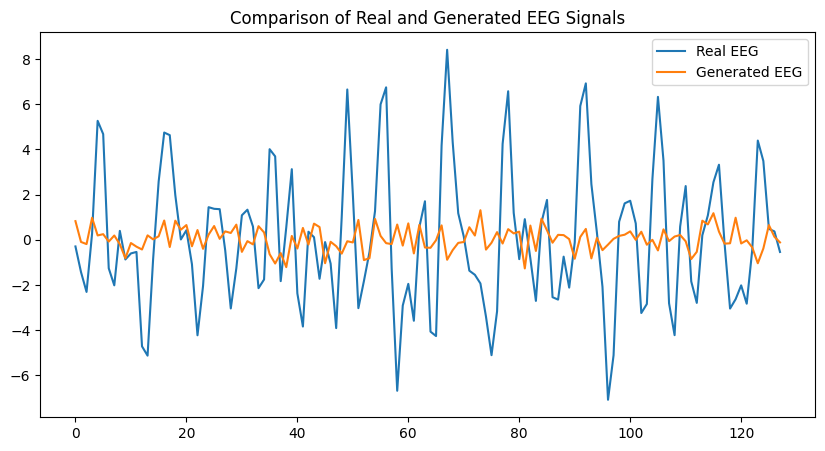

In [21]:
import matplotlib.pyplot as plt

# 绘制真实数据和生成数据
plt.figure(figsize=(10, 5))
plt.plot(data_111[6][:,1,4].cpu().numpy(), label="Real EEG")
plt.plot(fake_data[6][:,1,4].detach().cpu().numpy(), label="Generated EEG")
plt.legend()
plt.title("Comparison of Real and Generated EEG Signals")
plt.show()


In [32]:
print(classifier_model)

SwinTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(128, 128, kernel_size=(4, 4), stride=(4, 4))
    (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (layers): ModuleList(
    (0): BasicLayer(
      (blocks): ModuleList(
        (0): SwinTransformerBlock(
          (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (attn): WindowAttention(
            (qkv): Linear(in_features=128, out_features=384, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=128, out_features=128, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
            (softmax): Softmax(dim=-1)
          )
          (drop_path): Identity()
          (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=128, out_features=512, bias=True)
            (act): GELU()
            (drop1): Dropou

In [22]:
classifier_model = c_model

# 加载参数文件
checkpoint_c = torch.load('./parameters/cross_validation_finetune.pth')

classifier_model.load_state_dict(checkpoint_c['c_model'])

<All keys matched successfully>

In [23]:
classifier_model.eval()

# 初始化变量来记录准确率和总样本数
correct = 0
total = 0

# 禁用梯度计算（测试时不需要反向传播）
with torch.no_grad():
    for inputs, labels in dataloader:  # 从 dataloader 获取输入和标签
        inputs, labels = inputs.to(device), labels.to(device)  # 如果有 GPU，将数据移到 GPU
        
        # 模型预测
        outputs = classifier_model(inputs)
        outputs = outputs[0]

        # 获取预测类别（argmax 返回每行的最大值索引）
        _, predicted = torch.max(outputs, dim=1)
        
        # 累计正确的预测数
        correct += (predicted == labels).sum().item()
        
        # 累计总样本数
        total += labels.size(0)

# 计算准确率
accuracy = correct / total * 100
print(f'Accuracy: {accuracy:.2f}%')


Accuracy: 53.12%
